# Abbreviations
COD: chemical oxygen demand<br>
FU: functional unit<br>
LCA: life cycle assessment<br>
LCIA: life cylce impact assessment<br>
ODE: ordinary differential equation<br> 
TKN: total Kjeldahl nitrogen<br>
TN: total nitrogen<br>
TP: total phosporus<br>
TSS: total suspended solids<br>
wt%: weight percent<br>
WWTP: wastewater treatment plant<br>

# Roadmap through this notebook
In the section "Description of Eindhoven WWTP model output", a thorough description of the state variables of the Eindhoven wastewater treatment plant (WWTP) model is provided. Some other important aspects of the Eindhoven WWTP model are also described. This section is only useful if one aims to get in-depth insight into the WWTP model aspects that were found relevant for the life cycle assessment (LCA) calculations by the author of this notebook. It can be skipped if one aims to only use this notebook for simulations.

In the section "Calculation of life cycle assessment results", of course all LCA calculations are performed. An essential subsection here is "Variables that can be modified to determine the output", where the user of this notebook can choose between LCA options and adjust some output settings. See concerning subsection for explanation.

Another useful subsection for the notebook user is "Gathering of all results and additional formatting of results for plotting". Here, all results that are calculated in the section "Calculation of life cycle assessment results" are listed and can be viewed (for instance, the unformatted raw LCA results stored in dataframes, but also all units, impact category names, and their abbreviations used as ax titles in the plots).

All plots are made in the section "Plots". Here, all the figures that can be generated are generated. The user can analyze these figures here and determine which are useful. In Appendix 3, code is added to facilitate the following: Some very large figures are generated in the plot section. The code in Appendix 3 allows to easily select only relevant plots from these large figures, or to easily divide the large figures into smaller sub-figures. 

Finally, in Appendix 2, life cycle inventory values are calculated, which are traditionally included into LCA reports. Due to the nature of this notebook, life cycle inventory values are not needed in their traditional explicit form (i.e. per value of the functional unit (FU)). Thus, appendix 2 makes it possible to calculate these data when needed.

Notebook written in 2017. Python version: 3.5.2. Anaconda version: 4.2.0 (64-bit), customized. Author: Tom Lauriks.

# Loading of packages and adjusting Python specifications

In [196]:
####Load packages.
import DMLCA_functions as dmlca#Own script with functions (more specifically 2 functions) specifically for this notebook
import pandas as pd#Pandas allows to comfortably work with datasets in python
import numpy as np#Numpy arrays allow you to do quick vector/matrix operations.
###Packages for plotting
import matplotlib.pyplot as plt#To make plots
#In order to make these plots appear automatically.
%matplotlib inline
from matplotlib.ticker import MaxNLocator#Used for limiting number of tick labels on histograms
import pylab as pl#Not sure for what this is. Used it for formatting plot output options.
from matplotlib import gridspec#To adjust sizes of subplots in one figure
from matplotlib.ticker import AutoMinorLocator#To autoamtically add a number of minor ticks if the axis is linear.
##Format the minor tick labels of the y-axis into empty strings with `NullFormatter`, to avoid cumbering the axis with too many labels.
# from matplotlib.ticker import NullFormatter  # useful for `logit` scale
# plt.gca().yaxis.set_minor_formatter(NullFormatter())#Add this line beneath the plot.

####Jupyter settings 
##Print out all results of 1 cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"#To again print out only last cell output
##How many columns of a table that are max. printed out.
pd.set_option('display.max_columns', 150)
# pd.set_option('display.max_columns', 1000)
##Print out dataframes in nice format
#from IPython.display import display, HTML#Insert in the code: display(dataframe)

####To view Jupyter version
# import sys
# sys.version

# Description of Eindhoven WWTP model output
The intention of this section is to determine the meaning of the state variables used in the model and the variables that are calculated out of those state variables. This will be necessary to assign the correct items to the correct impact categories in the LCA and also to not double count items.<br>
<br>
The version of the model that is used for this section, is based on the EHV-10 version of Amerlinck (2015). De Mulder (2017) further modified the EHV-10 version, but these modifications are not yet documented. Luckily, De Mulder (2017) didn't change anything relevant for this section in the current model version.

## Biokinetic model description

The basis of the model is ASM2d. Two extensions were added. (Amerlinck, 2015) In the first extension, no state variables were added (Gernaey and J&oslash;rgensen, 2003). Through the second extension, a particulate inorganic fraction is included (Amerlinck, 2015). 

## State variables original ASM2d biokinetic model

All components are assumed to be homogeneous and distributed throughout the system.<br>
S: Soluble. Only transported with water.<br>
S<sub>A</sub> [M(COD) L<sup>-3</sup> ]: Fermentation end products. Assumed to be acetate for stoichiometric computations. <br>
S<sub>ALK</sub> [mol(HCO<sub>3</sub><sup>-</sup>) L<sup>-3</sup> ]: Alkalinity of the wastewater. Assumed to be HCO<sub>3</sub><sup>-</sup> for stoichiometric computations.<br>
S<sub>F</sub> [M(COD) L<sup>-3</sup> ]: Fermentable readily biodegradable organic substrates. Does not include fermentation products, since these are not fermentable.<br>
S<sub>I</sub> [M(COD) L<sup>-3</sup> ]: Inert soluble organic material. Is partially already in influent and also produced by hydrolysis of particulate substrates X<sub>S</sub>.
<br>
S<sub>N2</sub> [M(N) L<sup>-3</sup> ]: N<sub>2</sub>. Assumed to be the only nitrogenous product of denitrification. May be subject to gas exchange.<br>
S<sub>NH4</sub> [M(N) L<sup>-3</sup> ]: Ammonium + ammonia. For electrical balance, all S<sub>NH4</sub> is assumed to be NH<sub>4</sub><sup>+</sup>).<br>
S<sub>NO3</sub> [M(N) L<sup>-3</sup> ]: Nitrate + nitrite. For stoichiomteric computations, assumed to be nitrate only.<br>
S<sub>O2</sub> [M(O<sub>2</sub>) L<sup>-3</sup> ]: O<sub>2</sub>. May be subject to gas exchange.<br>
S<sub>PO4</sub> [M(P) L<sup>-3</sup> ]: Inorganic soluble phosphorus. Primarily otho-phosphates. For the balance of electrical charges, it is assumed that 50% is H<sub>2</sub>PO<sub>4</sub><sup>-</sup> and 50% HPO<sub>4</sub><sup>2-</sup>, independantly of pH.<br>
X: particulate. Assumed to be associated with the activated sludge (flocculated onto the activated sludge).<br>
X<sub>AUT</sub> [M(COD) L<sup>-3</sup> ]: Nitrifying organisms.<br>
X<sub>H</sub> [M(COD) L<sup>-3</sup> ]: Heterotrophic organisms.<br>
X<sub>I</sub> [M(COD) L<sup>-3</sup> ]: Inert particulate organic material. May be a fraction of the influent or may be produced from biomass decay.<br>
X<sub>MeOH</sub> [M(TSS) L<sup>-3</sup> ]: Metal-hydroxides. This component stands for the phosphorus-binding capacity of possible metal-hydroxides, which may be in the wastewater or may be added to the system. For all stoichiometric computations, assumed to be entirely Fe(OH)<sub>3</sub>. Can be replaced with other reactants, this would require adaptation of the stoichiometric and kinetic information.<br>
X<sub>MeP</sub> [M(TSS) L<sup>-3</sup> ]: Metal-phosphate, MePO<sub>4</sub>. This component results from binding phosphorus to the metal-hydroxides. Assumed to be all FePO<sub>4</sub> for stoichiometric computations. Can be replaced with other precipitation products, this would require adaptation of the stoichiometric and kinetic information.<br>
X<sub>PAO</sub> [M(COD) L<sup>-3</sup> ]: Phosphate-accumulating organisms (PAOs). The concentration X<sub>PAO</sub> doesn't include the cell internal storage products X<sub>PP</sub> and X<sub>PHA</sub>, it only contains "true" biomass. <br>
X<sub>PHA</sub> [M(COD) L<sup>-3</sup> ]: A cell internal storage product of PAOs. Primarily poly-hydroxy-alkanoates (PHA). Occurs only associated with X<sub>PAO</sub> (but is not included therein). For stoichiometric computations assumed to be poly-$\beta$-hydroxy-butyrate (C<sub>4</sub>H<sub>6</sub>O<sub>2</sub>)<sub>n</sub>.<br>
X<sub>PP</sub> [M(P) L<sup>-3</sup> ]: Poly-phosphate. A cell internal storage product of PAOs. Occurs only associated with X<sub>PAO</sub> (but is not included therein). For stoichiometric computations, poly-phosphates are assumed to have following composition: (K<sub>0.33</sub>Mg<sub>0.33</sub>PO<sub>3</sub>)<sub>n</sub>.<br>
X<sub>S</sub> [M(COD) L<sup>-3</sup> ]: Slowly biodegradable substrates. High molecular weight, colloidal and particulate organic substrates. It is assumed that the product of their hydrolysis (S<sub>F</sub>) may be fermented.<br>
X<sub>TSS</sub> [M(TSS) L<sup>-3</sup> ]: Total suspended solids. (Note that P removal and precipitation introduces mineral fractions into the activated sludge.)<br>
(There are 19 state variables.)<br>
(Henze et al., 2000)<br>

## Output of the model as implemented in WEST
### Derived from the influent fractionation, the Gujer matrix and block information
The correct file containing the Gujer matrix in the EHV-10 version is ASM2dChemTemp. This is indicated at the start-up of the model.<br>
<br>
State variables: H2O [L<sup>3</sup> T<sup>-1</sup>]<br>
S<sub>A</sub> [M L<sup>-3</sup>]<br>
S<sub>ALK</sub> [M L<sup>-3</sup>]<br>
S<sub>Al</sub> [M L<sup>-3</sup>]<br>
S<sub>F</sub> [M L<sup>-3</sup>]<br>
S<sub>I</sub> [M L<sup>-3</sup>]<br>
S<sub>N2</sub> [M L<sup>-3</sup>]<br>
S<sub>NH</sub> [M L<sup>-3</sup>]<br>
S<sub>NO</sub> [M L<sup>-3</sup>]<br>
S<sub>O</sub> [M L<sup>-3</sup>]<br>
S<sub>PO</sub> [M L<sup>-3</sup>]<br>
X<sub>AUT</sub> [M L<sup>-3</sup>]<br>
X<sub>H</sub> [M L<sup>-3</sup>]<br>
X<sub>I</sub> [M L<sup>-3</sup>]<br>
X<sub>Ii</sub> [M L<sup>-3</sup>]<br>
X<sub>MEOH</sub> [M L<sup>-3</sup>]<br>
X<sub>MEP</sub> [M L<sup>-3</sup>]<br>
X<sub>PAO</sub> [M L<sup>-3</sup>]<br>
X<sub>PHA</sub> [M L<sup>-3</sup>]<br>
X<sub>PP</sub> [M L<sup>-3</sup>]<br>
X<sub>S</sub> [M L<sup>-3</sup>]<br>
X<sub>TSS</sub> [M L<sup>-3</sup>]<br>

### State variables in WEST that are not in the original ASM2d model
H2O, S<sub>Al</sub>, and X<sub>Ii</sub>.<br>

#### Derived from the influent fractionation
Total flow rate equals water flow rate, thus volume contribution of other components is assumed to be negligible.

#### Derived from the Gujer matrix
H2O: doesn't participate in any process.<br>
S<sub>Al</sub>: doesn't participate in any of the processes in the Gujer matrix.<br>
X<sub>Ii</sub>: doesn't participate in any of the processes in the Gujer matrix.<br>
X<sub>MeOH</sub> and X<sub>MeP</sub> only participate in the processes precipitation and redissolution.<br>

#### Derived from information in WEST (and from Amerlinck (2015))
- In the influent, no X<sub>MeOH</sub>, X<sub>MeP</sub> or S<sub>Al</sub>  is present. S<sub>Al</sub> is only dosed in the "Alum dosing unit" (see below). Besides, X<sub>MeOH</sub> are X<sub>MeP</sub> are suddenly present after this unit, which is strange because they are said te be unused according to the person that constructed the model (see below).
- Chemical phosphate removal: through metal dosing (Amerlinck, 2015). In the Eindhoven model, only Al is dosed. In the model of the block "Alum dosing unit" (the actual name of the block in the model is "DOSAGE_Al"), it is visible that Al$_2$(SO$_4$)$_3$ is dosed (MW = 342, units not indicated, should be g/mol). Outflow of S<sub>Al</sub> [g/d] is generated in this block (again derived from the block model) and its outflow is set equal to the dosage flow times concentration. Thus, this state variable is equal to the concentration of an Al containing species. The units of S<sub>Al</sub> are not specified in this block model. However, in the only place where S<sub>Al</sub> takes place in reactions, the model of the "me_dosing_unit" - called "CHEMICAL_EQ" in the Eindhoven model, MWs for Al species are specified. For every Al species, the MW of Al is used and the MW of Alum is in the comments said to be equal to MW Al. Hence, the units of the state variable S<sub>Al</sub> should be [M(Al) L<sup>-3</sup> ]. The correctness of this only depends on whether or not the parameter C_Dose in the block DOSAGE_Al is correctly set equal to the actual mass of Al dosed (in the form of alum).
- The standard precipitiation model in ASM2d uses the state variables X<sub>MeOH</sub> and X<sub>MeP</sub> to form P-precipitate and thus remove P. These state variables are however not used in the actual precipitation model of the EHV-10 Eindhoven model. Instead, the formed precipitate in the "me_dosing _unit" is directly incorporated into X<sub>Ii</sub> and X<sub>Ii</sub> in its turn into X<sub>TSS</sub>. (Amerlinck, 2017) 
    - And indeed, in the code of the block "me_dosing_unit" X<sub>MeOH</sub> and X<sub>MeP</sub> are not modified.
- Following state variables are indeed altered in the "me_dosing_unit" (again derived from the block model), in accordance with the communication with Amerlinck (2017): X<sub>TSS</sub>, S<sub>Al</sub>, X<sub>Ii</sub>, and S<sub>PO</sub>
    - S<sub>PO</sub> leaving the unit is calculated according to the precipiation model, i.e. how much is left after the precipitation process.
    - To X<sub>Ii</sub> entering the unit, the weight of precipitate that is formed in the unit is added. To calculate this weight, the MW of the precipitate described in the bullet point below is used!
        - Calculation: X<sub>Ii,out</sub>= X<sub>Ii,in</sub>+MW<sub>precipitate</sub>/MW<sub>P</sub>(S<sub>PO,in</sub>-S<sub>PO,out</sub>), where the state variables have the units of mass flow rates, i.e. [M T$^{-1}$]. Note that 1 mole of precipitate indeed contains 1 mole of P and that S<sub>PO,in</sub>-S<sub>PO,out</sub> is equal to g P incorporated into precipitate per day.  
    - From S<sub>Al</sub> entering the unit, the Al (expressed as g Al) that is used to form precipitate is subtracted.
        - Calculation: S<sub>Al,out</sub>=S<sub>Al,in</sub>-(mole Al/mole precipitate)(MW Al)(MW P)<sup>-1</sup>(S<sub>PO,in</sub>-S<sub>PO,out</sub>), where the state variables have the units of mass flow rates, i.e. [M T$^{-1}$].
    - To X<sub>TSS</sub> entering the unit, the weight of precipitate that is formed in the unit is added in the same way as for X<sub>Ii</sub>. This actually makes sense from the viewpoint of the units, since both the weight of precipitate (see bullet point below) and X<sub>Ii</sub> are indeed g TSS. 
    - All other state variables are unaltered in this block!
- Molecular composition of the formed P-precipitate in the block model of the "me_dosing_unit": Al<sub>1.2</sub>H<sub>2</sub>PO<sub>4</sub>(OH)<sub>2.6</sub>. 
- The units of X<sub>MeOH</sub> and X<sub>MeOH</sub> are [M(TSS) L<sup>-3</sup> ], see below in "Calculate TSS, CODt, TN, TP and TKN". Note that these variables should however be unused, but that they seem to appear erroneously in the calculations, albeit in very low concentrations. No other block in the Eindhoven model can be found that could be responsible for this. The most plausible reason for the appearance of the very low concentrations are errors due to the numerical ordinary differential equation (ODE) approximations.

## Derivation of how COD, TSS, TN, TP and TKN are calculated in the model
The following available measurements from "multiprobe sensors" from the model seem interesting: total COD (CODt), TKN, TN, TP, TSS (which is also a state variable), where the abbreviations stand for chemical oxygen demand, total Kjeldahl nitrogen, total nitrogen, total phosphorus, and total suspended solids respectively. Therefore it has to be known how these are calculated, in order not to double count certain items if these model "measurements" are used as input for the LCA.

### Original ASM2d composition
In Henze et al. (2000) on p. 84 can be found which fractions of the state variables in ASM2d are made up of COD, N, P, and suspended solids. These data can also be found in Table 1.<br> 
<br>
Table 1: Conversion factors i<sub>c,i</sub> to be applied in the conservation equations of ASM2d. Missing values are equal to 0. The units of i<sub>c,i</sub> are M<sub>c</sub> M<sub>i</sub><sup>-1</sup>, e.g. i<sub>N,2</sub> = i<sub>N,S<sub>F</sub></sub> g N g<sup>-1</sup> COD. (Henze et al., 2000) The values that were assigned to the conversion factors, e.g. i<sub>N,S<sub>F</sub></sub>=0.03, were retrieved from the Eindhoven model.
<table style="width:100%">
  <tr>
    <th>Index c:</th><th>Conservation for</th><th></th><th>COD</th><th>N</th><th>P</th><th>Mass</th>
  </tr>
  <tr>
    <th>Factor</th><th></th><th></th><th>i<sub>COD,i</sub></th><th>i<sub>N,i</sub></th><th>i<sub>P,i</sub></th><th>i<sub>TSS,i</sub></th>
  </tr>
  <tr>
    <th>index i:</th><th>Component</th><th>Units</th><th>g COD</th><th>g N</th><th>g P</th><th>g TSS</th>
  </tr>
  <tr>
    <td>1</td><td>S<sub>O2</sub></td><td>g O2</td><td>-1</td><td></td><td></td><td></td>
  </tr>
  <tr>
    <td>2</td><td>S<sub>F</sub></td><td>g COD</td><td>1</td><td>i<sub>N,S<sub>F</sub></sub>=0.03</td><td>i<sub>P,S<sub>F</sub></sub>=0.01</td><td></td>
  </tr>
  <tr>
    <td>3</td><td>S<sub>A</sub></td><td>g COD</td><td>1</td><td></td><td></td><td></td>
  </tr>
  <tr>
    <td>4</td><td>S<sub>NH</sub></td><td>g N</td><td></td><td>1</td><td></td><td></td>
  </tr>
  <tr>
    <td>5</td><td>S<sub>NO</sub></td><td>g N</td><td>-64/14</td><td>1</td><td></td><td></td>
  </tr>
  <tr>
    <td>6</td><td>S<sub>PO</sub></td><td>g P</td><td></td><td></td><td>1</td><td></td>
  </tr>
  <tr>
    <td>7</td><td>S<sub>I</sub></td><td>g COD</td><td>1</td><td>i<sub>N,S<sub>I</sub></sub>=0.01<b>=0.033</b><sup>a)</sup></td><td>i<sub>P,S<sub>I</sub></sub>=0</td><td></td>
  </tr>
  <tr>
    <td>8</td><td>S<sub>ALK</sub></td><td>mole HCO<sub>3</sub><sup>-</sup></td><td></td><td></td><td></td><td></td>
  </tr>
  <tr>
    <td>9</td><td>S<sub>N2</sub></td><td>g N</td><td>-24/14</td><td>1</td><td></td><td></td>
  </tr>
  <tr>
    <td>10</td><td>X<sub>I</sub></td><td>g COD</td><td>1</td><td>i<sub>N,X<sub>I</sub></sub>=0.02</td><td>i<sub>P,X<sub>I</sub></sub>=0.01</td><td>i<sub>TSS,X<sub>I</sub></sub>=0.75</td>
  </tr>
  <tr>
    <td>11</td><td>X<sub>S</sub></td><td>g COD</td><td>1</td><td>i<sub>N,X<sub>S</sub></sub>=0.04</td><td>i<sub>P,X<sub>S</sub></sub>=0.01</td><td>i<sub>TSS,X<sub>S</sub></sub>=0.75</td>
  </tr>
  <tr>
    <td>12</td><td>X<sub>H</sub></td><td>g COD</td><td>1</td><td>i<sub>N,BM</sub>=0.07</td><td>i<sub>P,BM</sub>=0.02</td><td>i<sub>TSS,BM</sub>=0.9</td>
  </tr>
  <tr>
    <td>13</td><td>X<sub>PAO</sub></td><td>g COD</td><td>1</td><td>i<sub>N,BM</sub>=0.07</td><td>i<sub>P,BM</sub>=0.02</td><td>i<sub>TSS,BM</sub>=0.9</td>
  </tr>
  <tr>
    <td>14</td><td>X<sub>PP</sub></td><td>g P</td><td></td><td></td><td>1</td><td>3.23</td>
  </tr>
  <tr>
    <td>15</td><td>X<sub>PHA</sub></td><td>g COD</td><td>1</td><td></td><td></td><td>0.60</td>
  </tr>
  <tr>
    <td>16</td><td>X<sub>AUT</sub></td><td>g COD</td><td>1</td><td>i<sub>N,BM</sub>=0.07</td><td>i<sub>P,BM</sub>=0.02</td><td>i<sub>TSS,BM</sub>=0.9</td>
  </tr>
  <tr>
    <td>17</td><td>X<sub>TSS</sub></td><td>g TSS</td><td></td><td></td><td></td><td>-1 <sup>b)</sup></td>
  </tr>
  <tr>
    <td>18</td><td>X<sub>MeOH</sub></td><td>g TSS</td><td></td><td></td><td></td><td>1</td>
  </tr>
  <tr>
    <td>19</td><td>X<sub>MeP</sub></td><td>g TSS</td><td></td><td></td><td>0.205</td><td>1</td>
  </tr>
</table> 
b) Since TSS are counted twice, this factor needs to be negative.<br>
a) The value not in bold is the default value as defined in WEST. The value in bold is the used value in de Eindhoven WWTP model.
<br>

### Using these data on the model output
In the following, TSS, TN, TP, TKN, and CODt will be calculated from the model output with the data from Table 1. Calculations will be performed for time equals 250 days of a steady state simulation. The used data are values of virtual measurements or state variables in the unit where sludge exits the WWTP.

#### Read in the data

In [197]:
###Read in txt file as pandas dataframe. 
#Tabs are treated as column separators, lines as rows.
data3 = pd.read_csv('data/wwtpModelResults/concentrationsWasteSludge_drySS_t250.txt',sep="\t", header = None)
###Copy pandas dataframe. Original will not be overwritten if modify copy.
data2=data3.copy(deep=True);
###Numbers are read in as strings=> convert to floats.
for i in list(range(0,data2.shape[1])):
    data2.loc[data3.shape[0]-1,i]=float(data2.loc[data3.shape[0]-1,i])
    #type(data2.loc[data.shape[0]-1,i])#Test
data2

0                   1                   2                  3   \
0  #.t  .MULTI_WASTE.y_COD  .MULTI_WASTE.y_TKN  .MULTI_WASTE.y_TN   
1   #d                g/m3                g/m3               g/m3   
2  250             9195.63             440.398            442.278   

                  4                              5   \
0  .MULTI_WASTE.y_TP  .Sludge_disposal.Outflow(H2O)   
1               g/m3                           m3/d   
2            381.325                           3024   

                              6                                7   \
0  .Sludge_disposal.Outflow(S_A)  .Sludge_disposal.Outflow(S_ALK)   
1                           g/m3                             g/m3   
2                      0.0663445                         0.329879   

                               8                              9   \
0  .Sludge_disposal.Outflow(S_Al)  .Sludge_disposal.Outflow(S_F)   
1                            g/m3                           g/m3   
2                     5.54258e-72                       0.391032   

                              10                              11  \
0  .Sludge_disposal.Outflow(S_I)  .Sludge_disposal.Outflow(S_N2)   
1                           g/m3                            g/m3   
2                        48.2753                         10.5763   

                               12                              13  \
0  .Sludge_disposal.Outflow(S_NH)  .Sludge_disposal.Outflow(S_NO)   
1                            g/m3                            g/m3   
2                         31.6242                         1.88011   

                              14                              15  \
0  .Sludge_disposal.Outflow(S_O)  .Sludge_disposal.Outflow(S_PO)   
1                           g/m3                            g/m3   
2                        8.62892                        0.245981   

                                16                             17  \
0  .Sludge_disposal.Outflow(X_AUT)  .Sludge_disposal.Outflow(X_H)   
1                             g/m3                           g/m3   
2                          66.8805                        2169.63   

                              18                               19  \
0  .Sludge_disposal.Outflow(X_I)  .Sludge_disposal.Outflow(X_I_i)   
1                           g/m3                             g/m3   
2                        5742.66                          410.491   

                                 20                               21  \
0  .Sludge_disposal.Outflow(X_MEOH)  .Sludge_disposal.Outflow(X_MEP)   
1                              g/m3                             g/m3   
2                       3.56561e-76                      2.15648e-75   

                                22                               23  \
0  .Sludge_disposal.Outflow(X_PAO)  .Sludge_disposal.Outflow(X_PHA)   
1                             g/m3                             g/m3   
2                          1095.92                          3.58865   

                               24                             25  \
0  .Sludge_disposal.Outflow(X_PP)  .Sludge_disposal.Outflow(X_S)   
1                            g/m3                           g/m3   
2                         256.318                         68.213   

                                26  
0  .Sludge_disposal.Outflow(X_TSS)  
1                             g/m3  
2                           8597.9

#### Calculate TSS, CODt, TN, TP and TKN
Values will be calculated according to the original version of ASM2d. If these values don't match the model output, additional operations will be performed until the calculated value matches the model output. <br>
Note that when the file concentrationsWasteSludge_drySS_t250.txt was made, i<sub>N,XI</sub> and I<sub>N,SI</sub> were erroneously set to 0.03 and 0.01. Thus only for the calculations below, these values will be used.

In [198]:
###Assigning correct values to conversion factors, see Table 1.
i_NSF=0.03;i_PSF=0.01;i_NSI=0.01;i_PSI=0;i_NXI=0.03;i_PXI=0.01;i_TSSXI=0.75;i_NXS=0.04;i_PXS=0.01;i_TSSXS=0.75;i_NBM=0.07;i_PBM=0.02;i_TSSBM=0.9;
###Calculation of TSS. 
TSS=data2.loc[2,21]+data2.loc[2,20]+data2.loc[2,16]*i_TSSBM+data2.loc[2,23]*0.6+data2.loc[2,24]*3.23+data2.loc[2,22]*i_TSSBM+data2.loc[2,17]*i_TSSBM+data2.loc[2,25]*i_TSSXS+data2.loc[2,18]*i_TSSXI
#Adding X_li, which is not a standard component of ASM2d.
TSS=data2.loc[2,19]+TSS
print('Value 1: calculated TSS, value 2: state variable of the model')
TSS;data2.loc[2,26]
###Calculation of CODt. Note that O2 supplying species are subtracted.
CODt=data2.loc[2,14]*(-1)+data2.loc[2,9]+data2.loc[2,6]+data2.loc[2,13]*(-64/14)+data2.loc[2,10]+data2.loc[2,11]*(-24/14)+data2.loc[2,18]+data2.loc[2,25]+data2.loc[2,17]+data2.loc[2,22]+data2.loc[2,23]+data2.loc[2,16]
#Again adding the negative, thus O2 supplying, species.
CODt=CODt+data2.loc[2,11]*(24/14)+data2.loc[2,13]*(64/14)+data2.loc[2,14]*(1)
print('Value 1: calculated CODt, value 2: calculated COD by the model')
CODt;data2.loc[2,1]
###Calculation of TN.
TN=data2.loc[2,9]*i_NSF+data2.loc[2,12]+data2.loc[2,13]+data2.loc[2,10]*i_NSI+data2.loc[2,18]*i_NXI+data2.loc[2,25]*i_NXS+data2.loc[2,17]*i_NBM+data2.loc[2,22]*i_NBM+data2.loc[2,16]*i_NBM
#9=SF, 12: SNH ,13: SNO ,10: SI ,11: SN2 ,18: XI ,25: XS ,17: XH ,22: XPAO ,16: XAUT
print('Value 1: calculated TN, value 2: calculated TN by the model')
TN;data2.loc[2,3]
TP=data2.loc[2,9]*i_PSF+data2.loc[2,15]+data2.loc[2,18]*i_PXI+data2.loc[2,25]*i_PXS+data2.loc[2,17]*i_PBM+data2.loc[2,22]*i_PBM+data2.loc[2,24]+data2.loc[2,16]*i_PBM+data2.loc[2,21]*0.205
print('Value 1: calculated TP, value 2: calculated TP by the model')
TP;data2.loc[2,4]
### Setting the conversion factors back to the correct values
i_NSI=0.033;i_PSI=0;i_NXI=0.02

Value 1: calculated TSS, value 2: state variable of the model


8597.89841924

8597.8984

Value 1: calculated CODt, value 2: calculated COD by the model


9195.629290946

9195.6293

Value 1: calculated TN, value 2: calculated TN by the model


442.2777042068001

442.2777

Value 1: calculated TP, value 2: calculated TP by the model


381.3254503256

381.32545

Thus:<br>
<ul>
<li>X<sub>TSS</sub>=X<sub>MEP</sub>+X<sub>MEOH</sub>+i<sub>TSS,BM</sub> &#42;X<sub>AUT</sub>+0.60 &#42;X<sub>PHA</sub>+3.23 &#42;X<sub>PP</sub>+i<sub>TSS,BM</sub> &#42;X<sub>PAO</sub>+i<sub>TSS,BM</sub> &#42;X<sub>H</sub>+i<sub>TSS,XS</sub> &#42;X<sub>S</sub>+i<sub>TSS,XI</sub> &#42;X<sub>I</sub>+X<sub>Ii</sub></li>
<li>CODt=S<sub>A</sub>+S<sub>F</sub>+X<sub>S</sub>+S<sub>I</sub>+X<sub>I</sub>+X<sub>AUT</sub>+X<sub>H</sub>+X<sub>PAO</sub>+X<sub>PHA</sub></li>
<li>TN=S<sub>NO</sub>+S<sub>NH</sub>+i<sub>N,SI</sub> &#42;S<sub>I</sub>+i<sub>N,SF</sub> &#42;S<sub>F</sub>+i<sub>N,XI</sub> &#42;X<sub>I</sub>+i<sub>N,XS</sub> &#42;X<sub>S</sub>+i<sub>N,BM</sub> &#42;(X<sub>H</sub>+X<sub>AUT</sub>+X<sub>PAO</sub>)</li>
<li>TKN=S<sub>NH</sub>+i<sub>N,SI</sub> &#42;S<sub>I</sub>+i<sub>N,SF</sub> &#42;S<sub>F</sub>+i<sub>N,XI</sub> &#42;X<sub>I</sub>+i<sub>N,XS</sub> &#42;X<sub>S</sub>+i<sub>N,BM</sub> &#42;(X<sub>H</sub>+X<sub>AUT</sub>+X<sub>PAO</sub>)</li>
<li>TP=S<sub>PO</sub>+X<sub>PP</sub>+0.205 &#42;X<sub>MEP</sub>+0 &#42;S<sub>I</sub>+i<sub>P,SF</sub> &#42;S<sub>F</sub>+i<sub>P,XI</sub> &#42;X<sub>I</sub>+i<sub>P,XS</sub> &#42;X<sub>S</sub>+i<sub>P,BM</sub> &#42;(X<sub>H</sub>+X<sub>AUT</sub>+X<sub>PAO</sub>)</li>
<li>TSS is calculated by the model by summing up all components mentioned in the original ASM2d version. Only one extra component is added: X<sub>li</sub>, which is 1 of the only 2 components not originally in ASM2d. The units of X<sub>li</sub> are g TSS/m3, since the conversion factor to g TSS is 1. X<sub>li</sub> is particulate inorganic inert material. Furthermore, in the blockmodel of the multiprobe Multiprobe sensor can be seen that the measured value for X<sub>TSS</sub> is the value of the state variable (thus not the calculated value).</li>
<li>By subtracting S<sub>NO</sub> from TN, TKN is obtained.</li>
<li>X<sub>Ii</sub> contains P, since the weight of the (P-containing) precipitate formed in the me_dosing_unit is added to X<sub>Ii</sub>! Note however that X<sub>Ii</sub> is not used by WEST to calculate TP. The P incorporated into X<sub>Ii</sub> leaving via the WWTP effluent therefore somehow has to be calculated, because it is not tracked by the model.</li>
</ul>

## Differences of the biokinetic model of the EHV-10 version of the Eindhoven model with the original ASM2d model
<ul>
<li>Conversion factors given in table 1.</li>
<li>Water is included, but it doesn't participate in any process. It thus only serves as solvent.</li>
<li>Extra state variable: S<sub>Al</sub> = soluble alum (Al$_2$(SO$_4$)$_3$) concentration. Units: [M(Al) L<sup>-3</sup> ]</li>
<li>Extra state variable: X<sub>li</sub> = particulate inorganic inert material. Units: [M(TSS) L<sup>-3</sup> ]. P is added to this variable in the me_dosing_unit!</li>
<li>X<sub>MeOH</sub> and X<sub>MeP</sub> [M(TSS) L<sup>-3</sup> ]. Same as in original ASM2d, but unused in the EHV-10 version of the Eindhoven model. However, not removed as state variables! Simply set to zero in influent and no other sources of them present anywhere else in the model. Appearance of the erroneous but very low concentrations are most likely artifacts due to the numerical ODE approximations.</li>
</ul>

## Fate of gases
- CO<sub>2</sub> is not a state variable. However, biomass grows on carbon compounds with a yield coefficient, i.e. C not incorporated into biomass is respired. CO<sub>2</sub> probably leaves the system through this yield coefficient, it simply dissapears (De Mulder, 2017).
- S<sub>N2</sub> is a state variable. The mass balance on N can hence be closed.
- However, gases in the reactors might be subject to gas exchanges (De Mulder, 2017). Hence, if amounts of produced gases are needed (which is not the case for N$_2$ in this notebook), it might be advisable to calculate them through mass balances.

# Calculation of life cycle assessment results
## Variables that can be modified to determine the output
Some explanation about settings that can be modified is probably useful. First of all, it is important to note that this notebook is written such that it will only work well if data in WEST are written out for certain equal and small time intervals. The length of these intervals can be chosen in WEST. (An earlier version was written such that it can handle a variable step size ODE solver output. However, the resulting output time intervals were sometimes rather big, which resulted in inaccurate calculated results - which involve numerical integration - in the notebook. Therefore, the current approach was chosen instead.)

Subsequently, different options are available. It can be chosen whether LCA results will vary in time or a classical LCA will be calculated, i.e. a single value for each impact category per scenario. In addition, different functionals units can be chosen. Finally, some options are available to modify the output of results. Below, the variables that determine these settings are listed:
- "time_intervals": Boolean (True or False).
    - False: 1 LCA result will be calculated for the whole simulated time span (classical LCA).
    - True: LCA results will vary in time, i.e. multiple results for specified time intervals will be calculated. 
    - Also influences which plots are generated. Since both "dynamic" and classical LCA results can be calculated, only the plots that make sense for the respective cases will be made. 
- "time_units": Integer.
    - Determines the length of the considered time intervals. For instance, if value is 5, every 5 time units that were written out by WEST an LCA result will be calculated. 
- "data_str": String, e.g. 'data/wwtpModelResults/filename.txt'.
    - The WWTP model output that will be loaded to perform the LCA calculations has to be specified as a string, assigned to this variable. 
- "load_data": Boolean (True or False).
    - If subsequent runs of the notebook are performed with the same dataset, it can be chosen to not load the dataset again by setting to False. (Loading the data is rather time consuming.)
- "fu": Integer.
    - Choose from available functional units. See code for options.
- "heatmaps": Boolean (True or False).
    - In the case of a dynamic LCA, heat maps can be made. However, loading of the needed packages will make the layout of the other plots in the next notebook execution ugly. Can therefore be set to False in order not to make heat maps in the current run.
- "save_plots": Boolean (True or False).
    - True: save the generated figures. 
- "scenario_name": string, e.g. 'sensible_name'
    - If plots are saved, they have to have a filename. The last parts of the filenames are defined in the cells where the respective plots are made. The string contained in "scenario_name" will be added at the beginning of the below defined filenames.
- "store_results": Boolean (True or False).
    - If a classical LCA is performed, a bar chart that compares the scenarios can be generated automatically. Of course, results will have to be stored in between notebook executions, which will happen if set to True.
    - The string contained in "scenario_name" will be used as key in a dict used to store the results. Thus, it needs to be altered every time a new scenario needs to be stored, or the previous result will be overwritten.
- "intialize_scenarios": Boolean (True or False).
    - True: erase any information that was already stored. Also needs to be True when first scenario is stored.
    - False: After initializing and thus storing the first scenario, store next scenarios if notebook executed again.
- "plot_comparison": Boolean (True or False).
   - True: If store results is also true, plot bar chart that makes comparison.
   - False: Don't make this plot.
- "legend_name": Sring, e.g. 'FU: kg P'
    - Used as legend label for the current scenario in the comparison bar chart.
- "TKN_biology": Boolean (True or False).
    - True: Emission factor of N$_2$O based on TKN load on biology.
    - False: Emission factor of N$_2$O based on TKN load influent.
- "LCI": Boolean (True or False).
    - True: calculate LCI data in the appendix.

In [199]:
time_intervals=True
# time_intervals=False
time_units=60##Currently data file time interval is 2 s.
data_str='data/wwtpModelResults/dynamic_to342days.txt'
##Current options: 
#'data/wwtpModelResults/dynamic_to342days.txt'
#'data/wwtpModelResults/dynamic_to332days.txt'
#'data/wwtpModelResults/SS_320to342.txt'
#'data/wwtpModelResults/SS_320to332.txt'
#'data/wwtpModelResults/control_p_peaks.txt'
#'data/wwtpModelResults/biomass_plus_500.txt'
#'data/wwtpModelResults/setpoint_02_05.txt'

load_data=True
# load_data=False
fu=6 #0: no scaling, 1: /m3 influent, 2: /kg COD influent, 3: /kg P influent,4: /kg N influent, 5: /kmol N+P influent, 6: / day operation
heatmaps=True
# heatmaps=False
save_plots=True
save_plots=False
scenario_name='reference_scenario_fu_day'
store_results=True
store_results=False
intialize_scenarios=True
intialize_scenarios=False
plot_comparison=True
plot_comparison=False
legend_name='4: Reference'
# TKN_biology=True
TKN_biology=False
LCI=True
# LCI=False

## Importing the WEST output data and modifying the layout of the data

In [200]:
if load_data:
    ###For assessing the speed of the code
    from time import gmtime, strftime
    print('Start loading and modifying')
    strftime("%Y-%m-%d %H:%M:%S", gmtime())
    ###Defining new names for the variables that will be imported.
    new_var_names={'#.t':'time','.AEROBIC_4.DO':'controller_nh4_do','.CHEMICAL_EQ.Inflow(H2O)':'precip_q',\
                   '.CHEMICAL_EQ.Inflow(S_PO)':'precip_S_PO_in','.CHEMICAL_EQ.Outflow(S_PO)':'precip_S_PO_out',\
                   '.COST.TotalAerationEnergy':'energy_aeration','.COST.TotalMixingEnergy':'energy_mixing',\
                   '.COST.TotalPumpingEnergy':'energy_pumping','.DOSAGE_Al.M_Alum':'dosing_alum',\
                   '.MULTI_EFFL.Inflow(S_A)':'effl_S_A','.MULTI_EFFL.Inflow(S_NH)':'effl_S_NH','.MULTI_EFFL.Inflow(S_NO)':'effl_S_NO',\
                   '.MULTI_EFFL.Inflow(S_PO)':'effl_S_PO',\
                   '.MULTI_EFFL.Inflow(X_I_i)':'effl_X_I_i',\
                   '.MULTI_EFFL.Inflow(X_TSS)':'effl_X_TSS','.MULTI_EFFL.y_COD':'effl_COD','.MULTI_EFFL.y_Q':'effl_q',\
                   '.MULTI_EFFL.y_TKN':'effl_TKN','.MULTI_EFFL.y_TN':'effl_TN','.MULTI_EFFL.y_TP':'effl_TP',\
                   '.MULTI_IN.Inflow(S_NH)':'infl_S_NH','.MULTI_IN.Inflow(S_NO)':'infl_S_NO','.MULTI_IN.Inflow(S_PO)':'infl_S_PO',\
                   '.MULTI_IN.Inflow(X_TSS)':'infl_X_TSS','.MULTI_IN.y_COD':'infl_COD','.MULTI_IN.y_Q':'infl_q','.MULTI_IN.y_TKN':\
                   'infl_TKN','.MULTI_IN.y_TN':'infl_TN','.MULTI_IN.y_TP':'infl_TP','.Multi_PST.y_TSS':'waste_TSS2', '.Multi_PST.y_Q':\
                   'waste_q2','.MULTI_WASTE.Inflow(X_I_i)':'waste_X_I_i','.MULTI_WASTE.y_Q':'waste_q','.MULTI_WASTE.y_TSS':'waste_TSS',\
                   '.Multi_AER1_IN.y_COD':'aer1_COD_in','.Multi_AER1_IN.y_Q':'aer1_q','.Multi_AER1_OUT.y_COD':\
                   'aer1_COD_out','.Multi_AER2_OUT.y_COD':'aer2_COD_out','.Multi_AER3_OUT.y_COD':'aer3_COD_out',\
                   '.Multi_AER4_OUT.y_COD':'aer4_COD_out','.Multi_AER5_OUT.y_COD':'aer5_COD_out',\
                   '.Multi_AER6_IN.y_COD':'aer6_COD_in','.Multi_AER6_IN.y_Q':'aer6_q','.Multi_AER6_OUT.y_COD':\
                   'aer6_COD_out','.Multi_ANAER1_IN.y_COD':'ana1_COD_in','.Multi_ANAER1_IN.y_Q':'ana1_q',\
                   '.Multi_ANAER1_OUT.y_COD':'ana1_COD_out','.Multi_ANAER2_OUT.y_COD':'ana2_COD_out',\
                   '.Multi_ANAER3_OUT.y_COD':'ana3_COD_out','.Multi_ANAER4_OUT.y_COD':'ana4_COD_out',\
                   '.Multi_ANOX1_IN.y_COD':'ano1_COD_in','.Multi_ANOX1_IN.y_Q':'ano1_q','.Multi_ANOX1_OUT.y_COD'\
                   :'ano1_COD_out','.Multi_ANOX2_OUT.y_COD':'ano2_COD_out','.RecB.Q_Out2_Actual':'recB_pump_flowRate',\
                   '.MULTI_IN_BIO.y_TKN':'biology_TKN','.MULTI_IN_BIO.y_Q':'biology_q'}
    ###Added: '.MULTI_PST.y_TSS':'waste_TSS2', '.MULTI_PST.y_Q':'waste_q2', '.AEROBIC_4.DO':'controller_nh4_do', 
    ###'.RecB.Q_Out2_Actual':'recB_pump_flowRate'

    ### Load data
    data = pd.read_table(data_str, sep='\t',dtype=str)
    ###Replace the to complicated variable names
    data = data.rename(columns=new_var_names)
    ###Store the units of the variables in a separate dataframe, and remove them from the dataframe 
    ###that will be used as input for the LCA
    units=data.head(1).copy()
    data=data.drop(data.index[[0]])
    data=data.reset_index(drop=True)
    ###Read in data are strings, transform these strings to numbers
    data = data.astype(float)
    ###Additional data transformations
    data['precip_S_PO_out']=data['precip_S_PO_out']*-1#Since outflow is negative in WEST and I want absolute values
    data['precip_q']=data['precip_q']/10**6#Conversion of flow rate in g/d to m^3/d
    units['precip_q']='m3/d'#Update units
    units['time']=units.loc[0,'time'][1:]
    ###For some reason, WEST writes last time point two times out
    data.drop(data.index[len(data)-1], inplace=True)
    ###For assessing the speed of the code
    print('Data loaded')
    strftime("%Y-%m-%d %H:%M:%S", gmtime())

###Display the imported and modified data
#Show first five rows of dataset
data.head()#Uncomment to view
#Show entire dataset
# data#Uncomment to view 
#Show units of the variables
units

Start loading and modifying


'2017-06-09 17:23:31'

Data loaded


'2017-06-09 17:24:13'

time  controller_nh4_do   precip_q  precip_S_PO_in  precip_S_PO_out  \
0  320.00000           1.223312  221053.64       903341.91        200870.83   
1  320.00002           1.225822  221593.95       903563.39        212932.90   
2  320.00005           1.228322  222111.28       903775.46        225102.97   
3  320.00007           1.230821  222623.47       903985.44        237287.02   
4  320.00009           1.233295  223086.45       904175.27        249605.33   

   energy_aeration  energy_mixing  energy_pumping  dosing_alum   effl_S_A  \
0       76829583.0      1748836.9    2.275014e+09    831169.08  12881.686   
1       76829567.0      1748836.9    2.275014e+09    794131.54  12507.912   
2       76829552.0      1748836.9    2.275014e+09    758669.73  12150.158   
3       76829536.0      1748836.9    2.275014e+09    723559.37  11795.974   
4       76829521.0      1748836.9    2.275014e+09    691823.21  11476.072   

   effl_S_NH  effl_S_NO  effl_S_PO  effl_X_I_i  effl_X_TSS   effl_COD  \
0  580717.63  1501353.3  165231.97   564415.43   2947385.7  56.530121   
1  564100.64  1457877.1  160463.17   508288.30   2654289.0  55.904863   
2  548181.49  1416258.5  155897.14   458826.48   2395998.7  55.339978   
3  532418.36  1375053.5  151376.30   410597.09   2144144.1  54.786702   
4  518153.21  1337819.5  147289.39   374200.02   1954078.0  54.344884   

      effl_q  effl_TKN   effl_TN   effl_TP  infl_S_NH  infl_S_NO  infl_S_PO  \
0  348861.04  3.584214  7.887800  0.593349  4904857.1        0.0  913788.59   
1  338799.82  3.559829  7.862882  0.584654  4904857.1        0.0  913788.59   
2  329165.98  3.537816  7.840365  0.576798  4904857.1        0.0  913788.59   
3  319627.42  3.516260  7.818309  0.569104  4904857.1        0.0  913788.59   
4  311003.65  3.499085  7.800685  0.562958  4904857.1        0.0  913788.59   

   infl_X_TSS   infl_COD     infl_q   infl_TKN    infl_TN    infl_TP  \
0  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   
1  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   
2  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   
3  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   
4  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   

   biology_q  biology_TKN  waste_X_I_i  waste_q  waste_TSS  aer1_COD_in  \
0  123341.23    40.452307          0.0      0.0        0.0    3402.2371   
1  123341.23    50.709788          0.0      0.0        0.0    3402.2316   
2  123341.23    50.709788          0.0      0.0        0.0    3402.2262   
3  123341.23    50.709788          0.0      0.0        0.0    3402.2207   
4  123341.23    50.709788          0.0      0.0        0.0    3402.2150   

      aer1_q  aer1_COD_out  aer2_COD_out  aer3_COD_out  aer4_COD_out  \
0  6729093.8     3402.0822     3402.0057     3401.8970     3401.6776   
1  6719044.9     3402.0820     3402.0055     3401.8968     3401.6774   
2  6709424.1     3402.0817     3402.0052     3401.8965     3401.6772   
3  6699898.8     3402.0814     3402.0050     3401.8963     3401.6769   
4  6691290.2     3402.0809     3402.0048     3401.8961     3401.6767   

   aer5_COD_out  aer6_COD_in     aer6_q  aer6_COD_out  ana1_COD_in     ana1_q  \
0     3401.6442    3401.6442  6022687.8     3401.5459    1619.7069  221053.64   
1     3401.6440    3401.6440  6012626.6     3401.5458    1788.5242  221593.95   
2     3401.6438    3401.6438  6002992.8     3401.5457    1792.3036  222111.28   
3     3401.6436    3401.6436  5993454.2     3401.5456    1796.0422  222623.47   
4     3401.6434    3401.6434  5984830.4     3401.5455    1799.3888  223086.45   

   ana1_COD_out  ana2_COD_out  ana3_COD_out  ana4_COD_out  ano1_COD_in  \
0     1887.3975     1887.0448     1886.8806     1886.7275    3401.8344   
1     1887.2086     1887.0446     1886.8807     1886.7275    3397.9078   
2     1887.0292     1887.0440     1886.8807     1886.7276    3394.1379   
3     1886.8513     1887.0434     1886.8807     1886.727

time controller_nh4_do precip_q precip_S_PO_in precip_S_PO_out  \
0    d            gO2/m3     m3/d            g/d             g/d   

  energy_aeration energy_mixing energy_pumping dosing_alum effl_S_A effl_S_NH  \
0            kW.h          kW.h           kW.h         g/d      g/d       g/d   

  effl_S_NO effl_S_PO effl_X_I_i effl_X_TSS effl_COD effl_q effl_TKN effl_TN  \
0       g/d       g/d        g/d        g/d     g/m3   m3/d     g/m3    g/m3   

  effl_TP infl_S_NH infl_S_NO infl_S_PO infl_X_TSS infl_COD infl_q infl_TKN  \
0    g/m3       g/d       g/d       g/d        g/d     g/m3   m3/d     g/m3   

  infl_TN infl_TP biology_q biology_TKN waste_X_I_i waste_q waste_TSS  \
0    g/m3    g/m3      m3/d        g/m3         g/d    m3/d      g/m3   

  aer1_COD_in aer1_q aer1_COD_out aer2_COD_out aer3_COD_out aer4_COD_out  \
0        g/m3   m3/d         g/m3         g/m3         g/m3         g/m3   

  aer5_COD_out aer6_COD_in aer6_q aer6_COD_out ana1_COD_in ana1_q  \
0         g/m3        g/m3   m3/d         g/m3        g/m3   m3/d   

  ana1_COD_out ana2_COD_out ana3_COD_out ana4_COD_out ano1_COD_in ano1_q  \
0         g/m3         g/m3         g/m3         g/m3        g/m3   m3/d   

  ano1_COD_out ano2_COD_out waste_q2 waste_TSS2 recB_pump_flowRate  
0         g/m3         g/m3     m3/d       g/m3               m3/d

In [201]:
##Negative concentrations of TSS in underflow PST appear. Remediate this.
# np.sum(data['waste_TSS2']<0)#Uncomment to view.
# np.sum(data['waste_q']<0)#Uncomment to view.
data.loc[data['waste_TSS2']<0,'waste_TSS2']=0
# np.sum(data['waste_TSS2']<0)#Uncomment to view.

In [202]:
len(data)#Number of datapoints
# data.loc[len(data)-1,'time']

950400

### Breaking up the dataset into data for influent, for effluent, for waste sludge, for biology, and for alum dosing and precipitation

In [203]:
# data.head()#Uncomment to view
data_influent=dmlca.get_subset(data,['time','infl'])
data_influent.head()#Uncomment to view
# data_influent#Uncomment to view
data_effluent=dmlca.get_subset(data,['time','effl'])
data_effluent.head()#Uncomment to view
# data_effluent#Uncomment to view
data_sludge=dmlca.get_subset(data,['time','waste'])
# data_sludge.head()#Uncomment to view
data_biology=dmlca.get_subset(data,['time','a'])
# data_biology.head()#Uncomment to view
data_chemical=dmlca.get_subset(data,['time','precip','dosing'])
# data_chemical.head()#Uncomment to view

time  infl_S_NH  infl_S_NO  infl_S_PO  infl_X_TSS   infl_COD  \
0  320.00000  4904857.1        0.0  913788.59  59546166.0  683.91765   
1  320.00002  4904857.1        0.0  913788.59  59546166.0  683.91765   
2  320.00005  4904857.1        0.0  913788.59  59546166.0  683.91765   
3  320.00007  4904857.1        0.0  913788.59  59546166.0  683.91765   
4  320.00009  4904857.1        0.0  913788.59  59546166.0  683.91765   

      infl_q   infl_TKN    infl_TN    infl_TP  
0  130541.23  55.468709  55.468709  12.634727  
1  130541.23  55.468709  55.468709  12.634727  
2  130541.23  55.468709  55.468709  12.634727  
3  130541.23  55.468709  55.468709  12.634727  
4  130541.23  55.468709  55.468709  12.634727

time   effl_S_A  effl_S_NH  effl_S_NO  effl_S_PO  effl_X_I_i  \
0  320.00000  12881.686  580717.63  1501353.3  165231.97   564415.43   
1  320.00002  12507.912  564100.64  1457877.1  160463.17   508288.30   
2  320.00005  12150.158  548181.49  1416258.5  155897.14   458826.48   
3  320.00007  11795.974  532418.36  1375053.5  151376.30   410597.09   
4  320.00009  11476.072  518153.21  1337819.5  147289.39   374200.02   

   effl_X_TSS   effl_COD     effl_q  effl_TKN   effl_TN   effl_TP  
0   2947385.7  56.530121  348861.04  3.584214  7.887800  0.593349  
1   2654289.0  55.904863  338799.82  3.559829  7.862882  0.584654  
2   2395998.7  55.339978  329165.98  3.537816  7.840365  0.576798  
3   2144144.1  54.786702  319627.42  3.516260  7.818309  0.569104  
4   1954078.0  54.344884  311003.65  3.499085  7.800685  0.562958

In [204]:
###Control
# np.shape(data_effluent)
# np.shape(data_influent)#Note: S_Al, X_MEP, and X_MEOH not written out, since these are not used/introduced here.
# np.shape(data_sludge)
# np.shape(data_biology)
# np.shape(data_chemical)
##Assessing fraction NH4 of influent TKN.
# np.sum(abs(data_influent['infl_TKN']-data_influent['infl_S_NH'].values/data_influent['infl_q'].values)>1)
# data_influent['infl_TKN'].values*data_influent['infl_q'].values

## Calculating the impacts of direct WWTP emissions
### Conversion of the model output to emitted masses in the time intervals of interest
In LCA, emissions of certain amounts of masses - for instance CO$_2$ or pesticides - or usage of certain amounts of masses of resources - for instance copper or water - are converted to environmental impacts. However, all state variables of the model that are related to emissions are either written out as mass flow rates or are convertible to this. Hence, to obtain emitted masses in a certain time interval, the following integral has to be calculated:
\begin{equation}
\begin{aligned}
&\displaystyle\int^{t_2}_{t_1} \frac{dm}{dt} dt=\displaystyle\int^{t_2}_{t_1}dm=m(t_2)-m(t_1)
\end{aligned}
\end{equation}
where $m$ [M] is mass, and $t$ [T] is time. If for instance the mass flow rate of NH$_4^+$ [g d$^{-1}$] in the effluent is integrated over time, the emitted mass of NH$_4^+$ in a certain timespan is obtained. This value can indeed be used as input for the LCA part.

#### Integrating the state variables over time
Thus, many model outputs have to be integrated over time. All data in this script will be stored in pandas dataframes and to integrate variables stored in such a dataframe, the function dmlca.integrate is used. When this function is given a dataframe with 1 column = 'time', it will integrate all other columns over the time column. Let $F$ denote a mass flow rate, then integration occurs according to the formula:<br>
$\displaystyle\int^{t}_{t=0} F dt \approx \displaystyle\sum^{N}_{i=1} \frac{F(t_i)+F(t_{i-1})}{2} \cdot \Delta t_i$<br>
It can be chosen whether integration over the whole time span in the dataframe is carried out, or integration is carried out over a smaller time interval. This smaller time interval has to be a multiple of the time interval that is set in WEST to write out the data. For instance, if the communication interval in WEST is set to 1 s, every second a data point is written out. If the variable time_units in the section "Variables that can be modified to determine the output" is then set to 5, the dataset will be divided in time intervals of 5 s and integration over these time intervals will occur. The length of the last time interval will automatically be chosen such that the entire dataset is used. The result will be a dataframe with a column named time and all other columns the integrated variables. Next to each time point, a result for the concerning variable can be found, which is the integrated value of this variable between the previous and the current time point.
        
### Calculating the emitted masses of relevant substances in the effluent
Note that by relevant, the following is meant: For quantification of environmental impacts in LCA, also know as life cylce impact assessment (LCIA), different methods exist, also know as LCIA methods (see my thesis Chapter "Literature study" subsection "Introduction to life cycle assessment"). The LCIA method chosen for this thesis is the [ReCiPe](http://www.lcia-recipe.net/) method. One of the aspects of such an LCIA method, is that it contains a list where is noted which substances are relevant for which environmental impacts. Thus, by relevant is meant the substances mentioned by the ReCiPe method to cause certain environmental impacts. For instance, ReCiPe doesn't mention NH$_4^+$ and NO$_3^-$ as relevant for impacts related to aquatic ecotoxicity, which is something I do not directly agree to. 

Anyway, the following substances in the effluent have been found relevant according to the ReCiPe method: phosphate, phosphorus, ammonia, nitrate, nitrogen, acetic acid, and water. Later on, the impacts of these substances will be quantified, but in this section the units of the variables will already be converted to the units needed later on. Phosphate, nitrate, water, and acetic acid will be converted to kg phosphate, nitrate, water, and acetic acid respectively. Ammonium can remain expressed as kg N. In addition, phosphorus and nitrogen are relevant for the eutrophication impact categories (freshwater and marine) and all phosphorus and nitrogen contained in substances such as biomass and organic compounds will be classified in these categories. In the above section "Calculate TSS, CODt, TN, TP and TKN" can be seen that the concentration of all nitrogen, except that contained in nitrate, is already calculated by the model under the form of the variable effl_TKN. Furthermore, the sum of all phosphorus is also already calculated as effl_TP. However, phosphate will be accouted for separately, thus it will have to be subtracted from effl_TP. Finally, the state variable S$_A$ will be assumed to consist entirely out of acetic acid. It is however expressed as g COD. Therefore, it has to be converted to kg acetic acid, which can be done with the following conversion factor: 0.938 g acetic acid (g COD)$^{-1}$. This factor was derived from the following stoichiometric equation: CH$_3$COOH+2O$_2\longrightarrow$2CO$_2$+2H$_2$O.

#### Code performing the calculations

In [205]:
###Selecting the relevant data. Copy, or python will just let the 2 variables point to the same list...
relevant_effluent_data=data_effluent[['time','effl_S_PO','effl_TP','effl_S_NO','effl_TKN','effl_S_A','effl_q']].copy()
units_relevant_data_effluent=units[['time','effl_S_PO','effl_TP','effl_S_NO','effl_TKN','effl_S_A','effl_q']].copy()
# units_relevant_data_effluent#Uncomment to view
# relevant_effluent_data.head()#Uncomment to view

###Perform needed conversions and calculations
##Converting TP concentration to TP mass flow rate. Resulting units: g P/m3*m3/d=g P/d. At the same time subtract phosphate mass flow rate 
##[g P/d].
relevant_effluent_data['effl_TP']=relevant_effluent_data['effl_TP'].values*relevant_effluent_data['effl_q'].values-relevant_effluent_data\
['effl_S_PO'].values
##Converting TKN concentration to TKN mass flow rate. Resulting units: g N/m3*m3/d=g N/d.
relevant_effluent_data['effl_TKN']=relevant_effluent_data['effl_TKN'].values*relevant_effluent_data['effl_q'].values
# relevant_effluent_data.head()#Uncomment to view
##Conversion of phosphate [g P/d], phosphorus [g P/d], nitrate [g N/d], TKN [g N/d], acetic acid [g COD/d], and water [m3/d] 
##to phosphate [kg PO4/d], phosphorus [kg P/d], nitrate [kg NO3/d], TKN [kg N/d], acetic acid [kg acetic acid/d], and water [kg H2O/d], 
##with the respective conversion factors: 1/1000 kg/g, 94.97/1000/30.974 kg PO4/gP, 62.004/1000/14.007 kg NO3/gN, 
##0.000938364898 kg acetic acid/g COD, and 1000kg H2O/m3 H2O. 
relevant_effluent_data.loc[:,relevant_effluent_data.columns]=relevant_effluent_data.values*\
[1,94.97/1000/30.974,1/1000,62.004/1000/14.007,1/1000,0.000938364898,1000]
# relevant_effluent_data.head()#Uncomment to view

###Apply logical column names.
relevant_effluent_data.rename(columns={'effl_S_PO':'po4','effl_TP':'non_po4_p','effl_S_NO':'no3','effl_TKN':'non_no3_n','effl_S_A':\
'acetic_acid','effl_q':'h2o'},inplace=True)
units_relevant_data_effluent.rename(columns={'effl_S_PO':'po4','effl_TP':'non_po4_p','effl_S_NO':'no3','effl_TKN':'non_no3_n','effl_S_A':\
'acetic_acid','effl_q':'h2o'},inplace=True)
# relevant_effluent_data.head()#Uncomment to view

###Integrate mass flow rates to obtain emitted masses. Resulting units: kg/d*d=kg.
relevant_effluent_data,indices=dmlca.integrate(relevant_effluent_data,[time_intervals,time_units])
##Store resulting units.
units_relevant_data_effluent.loc[:,units_relevant_data_effluent.columns!='time']=np.array([['kg PO4','kg P','kg NO3','kg N',\
'kg actetic acid','kg H2O']])
units_relevant_data_effluent
relevant_effluent_data.head()#Uncomment to view

time     po4 non_po4_p     no3 non_no3_n      acetic_acid     h2o
0    d  kg PO4      kg P  kg NO3      kg N  kg actetic acid  kg H2O

time       po4  non_po4_p       no3  non_no3_n  acetic_acid  \
0  320.00000  0.000000   0.000000  0.000000   0.000000     0.000000   
1  320.00139  0.401545   0.011715  5.259562   0.932038     0.009562   
2  320.00278  0.253173   0.001013  3.309103   0.571380     0.005984   
3  320.00417  0.240543   0.000482  3.141858   0.542259     0.005595   
4  320.00556  0.232890   0.000385  3.043813   0.524404     0.005314   

             h2o  
0       0.000000  
1  276596.602651  
2  174474.955945  
3  165817.206702  
4  160555.778102

In [206]:
##For testing the code. If integrated values exist that are <0, something is wrong.
# np.sum(relevant_effluent_data.values<0,axis=(0,1))
# len(relevant_effluent_data)

### Taking into account the amount of P in the effluent as a result of P-precipitation
#### Calculating the amount of P in the effluent as a result of P-precipitation
As mentioned above, P that is precipitated is incorporated into the state variable $X_{Ii}$. However, this P is not taken into account in the WEST TP calculation. Furthermore, the P-content of $X_{Ii}$ changes as a result of the addition. Hence, an exact quantification of the final fate of this P is impossible. Therefore, an approximation will be applied.<br>
<br>
First of all, the rate at which mass of P is precipitated will be determined in the same way as in the model of reactor C) in Figure 1: 
\begin{equation}
\begin{aligned}
&F_{PinX_{Ii}}=F_{S_{PO,in}}-F_{S_{PO}}
\end{aligned}
\end{equation}
where $F_{PinX_{Ii}}$ [M(P) T$^{-1}$] is the rate at which P is precipitated and hence incorporated into $X_{Ii}$, $F_{S_{PO,in}}$ [ M(P) T$^{-1}$] the mass flow rate of inorganic soluble phosphorus going into the reactor, $F_{S_{PO}}$ the mass flow rate going out the reactor.<br>
<br>
Subsequently, $F_{PinX_{Ii}}$ can be integrated in the usual manner to obtain the mass of P incorporated into $X_{Ii}$ in a time interval $[t_1,t_2]$. This mass will be partitioned over the effluent and sludge discharge by multiplying it with the ratio of $X_{Ii}$ mass that went out through the effluent in the whole simulation time span and the sum of the $X_{Ii}$ masses that went out through the effluent and the secondary sludge discharge in the whole simulation time span:
\begin{equation}
\begin{aligned}
&\text{precipitated P-mass in effluent}\approx \displaystyle\int_{t_1}^{t_2}F_{PinX_{Ii}}dt\frac{\displaystyle\int_{t_{start}}^{t_{end}}F_{X_{Ii},effluent}dt}{\displaystyle\int_{t_{start}}^{t_{end}}F_{X_{Ii},effluent}dt+\displaystyle\int_{t_{start}}^{t_{end}}F_{X_{Ii},sludge}dt}
\end{aligned}
\end{equation}
where $F_{X_{Ii},effluent}$ and $F_{X_{Ii},sludge}$ [M(TSS) T$^{-1}$] are the mass flow rates of $X_{Ii}$ in the effluent and secondary sludge discharge respectively, and $t_{start}$ and $t_{end}$ are the simulation start and end time.

In [207]:
from IPython.display import IFrame
IFrame("figures/wholePlantModelLetters.pdf", width=1000, height=500)

Figure 1: Partial layout of the Eindhoven WWTP model. The blocks relevant for the calculations and written out variables in this notebook are: A) in: influent inlet. B) DOSAGE_Al: Al dosing unit. C) CHEMICAL_EQ: only here precipitation of PO$_4^{3-}$ occurs (as a result of the Al dosing) D), E), F) and G) ANAEROBIC_1, 2, 3, and 4 respectively: anaerobic activated sludge tanks. H) and I) ANOXIC_1 and 2 respectively: anoxic activated sludge tanks. J), K), L), M), N), and O) AEROBIC_1, 2, 3, 4, 5, and 6 respectively: aerobic activated sludge tanks. P) out_1: effluent discharge. Q) Sludge_disposal: unit from where secondary sludge leaves the WWTP. R) primary\_sludge: from where primary sludge leaves the WWTP. Both primary and secondary sludge will be pumped to Mierlo through the same pipes, but this is not incorporated into the model. S) PST: primary sedimentation tank. T) RecB: pump generating the recirculation B flow. (Note that by zooming in, all block names are perfectly visible.)

##### Code performing the calculations

In [208]:
###Obtain variable units
units_xii_emission=dmlca.get_subset(units,['time','precip_S','effl_X_I_i','waste_X_I_i'])
# units_xii_emission#Uncomment to view.

###Select mass flow rate of PO4-P going in and out the precipiation reactor. (Also select time.)
xii_emission=data[['time','precip_S_PO_in','precip_S_PO_out']].copy()
# xii_emission.head()#Uncomment to view
# xii_emission#Uncomment to view

###For testing the code
# xii_copy=xii_emission.copy()
# xii_copy.loc[[0,1],['precip_S_PO_in','precip_S_PO_out']]=np.array([[1,2],[3,2]])
# xii_copy.head()
# xii_copy['precip_S_PO_in']=xii_copy['precip_S_PO_in'].values-xii_copy['precip_S_PO_out'].values
# xii_copy.head()

###Calculate the rate at which PO4-P is precipitated. Units of Resulting variable: g P/d
xii_emission['precip_S_PO_in']=xii_emission['precip_S_PO_in'].values-xii_emission['precip_S_PO_out'].values
xii_emission.rename(columns={'precip_S_PO_in':'P_precipitate'},inplace=True)
xii_emission.drop('precip_S_PO_out',axis=1,inplace=True)
# xii_emission.head()#Uncomment to view
# xii_emission#Uncomment to view

###Integrate rate at which PO4-P is precipitated to obtian precipitated masses in the concerning time interval(s). 
###Resulting units will be g P/d*d=g P.
xii_emission,_=dmlca.integrate(xii_emission,[time_intervals,time_units])
# xii_emission.head()#Uncomment to view
# xii_emission#Uncomment to view

###Calculate ratio of XIi mass that went out through the effluent in the whole simulation time span and the sum of the 
###XIi masses that went out through the effluent and the secondary sludge discharge in the whole simulation time span 
XIi_masses,_=dmlca.integrate(data[['time','effl_X_I_i','waste_X_I_i']],[False,time_units])
# XIi_masses#Uncomment to view
##Calculate fraction
fraction=XIi_masses.loc[1,'effl_X_I_i']/(XIi_masses.loc[1,'effl_X_I_i']+XIi_masses.loc[1,'waste_X_I_i'])
fraction#Uncomment to view
#Clear memory
del XIi_masses

###Calculate approximation of amount of P-precipitate discharged through the effluent. Units: g P.
xii_emission['P_precipitate']=xii_emission['P_precipitate'].values*fraction
xii_emission.rename(columns={'P_precipitate':'P_precipitate_effl'}, inplace=True)
xii_emission.head()#Uncomment to view
# xii_emission#Uncomment to view

0.049028363958660587

time  P_precipitate_effl
0  320.00000            0.000000
1  320.00139           28.237843
2  320.00278           14.019035
3  320.00417           12.784171
4  320.00556           12.504813

#### Adding the P in the effluent as a result of P-precipitation to the formerly calculated phosphate amount
Since the precipitate has the following molecular composition: Al$_{1.2}$H$_2$PO$_4$(OH)$_{2.6}$, the phosphate content of the precipitate will be added to the formerly calculated amount of phosphate. The previously used factor to convert g P to kg PO$_4$, 94.97/1000/30.974 kg PO4/gP, can also be used here.<br>
It has to be noted that it can be argued whether or not this makes sense, since AlPO$_4$ is insoluble in water [(PubChem, 2017)](https://pubchem.ncbi.nlm.nih.gov/compound/Aluminum_phosphate#section=Solubility). However, bacteria exist that can dissolve insoluble phosphates (Ayyakkannu and Chandramohan, 1971). Hence, the precipitated phosphate will be regarded as available for biota.
##### Code performing the calculations

In [209]:
#Note, do not execute this cell more than one time for every calculation of relevant_effluent_data! Otherwise P in precipitate 
#added to PO4 emissions more than once.
# relevant_effluent_data.head()#Uncomment to view.
relevant_effluent_data['po4']=relevant_effluent_data['po4'].values+xii_emission['P_precipitate_effl'].values*\
94.97/1000/30.974
relevant_effluent_data.head()#Uncomment to view.
len(relevant_effluent_data)

time       po4  non_po4_p       no3  non_no3_n  acetic_acid  \
0  320.00000  0.000000   0.000000  0.000000   0.000000     0.000000   
1  320.00139  0.488126   0.011715  5.259562   0.932038     0.009562   
2  320.00278  0.296157   0.001013  3.309103   0.571380     0.005984   
3  320.00417  0.279741   0.000482  3.141858   0.542259     0.005595   
4  320.00556  0.271232   0.000385  3.043813   0.524404     0.005314   

             h2o  
0       0.000000  
1  276596.602651  
2  174474.955945  
3  165817.206702  
4  160555.778102

15841

### Calculating the emitted CO$_2$ from the biological tanks
The following formula was derived - in my thesis - from a mass balance over the biological tanks to calculate the amount of COD that is oxidized there:
\begin{equation}
\begin{aligned}
&\text{COD$_\text{oxidized}$}=\int_{t_1}^{t_2}Q_D(t)C_{in,D}(t)dt-\int_{t_1}^{t_2}Q_G(t)C_G(t)dt+
\int_{t_1}^{t_2}Q_H(t)C_{in,H}(t)dt-\int_{t_1}^{t_2}Q_I(t)C_I(t)dt+\\
&\int_{t_1}^{t_2}Q_J(t)C_{in,J}(t)dt-\int_{t_1}^{t_2}Q_N(t)C_N(t)dt+\int_{t_1}^{t_2}Q_O(t)C_{in,O}(t)dt-\int_{t_1}^{t_2}Q_O(t)C_O(t)dt-\sum_{i=1}^{N}V_i(C_i(t_2)-C_i(t_1))
\end{aligned}
\end{equation}
where $N$ is the total number of biological tanks (reactors D) to O) in Figure 1, the subscripts D, G, H, I, J, N, and O also refer to these reactors), $V_i$ [L$^3$] is the (constant) volume of all the substances in reactor i, $t$ [T] is time, $Q$ [L$^3$ T$^{-1}$] is the total flow rate of all substances going in and out of the reactor, $C_{in}$ and $C$ [M(COD) L$^{-3}$] are the concentrations of carbon compounds going in and out - respectively - of the reactor, and COD$_\text{oxidized}$ [M(COD)] is the mass of COD oxidized in all the biological tanks in the time interval $[t_1,t_2]$. Note that if a variable is dependent on time, this is explicitly shown.<br>
<br>
Subsequently the equation is rewritten such that the subscripts D, G, H, I, J, N, and O are replaced by the names given to the respective reactors in the dataframe "data" in this notebook:
\begin{equation}
\begin{aligned}
&\text{COD$_\text{oxidized}$}=\int_{t_1}^{t_2}Q_{\text{ana1}}(t)C_{in,\text{ana1}}(t)dt-\int_{t_1}^{t_2}Q_\text{ana4}(t)C_\text{ana4}(t)dt+\int_{t_1}^{t_2}Q_\text{ano1}(t)C_{in,\text{ano1}}(t)dt-\int_{t_1}^{t_2}Q_\text{ano2}(t)C_\text{ano2}(t)dt+\\
&\int_{t_1}^{t_2}Q_\text{aer1}(t)C_{in,\text{aer1}}(t)dt-\int_{t_1}^{t_2}Q_\text{aer5}(t)C_\text{aer5}(t)dt+\int_{t_1}^{t_2}Q_\text{aer6}(t)C_{in,\text{aer6}}(t)dt-\int_{t_1}^{t_2}Q_\text{aer6}(t)C_\text{aer6}(t)dt-\sum_{i=1}^{N}V_i(C_i(t_2)-C_i(t_1))
\end{aligned}
\end{equation}
where $Q_{\text{ana1}}(t)=Q_\text{ana4}(t)$, $Q_\text{ano1}(t)=Q_\text{ano2}(t)$, and $Q_\text{aer1}(t)=Q_\text{aer5}(t)$.<br>
Finally, to convert COD$_\text{oxidized}$ to CO$_2$ emissions, the following conversion factor will be used: 0.86 kg CO$_2$ (kg COD oxidized)$^{-1}$ (Kim et al., 2015), thus:
\begin{equation}
\begin{aligned}
&\text{CO}_\text{2,emitted}=0.86\cdot\text{COD$_\text{oxidized}$}
\end{aligned}
\end{equation}
<br>
In the following, this formula will be applied approximatively, by approximating the integrals through the function dmlca.integrate.

Finally, only non-biogenic carbon should be accounted for in the impact category climate change. From Tseng et al. (2016) was derived that a reasonable number for the fraction of fossil carbon in the activated sludge processes off-gases is 0.126.

####  Code performing the calculations

In [210]:
###Definition of the volumes of the biological tanks. Unit: m3
volumes=pd.DataFrame(np.array([[2799,2799,2799,2799,14375,14375,10600,5950,9261,16100,2400,6000]]),columns\
=['ana1_COD_out','ana2_COD_out','ana3_COD_out','ana4_COD_out','ano1_COD_out','ano2_COD_out','aer1_COD_out',\
'aer2_COD_out','aer3_COD_out','aer4_COD_out','aer5_COD_out','aer6_COD_out'])
# volumes#Uncomment to view.

###Display units of data in biology
#units_biology=dmlca.get_subset(units,'time','a')#Uncomment to view.
#units_biology#Uncomment to view.
# data_biology#Uncomment to view.

###Make new subset with only those variables that need to be integrated and perform calculations.
biology_integrate=dmlca.get_subset(data_biology,['time','ana1_COD_in','ana1_q','ana4_COD_out','ano1_COD_in',\
'ano1_q','ano2_COD_out','aer1_COD_in','aer1_q','aer5_COD_out','aer6_COD_in','aer6_q','aer6_COD_out'])
# data_biology#Uncomment to view.
# biology_integrate#Uncomment to view.

##First calculate mass flow rates out of concentrations and volumetric flow rates and already multiply 
##columns related to negative terms in the CO2 emission equation with -1. The resulting units will be 
##g COD/m3*m3/d=g COD/d.
#For testing the code.
# test=biology_integrate[['aer1_COD_in','aer5_COD_out']].copy()
# test.loc[[0,1],'aer1_COD_in']=[1,1]
# test['aer1_COD_in']*biology_integrate['aer1_q']
biology_integrate['ana1_COD_in']=biology_integrate['ana1_COD_in']*biology_integrate['ana1_q']
biology_integrate['ana4_COD_out']=biology_integrate['ana4_COD_out']*biology_integrate['ana1_q']*-1
biology_integrate=biology_integrate.drop('ana1_q', axis=1)#Remove the volumetric flow rates.
biology_integrate['ano1_COD_in']=biology_integrate['ano1_COD_in']*biology_integrate['ano1_q']
biology_integrate['ano2_COD_out']=biology_integrate['ano2_COD_out']*biology_integrate['ano1_q']*-1
biology_integrate=biology_integrate.drop('ano1_q', axis=1)
biology_integrate['aer1_COD_in']=biology_integrate['aer1_COD_in']*biology_integrate['aer1_q']
biology_integrate['aer5_COD_out']=biology_integrate['aer5_COD_out']*biology_integrate['aer1_q']*-1
biology_integrate=biology_integrate.drop('aer1_q', axis=1)
biology_integrate['aer6_COD_in']=biology_integrate['aer6_COD_in']*biology_integrate['aer6_q']
biology_integrate['aer6_COD_out']=biology_integrate['aer6_COD_out']*biology_integrate['aer6_q']*-1
biology_integrate=biology_integrate.drop('aer6_q', axis=1)
# biology_integrate#Uncomment to view

##Integrate mass flow rates. Resulting units will be g COD/d*d=g COD.
biology_integrate,indices=dmlca.integrate(biology_integrate,[time_intervals,time_units])
# biology_integrate#Uncomment to view.
#For testing the code.
# test_biol=data_biology.copy()
# test_biol['aer1_COD_in']=test_biol['aer1_COD_in'].values*test_biol['aer1_q'].values
# test_biol,_=dmlca.integrate(test_biol,[time_intervals,time_units])
# test_biol.head()
# np.sum(test_biol.values<0,axis=(0,1))

##For each integrated time interval, calculate the sum of the integrated values.
#For testing the code.
# biology_integrate.loc[1,biology_integrate.columns!='time'].sum()
# biology_integrate.loc[2,biology_integrate.columns!='time'].sum()
# biology_integrate.loc[:,biology_integrate.columns!='time'].values.sum(axis=1)
biology_integrate=pd.concat([biology_integrate['time'],biology_integrate.loc\
[:,biology_integrate.columns!='time'].sum(axis=1)],axis=1)
# biology_integrate#Uncomment to view.

##Index at t=0 needed for calculations.
indices.insert(0, 0)
# indices#Uncomment to view

###Make new subset with only those columns needed for the summation term in the CO2 equation and perform 
###the needed calculations.
biology_concentrations=dmlca.get_subset(data_biology,['ana1_COD_out','ana2_COD_out','ana3_COD_out',\
'ana4_COD_out','ano1_COD_out','ano2_COD_out','aer1_COD_out','aer2_COD_out','aer3_COD_out','aer4_COD_out',\
'aer5_COD_out','aer6_COD_out'])
# biology_concentrations#Uncomment to view.

##Multiply the concentrations in each reactor with the volume of the reactor. 
##Resulting units: g COD/m3*m3=g COD
#For testing the code.
# test=biology_concentrations[['aer1_COD_out','aer2_COD_out']].copy()
# test.loc[[0,5],['aer1_COD_out','aer2_COD_out']]=np.array([[1,1],[2,2]])
# test
# test[['aer1_COD_out','aer2_COD_out']]*volumes.loc[0,['aer1_COD_out','aer2_COD_out']]
# test
biology_concentrations[biology_concentrations.columns]=biology_concentrations\
[biology_concentrations.columns]*volumes.loc[0,biology_concentrations.columns]
# biology_concentrations#Uncomment to view.

##Calculate \sum_{i=1}^{N}V_i(C_i(t_2)-C_i(t_1)) for each time interval.
#For testing the code.
# np.sum(biology_concentrations.loc[indices[1]].values-biology_concentrations.loc[indices[0]].values)
# np.sum(biology_concentrations.loc[indices[2]].values-biology_concentrations.loc[indices[1]].values)
biology_concentrations=np.sum(biology_concentrations.loc[indices[1:]].values-biology_concentrations\
.loc[indices[:-1]].values,axis=1)
# biology_concentrations#Uncomment to view.

###Calculate final result, i.e. CO2_emitted at the end of each considered time interval. 
##Unit: g COD*g CO2/(g COD)/1000=kg CO2
#For testing the code.
# biology_concentrations
# biology_integrate
# (biology_integrate.loc[1,0]-biology_concentrations[0])*0.86/1000
# (biology_integrate.loc[2,0]-biology_concentrations[1])*0.86/1000
biology_integrate.loc[1:,0]=(biology_integrate.loc[1:,0]-biology_concentrations)*0.86/1000
#biology_integrate[biology_integrate<0]=0#COD cannot enter the reactor in other ways than the considered processes
co2_emissions=biology_integrate.rename(columns={0:'co2_emission'}).copy()
del biology_integrate
co2_units=pd.DataFrame(np.array([['d','kg CO2']]),columns=['time','co2_emission'])
print('The direct CO2 emissions of the WWTP [kg CO2] in each of the indicated time intervals are:')
# co2_emissions#Uncomment to view
co2_emissions.head()#Uncomment to view
co2_units#Uncomment to view

###Calculating the fraction of CO2 from fossil origin.
co2_fossil=co2_emissions.copy()
co2_fossil['co2_emission']=co2_fossil['co2_emission'].values*0.126
co2_fossil.rename(columns={'co2_emission':'co2_emission_fossil'},inplace=True)
print('The direct CO2 emissions of the WWTP [kg CO2] of fossil origin in each of the indicated time intervals are:')
co2_fossil.head()#Uncomment to view
co2_fossil_units=pd.DataFrame(np.array([['d','kg CO2']]),columns=['time','co2_emission_fossil'])
co2_fossil_units#Uncomment to view

The direct CO2 emissions of the WWTP [kg CO2] in each of the indicated time intervals are:


time  co2_emission
0  320.00000      0.000000
1  320.00139     16.701694
2  320.00278     16.488350
3  320.00417     16.855503
4  320.00556     16.756133

time co2_emission
0    d       kg CO2

The direct CO2 emissions of the WWTP [kg CO2] of fossil origin in each of the indicated time intervals are:


time  co2_emission_fossil
0  320.00000             0.000000
1  320.00139             2.104414
2  320.00278             2.077532
3  320.00417             2.123793
4  320.00556             2.111273

time co2_emission_fossil
0    d              kg CO2

In [211]:
##For testing the code. If integrated values exist that are <0, something is wrong.
np.sum(co2_emissions['co2_emission'].values<0,axis=0)
# np.argmax(co2_emissions['CO2_emission'].values<0)
# np.argmax(co2_emissions['time'].values<0)
# co2_emissions.loc[10082,'CO2_emission']
# co2_emissions.head()
len(co2_emissions)

0

15841

#### Note
A problem occurred with the CO$_2$ calculation. If the output as a result of the variable step size ODE solver was used - which resulted in quite big time intervals between written out data points, negative values were obtained. Therefore, the code was rewritten so that the WEST function to specify a communication interval can be used and that calculations in this notebook using this output are very efficient. When writing out data every second for a time span of 7 days and integrating over 2 minutes, negatives values do no longer occur. Hence, these errors were very likely due to the fact that the numerical errors were to big due to the large time intervals between written out data points. It is however advisable to execute the test in the cell above, every time another communication interval in WEST or integration time interval in this notebook is chosen.

### Calculating the N$_2$O and CH$_4$ emissions
Emissions of N$_2$O and CH$_4$ will be calculated through the following emission factors (both obtained from VROM (2008)): 
- $\text{N}_2\text{O}_{\text{emitted}}=0.01\cdot \text{TKN}_\text{influent}$ [kg N$_2$O], where TKN$_\text{influent}$ [kg N] is the amount of Kjeldahl N in the influent
- $\text{CH}_{4,\text{emitted}}=0.007\cdot\text{COD}_{\text{influent}}$  [kg CH$_4$], where COD$_{\text{influent}}$ [kg COD] is the amount of COD in the influent.<br>

Note that in the code, an option is added to base the emission factor for N$_2$O on the TKN load on the activated sludge tanks instead of on the one in the influent, since N$_2$O emissions mainly originate from the activated sludge units (Kampschreur, 2010).

According to ReCiPe, CH$_4$ of fossil carbon and CH$_4$ of biogenic carbon have different environmental impacts. Therefore, CH$_4$ emissions will be split up in fossil and biogenic emissions. Since CH$_4$ is quantified as a fraction of carbon in the influent, the fossil fraction will be assumed equal to the fraction of fossil carbon in the influent. A reasonable number for the fossil carbon fraction in the influent is 0.105. (See my thesis Chapter "Life cycle inventory analysis" for references and justification of this factor.)

#### Code performing the calculations

In [212]:
###Display units of influent data
#units_influent=dmlca.get_subset(units,'time','infl')#Uncomment to view.
# units_influent#Uncomment to view.
# data_influent #Uncomment to view.

if not TKN_biology:
    ###Make new subset with only the needed variables.
    n2o_ch4=dmlca.get_subset(data_influent,['time','infl_TKN','infl_COD','infl_q'])
    # n2o_ch4#Uncomment to view.
elif TKN_biology:
    n2o_ch4=dmlca.get_subset(data,['time','biology_TKN','infl_COD','infl_q'])

##Calculating mass flow rates and conversion of units. Resulting units: g/m3*m3/d/1000=kg/d
#For testing the code:
# test=n2o_ch4.copy()
# test.loc[[0,1],['infl_COD','infl_q','infl_TKN']]=np.array([[1,3,1],[2,5,2]])
# test
# test[['infl_TKN','infl_COD']]=test[['infl_TKN','infl_COD']].values*test['infl_q']\
# .values.reshape((-1,1))
# test
if not TKN_biology:
    n2o_ch4[['infl_COD','infl_TKN']]=n2o_ch4[['infl_COD','infl_TKN']].values*\
    n2o_ch4['infl_q'].values.reshape((-1,1))/1000
    # n2o_ch4#Uncomment to view.
elif TKN_biology:
    n2o_ch4['infl_COD']=n2o_ch4['infl_COD'].values*n2o_ch4['infl_q'].values/1000
    n2o_ch4['biology_TKN']=n2o_ch4['biology_TKN'].values*data['biology_q'].values/1000
    #Line below not logical, but emission factor option added after this section was already complete. In this way, least change to code.
    n2o_ch4=n2o_ch4.rename(columns={'biology_TKN':'infl_TKN'})

##Applying the emission factors. Resulting units: N2O: kg TKN-N/d*kg N2O/(kg TKN-N)=kg N2O/d.
## CH4: kg COD/d*kg CH4/(kg COD)=kg CH4/d
n2o_ch4[['infl_COD']]=n2o_ch4[['infl_COD']]*0.007
n2o_ch4[['infl_TKN']]=n2o_ch4[['infl_TKN']]*0.01
# n2o_ch4#Uncomment to view.
#Rename the columns
n2o_ch4=n2o_ch4.rename(columns={'infl_COD':'ch4_emission','infl_TKN':'n2o_emission'})
# n2o_ch4#Uncomment to view.

##Integrate to obtain final result. Resulting units: kg/d*d=kg, thus kg N2O and kg CH4. And for the flow
##rate: m3/d*d=m3. Note that this dataframe also contains the total influent volume that went into the WWTP 
##in the specified time intervals. This will be needed to calculate the FU if the latter is expressed as
##m3 water treated.
n2o_ch4,_=dmlca.integrate(n2o_ch4,[time_intervals,time_units])
n2o_ch4[['ch4_emission','infl_q']]=n2o_ch4[['ch4_emission','ch4_emission']].values*[0.105,1-0.105]
n2o_ch4.rename(columns={ 'ch4_emission':'ch4_emission_fossil','infl_q':'ch4_emission_biogenic'},inplace=True)
n2o_ch4_units=pd.DataFrame(np.array([['d','kg CH4','kg CH4','kg N2O']]),columns=['time','ch4_emission_fossil','ch4_emission_biogenic',\
'n2o_emission'])
print('The N2O [kg N2O] and CH4 emissions [kg CH4] of the WWTP in each of the indicated time intervals are:')
# n2o_ch4#Uncomment to view
n2o_ch4.head()#Uncomment to view
# n2o_ch4_units#Uncomment to view

The N2O [kg N2O] and CH4 emissions [kg CH4] of the WWTP in each of the indicated time intervals are:


time  ch4_emission_fossil  ch4_emission_biogenic  n2o_emission
0  320.00000             0.000000               0.000000      0.000000
1  320.00139             0.091212               0.777477      0.100649
2  320.00278             0.091212               0.777477      0.100649
3  320.00417             0.087235               0.743572      0.097468
4  320.00556             0.083420               0.711054      0.094416

In [213]:
##For testing the code
np.sum(n2o_ch4.values<0,axis=(0,1))

0

### Converting the direct WWTP emissions to environmental impacts
In LCA, environmental impacts of emissions to the natural environment and extraction of substances from the natural environment, i.e. use of resources, are quantified. This is achieved by first assigning these emissions and extractions to impact categories. CO$_2$ and CH$_4$ emissions are for instance assigned to the impact category climate change. Subsequently, all items assigned to a specific impact category are converted to one and the same unit and summed together to obtain a single score for the concerning impact category. This conversion is achieved with conversion factors, so called characterization factors. See my thesis Chapter "Literature study" Section "Life cycle assessment" for an elaborate explanation of this process, also known as LCIA.<br>
As mentioned above, in this thesis the LCIA method [ReCiPe](http://www.lcia-recipe.net/) is chosen to achieve the LCIA. All ReCiPe characterization factors where obtained from the software SimaPro (can also be downloaded from the ReCiPe website). All characterization factors (for all ReCiPe impacts categories) were selected by hand and put into one matrix. Below, the environmental impacts of the direct WWTP emissions will be quantified by multiplying these emissions with the respective characterization factors.

#### Loading of the ReCiPe midpoint and endpoint characterization factors
At this point, it is already important to give the difference between mid- and endpoint impact categories a moment of thougth. (See my thesis, Chapter "Literature study", for a thorough explanation with references.) The relation between the actual environmental impact of - for instance - an emission and the release of this emission can be depicted conceptually through an impact pathway. All sorts of environmental impacts can be grouped together into so-called areas of protection, e.g. human health, the natural environment, and natural resources. A result for an impact category can be calculated for different locations on this impact pathway. Quantification at the endpoint level requires modelling all the way to the impact on the entities described by the areas of protection. Impact categories at the midpoint level are defined at a place where a common mechanism for a variety of substances within that specific impact category exists. For example, climate change impacts involve a series of steps, starting with the release of greenhouse gases, and ending with impacts on humans and ecosystems. There is a point where the greenhouse gases have an effect on climate change. Greenhouse gas emissions have a pathway that is different before that point, but identical beyond that point. Therefore, climate change is suitable as midpoint impact category.<br>
An important conclusion regarding midpoint and endpoint is the following: Conversion of midpoint to endpoint results should be based, as far as possible, on a solid scientific foundation. This, hence, diminishes the fact that value choices tend to be included in the often difficult comparison of various midpoint results. Note that ReCiPe comprises 18 midpoint impact categories and only 3 endpoint impact categories. On the other hand, for impact categories such as climate change, the consequences cannot be fully modelled all the way to the endpoint at this time (for example quantification of loss of biodiversity), which thus introduces uncertainties in the conversion of midpoint to endpoint. Hence, it is useful to retain both midpoint and endpoint insights. 

##### Code performing the loading of the data
Note that abbreviations are used for the ReCiPe impact categories. The definition of these abbreviations will be given in the below section "Calculating the impacts of waste sludge treatment". There, the full impact category names will be put into a dataframe together with their abbreviations and respective units.

In [214]:
CFs_endpoint = pd.read_table('data/recipeData/characterizationFactors_endpoint.txt', sep='\t',dtype=str,index_col=0)
CFs_midpoint = pd.read_table('data/recipeData/characterizationFactors_midpoint.txt', sep='\t',dtype=str,index_col=0)
#Drop the NH3 characterization factorn since NH3 is incorporated into "non NO3 N".
CFs_midpoint.drop('nh3_as_n',axis=1,inplace=True) 
#Characterization factors are read in as strings. Convert to floats.
CFs_midpoint.loc[:,CFs_midpoint.columns!='unit']=CFs_midpoint.loc[:,CFs_midpoint.columns!='unit'].values.astype(np.float)
CFs_endpoint.loc[:,CFs_endpoint.columns!='unit']=CFs_endpoint.loc[:,CFs_endpoint.columns!='unit'].values.astype(np.float)
# CFs_endpoint#Uncomment to view
# CFs_midpoint#Uncomment to view

#### Calculating the ReCiPe midpoint results

In [215]:
###Putting all emission data into 1 dataframe
all_emissions=pd.concat([co2_fossil[['time','co2_emission_fossil']],n2o_ch4[['n2o_emission','ch4_emission_fossil','ch4_emission_biogenic'\
]],relevant_effluent_data.loc[:,relevant_effluent_data.columns!='time']],axis=1)
# all_emissions.head()#Uncomment to view

###Calculate midpoint results. Intermediate variables applied for readability of code.
#Resulting matrix is block matrix, where each row is equal to an impact category and each block of
#10 columns are the results for a time point for the 10 relevant direct WWTP emissions.
help1=all_emissions.loc[:,all_emissions.columns!='time'].values.reshape((1,-1))*np.tile(CFs_midpoint.loc\
[:,CFs_midpoint.columns!='unit'].values,(1,len(all_emissions)))
# help1#Uncomment to view
#Resulting matrix is block matrix where each column is an emission and each block
#of rows with a length equal to the number of time points in all_emissions are results for 1 impact category 
#and within this block, each row are results for a specific time point.
# help1.reshape((-1,np.shape(all_emissions)[1]-1))#Uncomment to view
#Hence by summing over the columns, a column vector is obtained composed of multiple subsequent vectors.
#Each element in the vector contains the sum of the results of the emissions, for 1 specific
#time point, and for 1 specific impact category. Each group of elements equal to the number of time 
#points in all_emissions, is such a vector of results for a specific impact category. 
help1=np.sum(help1.reshape((-1,np.shape(all_emissions)[1]-1)),axis=1)
# help1#Uncomment to view
#A final reshaping results in a matrix where each column is an impact category and the rows are time points.
help1=help1.reshape((len(CFs_midpoint),-1)).T
# help1#Uncomment to view

###Store midpoint impacts for emissions in a dataframe
#Preallocate dataframe
emissions_midpoint=pd.DataFrame(np.zeros((len(all_emissions),len(CFs_midpoint)+1)),columns=\
['time']+list(CFs_midpoint.index.values))
#Store results
emissions_midpoint.loc[:,emissions_midpoint.columns!='time']=help1
emissions_midpoint['time']=all_emissions['time'].copy()
# emissions_midpoint#Uncomment to view
emissions_midpoint.head()#Uncomment to view
# all_emissions#Uncomment to view
# all_emissions.head()#Uncomment to view
# CFs_midpoint#Uncomment to view

time         CC   OD   TA        FE        ME   HT       POF  PMF  \
0  320.00000   0.000000  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   
1  320.00139  51.715930  0.0  0.0  0.172796  2.141737  0.0  0.000921  0.0   
2  320.00278  51.689049  0.0  0.0  0.098745  1.332474  0.0  0.000921  0.0   
3  320.00417  49.931682  0.0  0.0  0.092797  1.264886  0.0  0.000881  0.0   
4  320.00556  48.189313  0.0  0.0  0.089892  1.224481  0.0  0.000843  0.0   

             TE       FET           MET   IR  ALO  ULO  NLT          WD   MD  \
0  0.000000e+00  0.000000  0.000000e+00  0.0  0.0  0.0  0.0    0.000000  0.0   
1  1.271748e-06  0.000430  1.271748e-06  0.0  0.0  0.0  0.0 -276.596603  0.0   
2  7.958719e-07  0.000269  7.958719e-07  0.0  0.0  0.0  0.0 -174.474956  0.0   
3  7.441934e-07  0.000252  7.441934e-07  0.0  0.0  0.0  0.0 -165.817207  0.0   
4  7.067025e-07  0.000239  7.067025e-07  0.0  0.0  0.0  0.0 -160.555778  0.0   

    FD  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

#### Calculating the ReCiPe endpoint results

In [216]:
###all_emissions still available from midpoint caclulations
# all_emissions#Uncomment to view

###Calculate endpoint results. Intermediate variables applied for readability of code.
#Resulting matrix is block matrix, where each row is equal to an impact category and each block of
#7 columns are the results for a time point for the 7 relevant direct WWTP emissions (according to ReCiPe endpoint).
help1=all_emissions[['co2_emission_fossil','n2o_emission','ch4_emission_fossil','ch4_emission_biogenic','po4','non_po4_p','acetic_acid']]\
.values.reshape((1,-1))*np.tile(CFs_endpoint.loc[:,CFs_endpoint.columns!='unit'].values,(1,len(all_emissions)))
# help1#Uncomment to view
#Resulting matrix is block matrix where each column is an emission and each block
#of rows with a length equal to the number of time points in all_emissions are results for 1 impact category 
#and within this block, each row are results for a specific time point.
# help1.reshape((-1,7))#Uncomment to view
#Hence by summing over the columns, a column vector is obtained composed of multiple subsequent vectors.
#Each element in the vector contains the sum of the results of the emissions, for 1 specific
#time point, and for 1 specific impact category. Each group of elements equal to the number of time 
#points in sludge_mass, is such a vector of results for a specific impact category. 
help1=np.sum(help1.reshape((-1,7)),axis=1)
# help1#Uncomment to view
#A final reshaping results in a matrix where each column is an impact category and the rows are time points.
help1=help1.reshape((len(CFs_endpoint),-1)).T
# help1#Uncomment to view

###Store endpoint impacts for emissions in a dataframe
#Preallocate dataframe
emissions_endpoint=pd.DataFrame(np.zeros((len(all_emissions),len(CFs_endpoint)+1)),columns=\
['time']+list(CFs_endpoint.index.values))
#Store results
emissions_endpoint.loc[:,emissions_endpoint.columns!='time']=help1
emissions_endpoint['time']=all_emissions['time'].copy()
# emissions_endpoint#Uncomment to view
emissions_endpoint.head()#Uncomment to view
# all_emissions#Uncomment to view
# all_emissions.head()#Uncomment to view
# CFs_endpoint#Uncomment to view

###Calculation of the results of the endpoint impact categories, while also retaining the dataframe with 
###the individual midpoint impact category contributions
#Preallocate dataframe, 4 columns: 1 for time, 3 endpoint impact categories
emissions_endpoint_sum=pd.DataFrame(np.zeros((len(all_emissions),4)),columns=['time','HH','ES','RSC'])
#Store time points
emissions_endpoint_sum['time']=all_emissions['time'].values
#All midpoint impact categories are expressed in 3 different units, 1 unit for each endpoint impact category.
#Hence, summation of all midpoint impact categories with the same unit, results in the score for the 
#concerning endpoint impact category.
emissions_endpoint_sum['HH']=np.sum(emissions_endpoint[['CCHH','OD','HT','POF','PMF','IR']].\
values,axis=1)
emissions_endpoint_sum['ES']=np.sum(emissions_endpoint[['CCES','TA','FE','TE','FET','MET',\
'ALO','ULO','NLT']].values,axis=1)
emissions_endpoint_sum['RSC']=np.sum(emissions_endpoint[['MD','FD']].values,axis=1)
#Make dataframe with endpoint impact category names, their abbreviations, and their units.
units_endpoint_sum=pd.DataFrame(np.array([['HH','ES','RSC'],['DALY','species.yr','$']]),columns=\
['human health','ecosystems','resource surplus cost'],index=['abbreviation','unit'])
units_endpoint_sum#Uncomment to view
emissions_endpoint_sum.head()

###Clear memory. At the moment commented out, because all_emissions is defined in former cell. Thus error if execute this cell twice.
# del all_emissions
del help1

time      CCHH   OD   HT           POF   IR  PMF          CCES   TA  \
0  320.00000  0.000000  0.0  0.0  0.000000e+00  0.0  0.0  0.000000e+00  0.0   
1  320.00139  0.000072  0.0  0.0  3.593767e-11  0.0  0.0  4.091162e-07  0.0   
2  320.00278  0.000072  0.0  0.0  3.593767e-11  0.0  0.0  4.089030e-07  0.0   
3  320.00417  0.000070  0.0  0.0  3.437047e-11  0.0  0.0  3.950065e-07  0.0   
4  320.00556  0.000067  0.0  0.0  3.286738e-11  0.0  0.0  3.812274e-07  0.0   

             FE            TE           FET           MET  ALO  ULO  NLT   MD  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.0  0.0  0.0  0.0   
1  7.695591e-09  1.912403e-13  3.710062e-13  2.227950e-16  0.0  0.0  0.0  0.0   
2  4.398492e-09  1.196800e-13  2.321792e-13  1.394272e-16  0.0  0.0  0.0  0.0   
3  4.133607e-09  1.119088e-13  2.171030e-13  1.303737e-16  0.0  0.0  0.0  0.0   
4  4.004212e-09  1.062711e-13  2.061658e-13  1.238058e-16  0.0  0.0  0.0  0.0   

    FD  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

human health  ecosystems resource surplus cost
abbreviation           HH          ES                   RSC
unit                 DALY  species.yr                     $

time        HH            ES  RSC
0  320.00000  0.000000  0.000000e+00  0.0
1  320.00139  0.000072  4.168123e-07  0.0
2  320.00278  0.000072  4.133019e-07  0.0
3  320.00417  0.000070  3.991405e-07  0.0
4  320.00556  0.000067  3.852319e-07  0.0

## Calculating the impacts of waste sludge treatment
In LCA, environmental impacts for a product or service are quantified by composing a product system, which is a collection of processes needed to produce this product or service - e.g. mining of resources, transport, the actual production process, ... Environmental impacts of this entire product system are subsequently quantified. Note that from now on the term product can either mean product or service. A product system could be divided in a foreground and a background system. A foreground system typically consists out of processes directly related to the product under consideration, such as the actual production process and the use phase. For the foreground system, actual measurements (e.g. at plants) - also know as "primary data" - should be used as much as possible. In my thesis, the primary data consists of modelling results. For the background system - which are typically auxiliary processes such as electricity production - average or generic data can also be gathered, which is typically retrieved from databases  such as the [Ecoinvent](http://www.ecoinvent.org/) database. (See my thesis Chapter "Literature study" for an elaborate description of LCA.) In Ecoinvent, elaborate descriptions (in fact, life cycle inventories) can be found for a large number of processes, such as electricity production, transport through lorries, sludge incineration, production of certain chemicals, ...

Since the Eindhoven WWTP doesn't have on-site sludge treatment, sludge treatment is not incorporated into the WWTP model. Therefore, assessment of sludge treatment impacts is done through Ecoinvent processes, namely electricity production, sludge drying, transportation with a lorry, and sludge incineration. (These are shorter names than the ones used in Ecoinvent. For the full Ecoinvent names, see the part in the code where they are replaced by shorter names.) For these processes, results for every impact category (midpoint and endpoint) of [ReCiPe](http://www.lcia-recipe.net/) were retrieved from the [SimaPro](https://simapro.com/) software. These results were obtained for a certain functional unit. For instance for electricity production, the results were obtained for the production of 1 kWh electricity. Hence, the impacts of sludge treatment can be quantified in the following manner: If for example 10 kWh of electricity were consumed for sludge treatment, then impacts would be equal to: $\frac{\text{impacts electricity production Ecoinvent process}}{\text{kWh}}\cdot \text{kWh used for sludge treatment}$.

### Calculating waste sludge mass and explanation of conversion to impact category results

First, the WEST output data for sludge wastage will be converted into values usable as input for the LCA, namely certain amounts of sludge masses produced in the considered time intervals. Certain assumptions were made resulting in a methodology that will be applied here. The explanation and justifications for these assumptions can be found in my thesis in the Chapter "Life cycle inventory analysis". Here only the actual calculations will be explained.

Wasted sludge will be quantified through its content of TSS, which will be assumed equal to the dry matter content. This dry matter content will be assumed to be incorporated into a suspension such that the sludge has 97.7 weight percent (wt%) water.

This 97.7 wt% water sludge is pumped to Mierlo. For every kg of 97.7 wt% water sludge pumped, 3.39e-04 kWh of electricity is needed. This number was calculated from data obtained from the Eindhoven WWTP (see my thesis, Chapter "Life cycle inventory").

For sludge treatment, an Ecoivent process for sludge incineration will be used. Through this process, a result for the treatment of 1 kg of sludge for all impact categories of ReCiPe will be obtained. These results can hence be scaled through multiplication with the mass of sludge that is to be incinerated.<br>
However, this process incinerates sludge with 73 wt% water. Hence, the dewatering of the sludge from 97.7 wt% to 73 wt% still has to be taken into account. This will be done with an Ecoinvent process for sludge drying, for which impacts were calculated for 1 kg of sludge that is to be dried. The impacts of the latter process will be scaled to the mass of waste sludge exiting the WWTP, at 97.7 wt% water, with the following conversion factor: 0.96$\frac{\text{kg sludge Ecoinvent process}}{\text{kg WWTP waste sludge}}$.<br>
The fact that waste sludge at 97.7 wt% water is dried to 73 wt% water, implies that per kg sludge at 97.7 wt% water, 0.9148 kg water is removed before it is sent to the incinerator. Thus for every kg 97.7 wt% water sludge, only 0.08518 kg 73 wt% water sludge is actually incinerated.

Dewatered sludge at Mierlo is transported to the sludge incineration facility at Moerdijk (Blom, 2013), which is 100 km from Mierlo. The sludge incineration facility at Moerdijk receives the slugde with a dry matter content of 23 wt% (Sijstermans, 2016). Therefore, the mass of sludge transported to the sludge incineration facility will be calculated as follows: The initial amount of dry matter will be assumed not to change. For transportation, the mass will be calculated when this initial dry matter content were to contain 77 wt% water. For transportation, again an Ecoinvent process will be used, namely transport through a lorry. For this process, impacts were calculated for 1 tkm ($\text{ton}\cdot\text{km}$) of transport.<br>
The fact that waste sludge at 97.7 wt% water is dried to 77 wt% water, implies that per kg sludge at 97.7 wt% water, 0.9 kg water is removed before it is transported. Thus for every kg 97.7 wt% water sludge, only 0.1 kg 77 wt% water sludge is actually transported. Note that sludge is transported 100 km, thus impacts for transportation can be calculated in the following manner: $\frac{\text{impacts transport through lorry}}{\text{tkm}}\cdot (\text{kg sludge to be transported})\cdot\frac{\text{ton}}{1000\text{kg}}\cdot 100\text{km}=\frac{\text{impacts transport through lorry}}{\text{tkm}}\cdot (\text{kg sludge to be transported})\cdot 0.1\frac{\text{ton}}{\text{kg}}\cdot\text{km}$.

#### Code performing the quantification of waste sludge mass

In [217]:
###For estimation (since data does not contain the total masses of the solutes, e.g. S_PO is phosphate, 
###but expressed as g P) of mass percentage of solutes in dry matter content of waste sludge
# data_test=data.copy()
# data_test
# data_test['waste_TSS']=data_test['waste_TSS'].values*data_test['waste_q'].values
# data_test
# np.sum(np.sum(dmlca.get_subset(data_test,['waste_S']).values,axis=1)/(data_test['waste_TSS'].\
# values+np.sum(dmlca.get_subset(data_test,['waste_S']).values,axis=1)))/(len(data))

###Obtain relevant variable units.
units_effluent=units[['time','waste_q','waste_TSS']].copy()
# units_effluent#Uncomment to view

###Preallocate dataframe with right number of columns for final result.
sludge_mass=pd.DataFrame(np.zeros((len(data),5)),columns=['time','waste_q','waste_TSS',\
'incinerated_sludge','transported_sludge'])

###Obtain variable values needed to start calculation
sludge_mass[['time','waste_q','waste_TSS']]=data[['time','waste_q','waste_TSS']].values
# sludge_mass#Uncomment to view

###Calculate effluent TSS mass flow rate, i.e. concentration times volumetric flow rate. At the same time,
### convert this result to total sludge mass flow rate ( 2.3 wt% TSS content), and convert to kg.
### Resulting units: g TSS/m3*m3/d/(0.023 g TSS / g sludge)*kg/(1000 g)=kg sludge/d
### Note, the addition of waste_TSS2*waste_q2 (primary sludge), to waste_TSS*waste_q (secondary sludge) was added in a second version
### of this notebook. In a first version, primary and secondary sludge were added together in WEST, but this gave an error.
sludge_mass['waste_TSS']=(sludge_mass['waste_TSS'].values*sludge_mass['waste_q'].values+data['waste_TSS2'].values*\
data['waste_q2'].values)/0.023/1000
sludge_mass.rename(columns={'waste_TSS':'waste_sludge'}, inplace=True)
sludge_mass.drop('waste_q',axis=1, inplace=True)
# sludge_mass#Uncomment to view

###Integrating to obtain emitted masses. Resulting units: kg sludge/d*d=kg sludge.
sludge_mass,_=dmlca.integrate(sludge_mass,[time_intervals,time_units])
# sludge_mass#Uncomment to view

###Calculate mass of sludge that will be incinerated and transported from Mierlo to the sludge incineration 
###facility in Moerdijk. For every kg waste sludge, 0.085 kg is incinerated and 0.1kg is transported.
sludge_mass[['incinerated_sludge','transported_sludge']]=sludge_mass[['waste_sludge','waste_sludge']].\
values*[0.08518518518518525,0.1]
# sludge_mass#Uncomment to view
# sludge_mass.head()#Uncomment to view
##Interesting to check plausibility of results: 5 pumps present that pumpt sludge to Mierlo, 
##with a total capacitity of ? m3/h
# print('Max. amount of waste sludge should be approximately ?')
# print('Length of considered time interval: {} h'.format(((sludge_mass.loc[60,'time']-sludge_mass.loc\
# [0,'time']))*24))
# print('Mass of sludge pumped: {} ton'.format(np.sum(sludge_mass.loc[:60,'waste_sludge'])/1000))

###Store units in dataframe
units_sludge_mass=pd.DataFrame(np.array([['d','kg','kg','kg']]),columns= ['time','waste_sludge',\
'incinerated_sludge','transported_sludge'])
# units_sludge_mass#Uncomment to view
del units_effluent#Clear memory

### Loading results for the ReCiPe impact categories of the background processes
As mentioned above, results for every impact category of ReCiPe for 1 kWh of electricity production, 1 kg of sludge drying, 1 tkm transportation with a lorry, and 1kg of sludge incineration were retrieved from SimaPro. These results will now be loaded and formatted into an easily workable data structure. Results were also retrieved for the production of 1 kg of aluminium sulfate powder. The latter data will be needed further on.

#### Code performing the data loading and formatting of the ReCiPe midpoint results of the background processes as calculated by SimaPro

In [218]:
###Load data about impacts of background processes retrieved from Ecoinvent/Simapro
processes_midpoint = pd.read_table('data/recipeData/ReCiPeMidpoint_processes.txt', sep='\t',dtype=str,index_col=0)
#index_col=0: use first column as row indices.

###Store the units of the impact categories in a separate dataframe, and remove them from the dataframe 
###that will be used for the LCA calculations
units_midpoint=processes_midpoint.head(1).copy()
# units_midpoint#Uncomment to view
processes_midpoint.drop(processes_midpoint.index[[0]],inplace=True)
# processes_midpoint#Uncomment to view

###Defining abbreviations for the ReCiPe impact categories and shorter names for the Ecoinvent processes
abbrev_impact_categories_mid={'Climate change':'CC','Ozone depletion':'OD','Terrestrial acidification':'TA',\
'Freshwater eutrophication':'FE','Marine eutrophication':'ME','Human toxicity':'HT',\
'Photochemical oxidant formation':'POF','Particulate matter formation':'PMF','Terrestrial ecotoxicity':'TE',\
'Freshwater ecotoxicity':'FET','Marine ecotoxicity':'MET','Ionising radiation':'IR',\
'Agricultural land occupation':'ALO','Urban land occupation':'ULO','Natural land transformation':'NLT',\
'Water depletion':'WD','Metal depletion':'MD','Fossil depletion':'FD'}
short_process_names={'Raw sewage sludge {CH}| treatment of, municipal incineration with fly ash extraction \
| Alloc Def, U':'sludge_incineration','Raw sewage sludge {CH}| drying, sewage sludge | Alloc Def, U':\
'sludge_drying','Transport, freight, lorry 16-32 metric ton, EURO6 {RER}| transport, freight, lorry 16-32 metric ton, EURO6 | \
Alloc Def, U':'transport_lorry','Electricity, medium voltage {NL}| market for | Alloc Def, \
U':'electricity','Aluminium sulfate, powder {RER}| production | Alloc Def, U':'alum_powder'}

###Rename impact categories by their abbreviation and processes by their shorter name. 
###Additional data formatting at the same time.
processes_midpoint.rename(columns=abbrev_impact_categories_mid,inplace=True)
processes_midpoint=processes_midpoint.rename(index=short_process_names).T.astype(float)
# processes_midpoint.T#Uncomment to view. Transpose for ease of viewing.
# processes_midpoint#Uncomment to view

###Adding the abbreviations of the impact categories to the dataframe with the units
units_midpoint=pd.concat([pd.DataFrame\
(abbrev_impact_categories_mid,index=['abbreviation']).loc[:,units_midpoint.columns],units_midpoint])
# units_midpoint#Uncomment to view

#### Code performing the data loading and formatting of the ReCiPe endpoint results of the background processes as calculated by SimaPro

In [219]:
###Load data about impacts of background processes retrieved from Ecoinvent/Simapro
processes_endpoint = pd.read_table('data/recipeData/ReCiPeEndpoint_processes.txt', sep='\t',dtype=str,index_col=0)
#index_col=0: use first column as row indices.
# processes_endpoint#Uncomment to view

###Store the units of the impact categories in a separate dataframe, and remove them from the dataframe 
###that will be used for the LCA calculations
units_endpoint=processes_endpoint.head(1).copy()
# units_endpoint#Uncomment to view
processes_endpoint.drop(processes_endpoint.index[[0]],inplace=True)
# processes_endpoint#Uncomment to view

###Defining abbreviations for the ReCiPe impact categories
abbrev_impact_categories_end={'Climate change Human Health':'CCHH','Ozone depletion':'OD','Human toxicity':'HT',\
'Photochemical oxidant formation':'POF','Particulate matter formation':'PMF','Ionising radiation':'IR',\
'Climate change Ecosystems':'CCES','Terrestrial acidification':'TA','Freshwater eutrophication':'FE',\
'Terrestrial ecotoxicity':'TE','Freshwater ecotoxicity':'FET','Marine ecotoxicity':'MET',\
'Agricultural land occupation':'ALO','Urban land occupation':'ULO','Natural land transformation':'NLT',\
'Metal depletion':'MD','Fossil depletion':'FD'}

###Rename impact categories by their abbreviation and processes by their shorter name. 
###Additional data formatting at the same time.
processes_endpoint.rename(columns=abbrev_impact_categories_end,inplace=True)
processes_endpoint=processes_endpoint.rename(index=short_process_names).T.astype(float)
# processes_endpoint.T#Uncomment to view. Transpose for ease of viewing.
# processes_endpoint#Uncomment to view

###Adding the abbreviations of the impact categories to the dataframe with the units
units_endpoint=pd.concat([pd.DataFrame\
(abbrev_impact_categories_end,index=['abbreviation']).loc[:,units_endpoint.columns],units_endpoint])
# units_endpoint#Uncomment to view

### Calculating sludge treatment impacts
Finally results for waste sludge treatment will be calculated. Waste sludge exiting the WWTP consumes 3.39e-04 kWh (kg sludge pumped)$^{-1}$. 1 kg of waste sludge exiting the WWTP is converted to an equivalent amount of sludge to be dried with the Ecoinvent process as follows: 0.96$\frac{\text{kg sludge Ecoinvent process}}{\text{kg WWTP waste sludge}}$. Conversion of sludge mass exiting the WWTP to sludge mass to be incinerated is already performed. 1 kg of sludge to be transported has to be multiplied with $0.1\frac{\text{ton}}{\text{kg}}\cdot\text{km}$ to obtain tkm transport. After these conversions, the results can simply be multiplied with the results of the background processes retrieved from SimaPro.

#### Code performing the calculations for the ReCiPe midpoint results

In [220]:
###For testing the code
# test_mid=processes_midpoint.T[['CC','OD']].T
# test_mid
# test_mid=processes_midpoint.copy()
# test_mid
# np.tile(test_mid.values,(1,2))
# np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]]).reshape((-1,2))
# np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]]).reshape((2,-1))
# np.array([[1,2,3,4,5,6,7,8,9,10]]).reshape((2,-1)).T

###Definition of variables
#Electricity usage for pumping 1 kg sludge to Mierlo.
pump_waste_sludge=0.00033867340828878527#kWh/(kg sludge pumped)-1
#Factor for scaling the waste sludge exiting the WWTP, to the corresponding amount that should be taken into
#account in the Ecoinvent drying process.
drying_factor=0.9673903788846318#kg sludge Ecoinvent drying process/kg waste sludge
# drying_factor=1#For testing the code
#Conversion factor of kg sludge to be transported to tkm transport. 
transport_factor=0.1#ton*km/kg

###Make new dataframe for ease of calculation. 
sludge_impact_help=sludge_mass[['time','waste_sludge','waste_sludge','transported_sludge',\
'incinerated_sludge']].copy()

###Multiply with scaling/conversion factors.
sludge_impact_help[['waste_sludge','transported_sludge','incinerated_sludge']]=sludge_impact_help[\
['waste_sludge','transported_sludge','incinerated_sludge']].values*[pump_waste_sludge,drying_factor,\
transport_factor,1]
#Replace with more logical names
sludge_impact_help.columns=['time','kWh','kg_sludge_to_dry','tkm','incinerated_sludge']
# sludge_impact_help#Uncomment to view

###Calculate midpoint results. Intermediate variables applied for readability of code.
#Resulting matrix is block matrix, where each row is equal to an impact category and each block of
#4 columns are the results for a time point for the 4 processes needed for sludge treatment.
help1=sludge_impact_help[['kWh','kg_sludge_to_dry','tkm','incinerated_sludge']].values.reshape((1,-1))*\
np.tile(processes_midpoint[['electricity','sludge_drying','transport_lorry','sludge_incineration']].values,\
(1,len(sludge_impact_help)))
# help1#Uncomment to view
#Resulting matrix is block matrix where each column is a process needed for sludge treatment and each block
#of rows with a length equal to the number of time points in sludge_mass are results for 1 impact category 
#and within this block, each row are results for a specific time point.
# help1.reshape((-1,np.shape(sludge_impact_help)[1]-1))#Uncomment to view
#Hence by summing over the columns, a column vector is obtained composed of multiple subsequent vectors.
#Each element in the vector contains the sum of the results of the sludge treatment processes, for 1 specific
#time point, and for 1 specific impact category. Each group of elements equal to the number of time 
#points in sludge_mass, is such a vector of results for a specific impact category. 
help1=np.sum(help1.reshape((-1,np.shape(sludge_impact_help)[1]-1)),axis=1)
# help1#Uncomment to view
#A final reshaping results in a matrix where each column is an impact category and the rows are time points.
help1=help1.reshape((len(processes_midpoint),-1)).T
# help1#Uncomment to view

###Store midpoint impacts for sludge treatment in a dataframe
#Preallocate dataframe
sludge_treatment_midpoint=pd.DataFrame(np.zeros((len(sludge_mass),len(processes_midpoint)+1)),columns=\
['time']+list(processes_midpoint.index.values))
#Store results
sludge_treatment_midpoint.loc[:,sludge_treatment_midpoint.columns!='time']=help1
sludge_treatment_midpoint['time']=sludge_impact_help['time'].copy()
# sludge_treatment_midpoint#Uncomment to view
sludge_treatment_midpoint.head()#Uncomment to view
# sludge_mass#Uncomment to view
# sludge_mass.head()#Uncomment to view

time         CC        OD        TA        FE        ME        HT  \
0  320.00000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  320.00139  42.425780  0.000017  0.198166  0.003277  0.018010  7.360693   
2  320.00278  42.106444  0.000017  0.196674  0.003252  0.017875  7.305290   
3  320.00417  39.543251  0.000016  0.184702  0.003054  0.016787  6.860587   
4  320.00556  37.202326  0.000015  0.173768  0.002874  0.015793  6.454446   

        POF       PMF        TE       FET       MET        IR       ALO  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.202221  0.092680  0.012383  0.028681  0.088117  1.920070  9.164679   
2  0.200699  0.091982  0.012290  0.028466  0.087454  1.905618  9.095697   
3  0.188482  0.086383  0.011542  0.026733  0.082130  1.789615  8.542005   
4  0.177324  0.081269  0.010859  0.025150  0.077268  1.683671  8.036326   

        ULO       NLT        WD        MD         FD  
0  0.000000  0.000000  0.000000  0.000000   0.000000  
1  2.356729  0.028557  0.535701  8.855616  10.918730  
2  2.338991  0.028342  0.531669  8.788961  10.836546  
3  2.196607  0.026617  0.499304  8.253940  10.176880  
4  2.066569  0.025041  0.469746  7.765314   9.574418

#### Code performing the calculations for the ReCiPe endpoint results

In [221]:
###sludge_impact_help still available from midpoint caclulations
# sludge_impact_help#Uncomment to view

###Calculate endpoint results. Intermediate variables applied for readability of code.
#Resulting matrix is block matrix, where each row is equal to an impact category and each block of
#4 columns are the results for a time point for the 4 processes needed for sludge treatment.
help1=sludge_impact_help[['kWh','kg_sludge_to_dry','tkm','incinerated_sludge']].values.reshape((1,-1))*\
np.tile(processes_endpoint[['electricity','sludge_drying','transport_lorry','sludge_incineration']].values,\
(1,len(sludge_impact_help)))
# help1#Uncomment to view
#Resulting matrix is block matrix where each column is a process needed for sludge treatment and each block
#of rows with a length equal to the number of time points in sludge_mass are results for 1 impact category 
#and within this block, each row are results for a specific time point.
# help1.reshape((-1,np.shape(sludge_impact_help)[1]-1))#Uncomment to view
#Hence by summing over the columns, a column vector is obtained composed of multiple subsequent vectors.
#Each element in the vector contains the sum of the results of the sludge treatment processes, for 1 specific
#time point, and for 1 specific impact category. Each group of elements equal to the number of time 
#points in sludge_mass, is such a vector of results for a specific impact category. 
help1=np.sum(help1.reshape((-1,np.shape(sludge_impact_help)[1]-1)),axis=1)
# help1#Uncomment to view
#A final reshaping results in a matrix where each column is an impact category and the rows are time points.
help1=help1.reshape((len(processes_endpoint),-1)).T
# help1#Uncomment to view

###Store midpoint impacts for sludge treatment in a dataframe
#Preallocate dataframe
sludge_treatment_endpoint=pd.DataFrame(np.zeros((len(sludge_mass),len(processes_endpoint)+1)),columns=\
['time']+list(processes_endpoint.index.values))
#Store results
sludge_treatment_endpoint.loc[:,sludge_treatment_endpoint.columns!='time']=help1
sludge_treatment_endpoint['time']=sludge_impact_help['time'].copy()
# sludge_treatment_midpoint#Uncomment to view
sludge_treatment_endpoint.head()#Uncomment to view
# sludge_mass#Uncomment to view
# sludge_mass.head()#Uncomment to view
# sludge_impact_help.head()#Uncomment to view
# processes_endpoint#Uncomment to view
units_endpoint#Uncomment to view

###Calculation of the results of the endpoint impact categories, while also retaining the dataframe with 
###the individual midpoint impact category contributions
#Preallocate dataframe, 4 columns: 1 for time, 3 endpoint impact categories
sludge_treatment_endpoint_sum=pd.DataFrame(np.zeros((len(sludge_mass),4)),columns=['time','HH','ES','RSC'])
#Store time points
sludge_treatment_endpoint_sum['time']=sludge_mass['time'].values
#All midpoint impact categories are exressed in 3 different units, 1 unit for each endpoint impact category.
#Hence, summation of all midpoint impact categories with the same unit, results in the score for the 
#concerning endpoint impact category.
sludge_treatment_endpoint_sum['HH']=np.sum(sludge_treatment_endpoint[['CCHH','OD','HT','POF','PMF','IR']].\
values,axis=1)
sludge_treatment_endpoint_sum['ES']=np.sum(sludge_treatment_endpoint[['CCES','TA','FE','TE','FET','MET',\
'ALO','ULO','NLT']].values,axis=1)
sludge_treatment_endpoint_sum['RSC']=np.sum(sludge_treatment_endpoint[['MD','FD']].values,axis=1)
# units_endpoint_sum#Uncomment to view
# sludge_treatment_endpoint_sum.head()

###Clear memory. At the moment commented out, because sludge_impact_help is defined in former cell. Thus error if execute this cell twice.
# del sludge_impact_help
del help1

time      CCHH            OD        HT           POF       PMF  \
0  320.00000  0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   
1  320.00139  0.000059  4.095646e-08  0.000005  7.886571e-09  0.000024   
2  320.00278  0.000059  4.064819e-08  0.000005  7.827209e-09  0.000024   
3  320.00417  0.000055  3.817376e-08  0.000005  7.350734e-09  0.000022   
4  320.00556  0.000052  3.591391e-08  0.000005  6.915577e-09  0.000021   

             IR          CCES            TA            FE            TE  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  3.148961e-08  3.363172e-07  1.149641e-09  1.459509e-10  1.866702e-09   
2  3.125259e-08  3.337857e-07  1.140988e-09  1.448523e-10  1.852652e-09   
3  2.935012e-08  3.134668e-07  1.071531e-09  1.360346e-10  1.739873e-09   
4  2.761262e-08  2.949099e-07  1.008097e-09  1.279814e-10  1.636874e-09   

            FET           MET           ALO           ULO           NLT  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  2.467913e-11  1.552648e-11  1.034602e-07  4.878426e-08  5.179334e-08   
2  2.449337e-11  1.540962e-11  1.026815e-07  4.841707e-08  5.140349e-08   
3  2.300236e-11  1.447157e-11  9.643082e-08  4.546972e-08  4.827435e-08   
4  2.164064e-11  1.361486e-11  9.072220e-08  4.277795e-08  4.541655e-08   

         MD        FD  
0  0.000000  0.000000  
1  0.633241  1.804827  
2  0.628475  1.791242  
3  0.590217  1.682202  
4  0.555277  1.582617

Climate change Human Health Ozone depletion Human toxicity  \
abbreviation                        CCHH              OD             HT   
Unit                                DALY            DALY           DALY   

             Photochemical oxidant formation Particulate matter formation  \
abbreviation                             POF                          PMF   
Unit                                    DALY                         DALY   

             Ionising radiation Climate change Ecosystems  \
abbreviation                 IR                      CCES   
Unit                       DALY                species.yr   

             Terrestrial acidification Freshwater eutrophication  \
abbreviation                        TA                        FE   
Unit                        species.yr                species.yr   

             Terrestrial ecotoxicity Freshwater ecotoxicity  \
abbreviation                      TE                    FET   
Unit                      species.yr             species.yr   

             Marine ecotoxicity Agricultural land occupation  \
abbreviation                MET                          ALO   
Unit                 species.yr                   species.yr   

             Urban land occupation Natural land transformation  \
abbreviation                   ULO                         NLT   
Unit                    species.yr                  species.yr   

             Metal depletion Fossil depletion  
abbreviation              MD               FD  
Unit                       $                $

## Calculating the impacts of the WWTP electricity consumption
As explained above, impacts for the production of the needed electricity will be quantified by using an Ecoinvent process. In this section, electricity use in the WWTP itself - namely for mixing, aeration, and pumping - will be accounted for.

### Calculating the electricity consumption of the WWTP in the considered time interval(s)

Energy usage is expressed as cumulative consumption in kWh. Hence to know the energy usage in a certain time interval, the cumulative consumption at the begin of the interval has to be subtracted from the cumulative consumption at the end.

Electricity consumption should be cumulative. However, the WWTP model energy data output is untrustworthy and will be replaced by data from Blom (2013).

In [222]:
units_energy=dmlca.get_subset(units,['energy'])
units_energy

energy_aeration energy_mixing energy_pumping
0            kW.h          kW.h           kW.h

#### Selecting data about electricity usage for pumping, aeration, and mixing, already add these together, and calculate the energy usage in the considered time intervals

In [223]:
##Used for searching how electricity can increase linear in time, for the time being until electricity consumption model ok.
# 32875*(data.loc[len(data)-1,'time']-data.loc[0,'time'])
# np.arange(0,32875*(data.loc[len(data)-1,'time']-data.loc[0,'time']),32875*(data.loc[len(data)-1,'time']-data.loc[0,'time'])/len(data))

In [224]:
##Preallocate dataframe to store the sum of all cumulative energy consumptions
data_energy_help=pd.DataFrame(np.zeros((len(data),1)),columns=['energy_total'])

##Add together energy usage for mixing, aeration, and pumping. Unit of all these is kWh. 
data_energy_help['energy_total']=np.sum(data[['energy_aeration','energy_mixing','energy_pumping']].values,axis=1)
#For the time being, replace these data with range that goes linearly to the value of electricity consumption that is to be expected 
#in the considered time interval: Eindhoven consumption 12,210,411 kWh/y=33,453.18 kWh/d
data_energy_help['energy_total']=np.arange(0,33453.180821917806*(data.loc[len(data)-1,'time']-data.loc[0,'time'])+\
33453.180821917806*(data.loc[len(data)-1,'time']-data.loc[0,'time'])/(len(data)-1),\
33453.180821917806*(data.loc[len(data)-1,'time']-data.loc[0,'time'])/(len(data)-1))
# data_energy_help.head()#Uncomment to view
# data_energy_help#Uncomment to view

##Calculate the electricity consumption in the considered time intervals. Remember, the variable indices contains the places in the original
##dataset that mark the time points of the considered time intervals
#Preallocate dataframe
data_energy=pd.DataFrame(np.zeros((len(indices),2)),columns=['time','energy_total'])
#Store time
data_energy['time']=data.loc[indices,'time'].values
#Subtract cumulative energy usage at beginning of each time interval from that at the end of each interval.
data_energy.loc[1:,'energy_total']=data_energy_help.loc[indices[1:],'energy_total'].values-data_energy_help.loc[indices[:-1]\
,'energy_total'].values
data_energy.head()#Uncomment to view
#For testing the code. 
# np.sum(data_energy['energy_total'].values)#Uncomment to view

time  energy_total
0  320.00000      0.000000
1  320.00139     46.462758
2  320.00278     46.462758
3  320.00417     46.462758
4  320.00556     46.462758

### Calculating electricity consumption impacts
#### Code performing the calculations for the ReCiPe midpoint results

In [225]:
###Calculate midpoint results. Resulting matrix: each column is resulting time series for one impact category. 
electricity_help=data_energy['energy_total'].values.reshape((-1,1))*processes_midpoint['electricity'].values.reshape((1,-1))
# electricity_help#Uncomment to view

###Store result in dataframe.
electricity_midpoint=pd.DataFrame(np.zeros((len(data_energy),len(processes_midpoint)+1)),columns=['time']+\
list(processes_midpoint.index.values))
electricity_midpoint['time']=data_energy['time'].values
electricity_midpoint.loc[:,electricity_midpoint.columns!='time']=electricity_help
# units_midpoint#Uncomment to view
electricity_midpoint.head()#Uncomment to view

time         CC        OD        TA        FE        ME        HT  \
0  320.00000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  320.00139  24.577771  0.000002  0.034496  0.001108  0.002087  0.526806   
2  320.00278  24.577771  0.000002  0.034496  0.001108  0.002087  0.526806   
3  320.00417  24.577771  0.000002  0.034496  0.001108  0.002087  0.526806   
4  320.00556  24.577771  0.000002  0.034496  0.001108  0.002087  0.526806   

        POF      PMF        TE       FET      MET        IR       ALO  \
0  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000  0.000000   
1  0.032634  0.01463  0.002859  0.002741  0.01158  0.853818  4.730238   
2  0.032634  0.01463  0.002859  0.002741  0.01158  0.853818  4.730238   
3  0.032634  0.01463  0.002859  0.002741  0.01158  0.853818  4.730238   
4  0.032634  0.01463  0.002859  0.002741  0.01158  0.853818  4.730238   

        ULO       NLT        WD        MD        FD  
0  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.129047  0.004637  0.282267  0.959714  7.974619  
2  0.129047  0.004637  0.282267  0.959714  7.974619  
3  0.129047  0.004637  0.282267  0.959714  7.974619  
4  0.129047  0.004637  0.282267  0.959714  7.974619

#### Code performing the calculations for the ReCiPe endpoint results

In [226]:
###Calculate endpoint results. Resulting matrix: each column is resulting time series for one impact category. 
electricity_help=data_energy['energy_total'].values.reshape((-1,1))*processes_endpoint['electricity'].values.reshape((1,-1))
# electricity_help#Uncomment to view

###Store result in dataframe.
electricity_endpoint=pd.DataFrame(np.zeros((len(data_energy),len(processes_endpoint)+1)),columns=['time']+\
list(processes_endpoint.index.values))
electricity_endpoint['time']=data_energy['time'].values
electricity_endpoint.loc[:,electricity_endpoint.columns!='time']=electricity_help
# units_endpoint#Uncomment to view
electricity_endpoint.head()#Uncomment to view
del electricity_help#Clear memory

###Calculation of the results of the endpoint impact categories, while also retaining the dataframe with 
###the individual midpoint impact category contributions
#Preallocate dataframe, 4 columns: 1 for time, 3 endpoint impact categories
electricity_endpoint_sum=pd.DataFrame(np.zeros((len(data_energy),4)),columns=['time','HH','ES','RSC'])
#Store time points
electricity_endpoint_sum['time']=data_energy['time'].values
#All midpoint impact categories are exressed in 3 different units, 1 unit for each endpoint impact category.
#Hence, summation of all midpoint impact categories with the same unit, results in the score for the 
#concerning endpoint impact category.
electricity_endpoint_sum['HH']=np.sum(electricity_endpoint[['CCHH','OD','HT','POF','PMF','IR']].\
values,axis=1)
electricity_endpoint_sum['ES']=np.sum(electricity_endpoint[['CCES','TA','FE','TE','FET','MET',\
'ALO','ULO','NLT']].values,axis=1)
electricity_endpoint_sum['RSC']=np.sum(electricity_endpoint[['MD','FD']].values,axis=1)
# units_endpoint_sum#Uncomment to view
electricity_endpoint_sum.head()#Uncomment to view


time      CCHH            OD            HT           POF       PMF  \
0  320.00000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000   
1  320.00139  0.000034  4.691019e-09  3.687986e-07  1.272726e-09  0.000004   
2  320.00278  0.000034  4.691019e-09  3.687986e-07  1.272726e-09  0.000004   
3  320.00417  0.000034  4.691019e-09  3.687986e-07  1.272726e-09  0.000004   
4  320.00556  0.000034  4.691019e-09  3.687986e-07  1.272726e-09  0.000004   

             IR          CCES            TA            FE            TE  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  1.400295e-08  1.948820e-07  2.001197e-10  4.936296e-11  4.306154e-10   
2  1.400295e-08  1.948820e-07  2.001197e-10  4.936296e-11  4.306154e-10   
3  1.400295e-08  1.948820e-07  2.001197e-10  4.936296e-11  4.306154e-10   
4  1.400295e-08  1.948820e-07  2.001197e-10  4.936296e-11  4.306154e-10   

            FET           MET           ALO           ULO           NLT  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  2.358779e-12  2.042698e-12  5.775878e-08  2.671274e-09  3.802940e-09   
2  2.358779e-12  2.042698e-12  5.775878e-08  2.671274e-09  3.802940e-09   
3  2.358779e-12  2.042698e-12  5.775878e-08  2.671274e-09  3.802940e-09   
4  2.358779e-12  2.042698e-12  5.775878e-08  2.671274e-09  3.802940e-09   

         MD        FD  
0  0.000000  0.000000  
1  0.068617  1.317866  
2  0.068617  1.317866  
3  0.068617  1.317866  
4  0.068617  1.317866

time        HH            ES       RSC
0  320.00000  0.000000  0.000000e+00  0.000000
1  320.00139  0.000039  2.597995e-07  1.386484
2  320.00278  0.000039  2.597995e-07  1.386484
3  320.00417  0.000039  2.597995e-07  1.386484
4  320.00556  0.000039  2.597995e-07  1.386484

## Calculating the impacts of chemical dosing
Besides biological phosphate removal, Al$_2$(SO$_4$)$_3$ is dosed in the Eindhoven WWTP for additional phosphate removal. The production of Al$_2$(SO$_4$)$_3$ and its transport to the WWTP are the last processes that will accounted for by using Ecoinvent processes. For transportation, the same process used for the quantification of sludge treatment impacts will be used. For the production of Al$_2$(SO$_4$)$_3$, an Ecoinvent process for production of aluminium sulphate powder will be used. Impacts for this process were calculated for the production of 1 kg aluminium sulphate.
### Calculating the amount of Al$_2$(SO$_4$)$_3$ dosed and transported in the considered time intervals
In the above section "Derived from information in WEST (and from Amerlinck (2015))" can be found, that the amount of Al$_2$(SO$_4$)$_3$ dosed should be expressed as [M(Al) T$^{-1}$], or more specifically [g(Al) d$^{-1}$]. Since the molar masses of Al$_2$(SO$_4$)$_3$ and Al are 342.132 g mol$^{-1}$ and 26.982 g mol$^{-1}$ respectively, the mass flow rate of Al dosed can be converted to the mass flow rate of Al$_2$(SO$_4$)$_3$ with the following conversion factor: $\frac{6.34 \text{g Al}_2(\text{SO}_4)_3}{\text{g Al}}$.<br>
In my thesis Chapter "Materials and Methods" can be found that Al$_2$(SO$_4$)$_3$ is transported to the Eindhoven WWTP as liquid waste product containing 3 wt% Al. Hence, the mass of product that is transported is easily obtained as: $\frac{\text{mass Al dosed}}{0.03}$. Furthermore, from Hadjimichael et al. (2016) can be derived that this product has to be transported 55 km. Remember that the impacts for transport through a lorry were calculated for 1 tkm of transport. Hence, the number of tkm transport needed has to be calculated. This can be achieved by multiplying the number of kg product that has to be transported by 0.055 $\frac{\text{ton}\cdot\text{km}}{\text{kg}}$.<br>
Note that the water usage through Al$_2$(SO$_4$)$_3$ dosing will not be taken into account and this for the following reason: The product is obtained as a liquid waste product. In fact, it is in principle not a real waste product, since the Eindhoven WWTP needs to pay for this product, however less than the market value of Al$_2$(SO$_4$)$_3$. Though, the fact that the Al$_2$(SO$_4$)$_3$ is dissolved in water is perceived as attributable to the producer. This, in particular, makes sense if one realizes that the Eindhoven WWTP would probably be able to dissolve Al$_2$(SO$_4$)$_3$ in recuperated effluent to be able to dose it, if it were obtained as powder.

In [227]:
###Make new subset with only the needed variables. Already store in format needed for calculations.
al_data=pd.DataFrame(data[['time','dosing_alum','dosing_alum']].values,columns=['time','alum_sulf','al_transport'])

###Integrating to obtain dosed masses. Resulting units: g/d*d=g
al_data,_=dmlca.integrate(al_data,[time_intervals,time_units])
# al_data.head()#Uncomment to view
# al_data#Uncomment to view

###Conversion of dosed Al to Al2(SO4)3 and of dosed Al to tkm transport. Resulting units: First conversion to kg: 
###g Al*kg Al/(1000 g Al)=1/1000 kg Al. Then, 1) Calculation of kg Al2(SO4)3: kg Al*12.67 kg Al2(SO4)3/(kg Al)= 12.67 kg Al2(SO4)3. 
### 2) Calculation of tkm transport: kg Al/(0.03 kg Al/(kg product))*0.055 ton*km/(kg product)=0.055/0.03*ton*km
al_data[['alum_sulf','al_transport']]=al_data[['alum_sulf','al_transport']].values*[6.34000444740938/1000,0.055/0.03/1000]
al_data.head()#Uncomment to view
# al_data#Uncomment to view
##Defining units for al_data
al_data_units=pd.DataFrame(np.array([['d','kg Al$_{2}$(SO$_{4}$)$_{3}$','tkm']]),columns=['time','alum_sulf','al_transport'])
# al_data_units#Uncomment to view

time  alum_sulf  al_transport
0  320.00000   0.000000      0.000000
1  320.00139   2.479599      0.717023
2  320.00278   0.154323      0.044625
3  320.00417   0.009568      0.002767
4  320.00556   0.000594      0.000172

### Calculating the ReCiPe midpoint results

In [228]:
###Calculate midpoint results. Intermediate variables applied for readability of code.
#Resulting matrix is block matrix, where each row is equal to an impact category and each block of
#2 columns are the results for a time point for the 2 processes needed for chemical dosing.
help1=al_data[['alum_sulf','al_transport']].values.reshape((1,-1))*\
np.tile(processes_midpoint[['alum_powder','transport_lorry']].values,\
(1,len(al_data)))
# help1#Uncomment to view
#Resulting matrix is block matrix where each column is a process needed for chemical dosing and each block
#of rows with a length equal to the number of time points in al_data are results for 1 impact category 
#and within this block, each row are results for a specific time point.
# help1.reshape((-1,np.shape(al_data)[1]-1))#Uncomment to view
#Hence by summing over the columns, a column vector is obtained composed of multiple subsequent vectors.
#Each element in the vector contains the sum of the results of the chemical dosing processes, for 1 specific
#time point, and for 1 specific impact category. Each group of elements equal to the number of time 
#points in al_data, is such a vector of results for a specific impact category. 
help1=np.sum(help1.reshape((-1,np.shape(al_data)[1]-1)),axis=1)
# help1#Uncomment to view
#A final reshaping results in a matrix where each column is an impact category and the rows are time points.
help1=help1.reshape((len(processes_midpoint),-1)).T
# help1#Uncomment to view

###Store midpoint impacts for chemical dosing in a dataframe
#Preallocate dataframe
al_dosing_midpoint=pd.DataFrame(np.zeros((len(al_data),len(processes_midpoint)+1)),columns=\
['time']+list(processes_midpoint.index.values))
#Store results
al_dosing_midpoint.loc[:,al_dosing_midpoint.columns!='time']=help1
al_dosing_midpoint['time']=al_data['time'].copy()
# units_midpoint#Uncomment to view
# al_dosing_midpoint#Uncomment to view
al_dosing_midpoint.head()#Uncomment to view
# al_data#Uncomment to view
# al_data.head()#Uncomment to view

time        CC            OD        TA            FE            ME  \
0  320.00000  0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
1  320.00139  1.322224  2.220223e-07  0.013788  1.545907e-04  1.906909e-04   
2  320.00278  0.082291  1.381798e-08  0.000858  9.621245e-06  1.186801e-05   
3  320.00417  0.005102  8.566822e-10  0.000053  5.964943e-07  7.357885e-07   
4  320.00556  0.000317  5.321385e-11  0.000003  3.705197e-08  4.570439e-08   

         HT       POF           PMF            TE           FET           MET  \
0  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.350571  0.005273  4.163791e-03  2.396129e-04  9.461132e-04  2.434586e-03   
2  0.021818  0.000328  2.591415e-04  1.491277e-05  5.888316e-05  1.515211e-04   
3  0.001353  0.000020  1.606616e-05  9.245560e-07  3.650616e-06  9.393949e-06   
4  0.000084  0.000001  9.979687e-07  5.742991e-08  2.267624e-07  5.835165e-07   

         IR       ALO       ULO           NLT        WD        MD        FD  
0  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000  0.000000  
1  0.144727  0.111687  0.020730  3.189610e-04  0.038981  0.130752  0.481390  
2  0.009007  0.006951  0.001290  1.985114e-05  0.002426  0.008138  0.029960  
3  0.000558  0.000431  0.000080  1.230724e-06  0.000150  0.000505  0.001857  
4  0.000035  0.000027  0.000005  7.644789e-08  0.000009  0.000031  0.000115

### Calculating the ReCiPe endpoint results

In [229]:
###Calculate endpoint results. Intermediate variables applied for readability of code.
#Resulting matrix is block matrix, where each row is equal to an impact category and each block of
#2 columns are the results for a time point for the 2 processes needed for chemical dosing.
help1=al_data[['alum_sulf','al_transport']].values.reshape((1,-1))*\
np.tile(processes_endpoint[['alum_powder','transport_lorry']].values,\
(1,len(al_data)))
# help1#Uncomment to view
#Resulting matrix is block matrix where each column is a process needed for chemical dosing and each block
#of rows with a length equal to the number of time points in al_data are results for 1 impact category 
#and within this block, each row are results for a specific time point.
# help1.reshape((-1,np.shape(al_data)[1]-1))#Uncomment to view
#Hence by summing over the columns, a column vector is obtained composed of multiple subsequent vectors.
#Each element in the vector contains the sum of the results of the chemical dosing processes, for 1 specific
#time point, and for 1 specific impact category. Each group of elements equal to the number of time 
#points in al_data, is such a vector of results for a specific impact category. 
help1=np.sum(help1.reshape((-1,np.shape(al_data)[1]-1)),axis=1)
# help1#Uncomment to view
#A final reshaping results in a matrix where each column is an impact category and the rows are time points.
help1=help1.reshape((len(processes_endpoint),-1)).T
# help1#Uncomment to view

###Store endpoint impacts for chemical dosing in a dataframe
#Preallocate dataframe
al_dosing_endpoint=pd.DataFrame(np.zeros((len(al_data),len(processes_endpoint)+1)),columns=\
['time']+list(processes_endpoint.index.values))
#Store results
al_dosing_endpoint.loc[:,al_dosing_endpoint.columns!='time']=help1
al_dosing_endpoint['time']=al_data['time'].copy()
# units_endpoint#Uncomment to view
# al_dosing_endpoint#Uncomment to view
# al_dosing_endpoint.head()#Uncomment to view
# al_data#Uncomment to view
# al_data.head()#Uncomment to view

###Calculation of the results of the endpoint impact categories, while also retaining the dataframe with 
###the individual midpoint impact category contributions
#Preallocate dataframe, 4 columns: 1 for time, 3 endpoint impact categories
al_dosing_endpoint_sum=pd.DataFrame(np.zeros((len(al_data),4)),columns=['time','HH','ES','RSC'])
#Store time points
al_dosing_endpoint_sum['time']=al_data['time'].values
#All midpoint impact categories are expressed in 3 different units, 1 unit for each endpoint impact category.
#Hence, summation of all midpoint impact categories with the same unit, results in the score for the 
#concerning endpoint impact category.
al_dosing_endpoint_sum['HH']=np.sum(al_dosing_endpoint[['CCHH','OD','HT','POF','PMF','IR']].\
values,axis=1)
al_dosing_endpoint_sum['ES']=np.sum(al_dosing_endpoint[['CCES','TA','FE','TE','FET','MET',\
'ALO','ULO','NLT']].values,axis=1)
al_dosing_endpoint_sum['RSC']=np.sum(al_dosing_endpoint[['MD','FD']].values,axis=1)
# units_endpoint_sum#Uncomment to view
# al_dosing_endpoint_sum#Uncomment to view
al_dosing_endpoint_sum.head()#Uncomment to view

###Clear memory. 
del help1

time            HH            ES       RSC
0  320.00000  0.000000e+00  0.000000e+00  0.000000
1  320.00139  3.182038e-06  1.292429e-08  0.088925
2  320.00278  1.980402e-07  8.043681e-10  0.005534
3  320.00417  1.227802e-08  4.986891e-11  0.000343
4  320.00556  7.626642e-10  3.097668e-12  0.000021

## Calculating the functional unit
In life cycle assessment, the functional unit is used to scale the environmental impacts of the product under consideration. This is useful  to be able to compare different scenarios. For instance, how can the performance of one WWTP be compared to another one? This could be achieved by respectively dividing the impacts of both by the amount of water treated in the considered time interval. Hence, an impact per m$^3$ water treated is obtained.<br>
In this notebook, the possibility to choose different functional units will be built in. The considered scenarios will be rather basic, namely the difference between dry and wet weather conditions. They are chosen because it is the intention of my thesis to investigate whether or not incorporation of a dynamic aspect into LCA is useful and the difference between dry and wet weather is of course expected to result in significant dynamic differences. Therefore the functional units that will be available in this notebook will be: per m$^3$ influent, per kg influent COD, per kg nutrients in the influent,per day of WWTP operation, and no scaling - i.e. the absolute impacts in the considered time intervals are considered. The first functional unit, per m$^3$ influent, is probably the most interesting one. The reason why this is hypothesized, is that it can be predicted that the impacts will be bigger in case of rain weather, because more water has to be treated. However, by scaling to the volume of influent treated, one will be able to analyze whether or not some parts of the WWTP perform worse under rain weather stress. For instance, washout from the sedimentation tank might occur during heavy rainfall. Events like this will likely become identifiable by scaling to volume of influent in the considered time intervals. The functional units COD and nutrients might also be interesting, since it might not be so that the mass flow rate of these pollutants during rainfall increases proportionally to the influent volumetric flow rate. Hence by scaling to these pollutants, maybe the effects of peaks in their influent mass flow rates will become identifiable. The effects of these peaks might furthermore not coincide in time with the effects of the influent volumetric flow rate peaks.<br>
Note that for more complex scenarios in the future, another functional unit might be necessary, for instance amounts of nutrients or COD actually removed from the effluent. It will probably not be too much work to alter this section to incorporate other functional units.

### Code performing the calculation and application of the chosen functional unit
Since all LCA calculations are linear, scaling to the functional unit can be achieved by simply dividing the already obtained results by the values of the functional unit in the respective time intervals.

In [230]:
##Calculating values for the chosen functional unit.
#For testing the code[]
#0: no scaling, 1: /m3 influent, 2: /kg COD influent, 3: /kg P influent,4: /kg N influent, 5: /mol N+P influent, 6: / day operation
# fu=1#Uncomment to alter functional unit
if fu==1:
    chosen_fu=data[['time','infl_q']].copy()
    #Resulting units: m3/d*d=m3
    chosen_fu,_=dmlca.integrate(chosen_fu,[time_intervals,time_units])
    chosen_fu.rename(columns={'infl_q':'infl_vol'},inplace=True)
    chosen_fu_units=pd.DataFrame([['d','m3']],columns=['time','infl_vol'])
elif fu==2:
    chosen_fu=data[['time','infl_COD']].copy()
    #resulting units: g/m3*m3/d*kg/1000g=kg/d
    chosen_fu['infl_COD']=chosen_fu['infl_COD'].values*data['infl_q'].values/1000
    #Resulting units: kg/d*d=kg
    chosen_fu,_=dmlca.integrate(chosen_fu,[time_intervals,time_units])
    chosen_fu_units=pd.DataFrame([['d','kg COD']],columns=['time','infl_COD'])
elif fu==3:
    chosen_fu=data[['time','infl_TP']].copy()
    #resulting units: g/m3*m3/d*kg/1000g=kg/d
    chosen_fu['infl_TP']=chosen_fu['infl_TP'].values*data['infl_q'].values/1000
    #Resulting units: kg/d*d=kg
    chosen_fu,_=dmlca.integrate(chosen_fu,[time_intervals,time_units])
    chosen_fu_units=pd.DataFrame([['d','kg P']],columns=['time','infl_TP'])
elif fu==4:
    chosen_fu=data[['time','infl_TN']].copy()
    #resulting units: g/m3*m3/d*kg/1000g=kg/d
    chosen_fu['infl_TN']=chosen_fu['infl_TN'].values*data['infl_q'].values/1000
    #Resulting units: kg/d*d=kg
    chosen_fu,_=dmlca.integrate(chosen_fu,[time_intervals,time_units])
    chosen_fu_units=pd.DataFrame([['d','kg N']],columns=['time','infl_TN'])
elif fu==5:
    chosen_fu=data[['time','infl_TN','infl_TP']].copy()
    #Resulting units: g N/m3*(mol N/14 g N*kmol/1000 mol*m3/d)=>kmol N/d and g P/m3*(mol P/31 g P*kmol/1000 mol*m3/d)=>kmol P/d
    chosen_fu[['infl_TN','infl_TP']]=chosen_fu[['infl_TN','infl_TP']].values*[1/14.007,1/30.974]*data['infl_q'].values.reshape((-1,1))/1000
    #Resulting units: kmol (N+P)/d
    chosen_fu['infl_TN']=chosen_fu['infl_TN'].values+chosen_fu['infl_TP'].values
    chosen_fu.rename(columns={'infl_TN':'infl_nutrients'},inplace=True)
    chosen_fu.drop('infl_TP',axis=1,inplace=True)
    #Resulting units: kmol/d*d=kmol
    chosen_fu,_=dmlca.integrate(chosen_fu,[time_intervals,time_units])
    chosen_fu_units=pd.DataFrame([['d','kmol (N+P)']],columns=['time','infl_nutrients'])
elif fu==6:
    chosen_fu=al_dosing_endpoint_sum[['time','time']].copy()
    chosen_fu.columns=['time','timespan']
    chosen_fu.loc[1:,'timespan']=chosen_fu.loc[1:,'timespan'].values-chosen_fu.loc[:len(chosen_fu)-2,'timespan'].values
    chosen_fu.loc[0,'timespan']=0
    chosen_fu_units=pd.DataFrame([['d','d']],columns=['time','timespan'])
    #For testing the code
    np.sum(chosen_fu['timespan'])#Uncomment to view
    chosen_fu.loc[len(chosen_fu)-1,'time']-chosen_fu.loc[0,'time']#Uncomment to view
##If a functional unit is chosen, divide the already obtained LCA outcomes by the values of the functional unit in the
##respective time intervals
if fu!=0:
    print('Selected functional unit and its units')
    chosen_fu_units#Uncomment to view
    chosen_fu.head()#Uncomment to view
    emissions_midpoint.loc[1:,emissions_midpoint.columns!='time']=emissions_midpoint.loc[1:,emissions_midpoint.columns!='time'].values/\
    chosen_fu.iloc[1:,1].values.reshape((-1,1))
    emissions_endpoint.loc[1:,emissions_endpoint.columns!='time']=emissions_endpoint.loc[1:,emissions_endpoint.columns!='time'].values/\
    chosen_fu.iloc[1:,1].values.reshape((-1,1))
    emissions_endpoint_sum.loc[1:,emissions_endpoint_sum.columns!='time']=emissions_endpoint_sum.loc[1:,emissions_endpoint_sum.\
    columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    sludge_treatment_midpoint.loc[1:,sludge_treatment_midpoint.columns!='time']=sludge_treatment_midpoint.loc[1:,\
    sludge_treatment_midpoint.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    sludge_treatment_endpoint.loc[1:,sludge_treatment_endpoint.columns!='time']=sludge_treatment_endpoint.loc[1:,\
    sludge_treatment_endpoint.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    sludge_treatment_endpoint_sum.loc[1:,sludge_treatment_endpoint_sum.columns!='time']=sludge_treatment_endpoint_sum.loc[1:,\
    sludge_treatment_endpoint_sum.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    electricity_midpoint.loc[1:,electricity_midpoint.columns!='time']=electricity_midpoint.loc[1:,\
    electricity_midpoint.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    electricity_endpoint.loc[1:,electricity_endpoint.columns!='time']=electricity_endpoint.loc[1:,\
    electricity_endpoint.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    electricity_endpoint_sum.loc[1:,electricity_endpoint_sum.columns!='time']=electricity_endpoint_sum.loc[1:,\
    electricity_endpoint_sum.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    al_dosing_midpoint.loc[1:,al_dosing_midpoint.columns!='time']=al_dosing_midpoint.loc[1:,\
    al_dosing_midpoint.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    al_dosing_endpoint.loc[1:,al_dosing_endpoint.columns!='time']=al_dosing_endpoint.loc[1:,\
    al_dosing_endpoint.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    al_dosing_endpoint_sum.loc[1:,al_dosing_endpoint_sum.columns!='time']=al_dosing_endpoint_sum.loc[1:,\
    al_dosing_endpoint_sum.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))

21.999979999999994

21.999979999999994

Selected functional unit and its units


time timespan
0    d        d

time  timespan
0  320.00000   0.00000
1  320.00139   0.00139
2  320.00278   0.00139
3  320.00417   0.00139
4  320.00556   0.00139

## Gathering of all results and additional formatting of results for plotting
First, all result until now will be listed. Then additional formatting will be performed. Finally, all relevant formatted results will also be listed.

### Listing of unformatted results
All lines in the code below preceded by only 1 hash can be uncommented and viewed.

In [231]:
####Intermediate results

###Results for WWTP operational electricity usage, not including sludge pumping. Unit: kWh
# data_energy.head()#Uncomment to view

###Effluent emissions
# units_relevant_data_effluent
# relevant_effluent_data.head()

###Total CO2 emissions from biological tanks
# co2_units
# co2_emissions.head()
# co2_fossil_units
# co2_fossil.head()

###N2O and CH4 emissions from biological tanks
# n2o_ch4_units
# n2o_ch4.head()

###Waste sludge production
# sludge_impact_help#This dataframe also contains electricity uasge for sludge pumping to Mierlo [kWh]
# units_sludge_mass
# sludge_mass.head()
##Interesting to check plausibility of results: 5 pumps are present with a max. capaity of ? m3/h
# print('Max. amount of waste sludge should be approximately 50 ton per hour')
# print('Length of considered time interval: {} h'.format(((sludge_mass.loc[60,'time']-sludge_mass.loc\
# [0,'time']))*24))
# print('Mass of sludge pumped: {} ton'.format(np.sum(sludge_mass.loc[:60,'waste_sludge'])/1000))

### Al dosing
# al_data_units
# al_data.head()

####LCIA results

##Units of the results
# units_midpoint#Units of the ReCiPe midpoint impact categories
# units_endpoint#Units of the ReCiPe midpoint impact categories when they are converted to endpoint categories
# units_endpoint_sum#Units of the ReCiPe endpoint impact categories

##Characterization factors
# CFs_midpoint
# CFs_endpoint

##Results for the direct WWTP emissions
emissions_midpoint.head()
# emissions_endpoint.head()
# emissions_endpoint_sum.head()
# fraction: ##ratio of XIi mass that went out through the effluent in the whole simulation time span and the sum of the 
            ##XIi masses that went out through the effluent and the secondary sludge discharge in the whole simulation 
            ##time span

##Results for sludge treatment
sludge_treatment_midpoint.head()
# sludge_treatment_endpoint.head()
# sludge_treatment_endpoint_sum.head()

##Results for WWTP operational electricity usage
electricity_midpoint.head()
# electricity_endpoint.head()
# electricity_endpoint_sum.head()

##Results for production and transport of aluminium sulphate used in the WWTP
al_dosing_midpoint.head()
# al_dosing_endpoint.head()
# al_dosing_endpoint_sum.head()

##PST generated negative mass concentrations sometimes. Control if this happens again:
# np.sum(sludge_mass['waste_sludge']<0)

time            CC   OD   TA          FE           ME   HT       POF  \
0  320.00000      0.000000  0.0  0.0    0.000000     0.000000  0.0  0.000000   
1  320.00139  37205.705391  0.0  0.0  124.313968  1540.818306  0.0  0.662766   
2  320.00278  37186.366272  0.0  0.0   71.039545   958.614199  0.0  0.662766   
3  320.00417  35922.073373  0.0  0.0   66.760318   909.990065  0.0  0.633864   
4  320.00556  34668.570373  0.0  0.0   64.670316   880.921878  0.0  0.606144   

   PMF        TE       FET       MET   IR  ALO  ULO  NLT             WD   MD  \
0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0       0.000000  0.0   
1  0.0  0.000915  0.309562  0.000915  0.0  0.0  0.0  0.0 -198990.361617  0.0   
2  0.0  0.000573  0.193727  0.000573  0.0  0.0  0.0  0.0 -125521.551043  0.0   
3  0.0  0.000535  0.181147  0.000535  0.0  0.0  0.0  0.0 -119292.954460  0.0   
4  0.0  0.000508  0.172021  0.000508  0.0  0.0  0.0  0.0 -115507.754029  0.0   

    FD  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

time            CC        OD          TA        FE         ME  \
0  320.00000      0.000000  0.000000    0.000000  0.000000   0.000000   
1  320.00139  30522.143795  0.012536  142.565272  2.357574  12.956990   
2  320.00278  30292.405874  0.012442  141.492194  2.339829  12.859464   
3  320.00417  28448.382033  0.011685  132.878980  2.197394  12.076655   
4  320.00556  26764.262989  0.010993  125.012662  2.067310  11.361728   

            HT         POF        PMF        TE        FET        MET  \
0     0.000000    0.000000   0.000000  0.000000   0.000000   0.000000   
1  5295.462757  145.482790  66.675950  8.908763  20.634171  63.393552   
2  5255.604200  144.387752  66.174085  8.841708  20.478859  62.916394   
3  4935.673869  135.598273  62.145795  8.303476  19.232227  59.086413   
4  4643.486343  127.570976  58.466819  7.811918  18.093696  55.588550   

            IR          ALO          ULO        NLT          WD           MD  \
0     0.000000     0.000000     0.000000   0.000000    0.000000     0.000000   
1  1381.345224  6593.294486  1695.488836  20.544506  385.396645  6370.946845   
2  1370.947940  6543.667246  1682.727017  20.389869  382.495793  6322.993199   
3  1287.492678  6145.327198  1580.292474  19.148654  359.211694  5938.086492   
4  1211.274250  5781.529265  1486.740558  18.015070  337.946680  5586.557026   

            FD  
0     0.000000  
1  7855.201426  
2  7796.075905  
3  7321.496570  
4  6888.070452

time            CC        OD        TA        FE        ME  \
0  320.00000      0.000000  0.000000   0.00000  0.000000  0.000000   
1  320.00139  17681.849288  0.001417  24.81743  0.797391  1.501506   
2  320.00278  17681.849289  0.001417  24.81743  0.797391  1.501506   
3  320.00417  17681.849288  0.001417  24.81743  0.797391  1.501506   
4  320.00556  17681.849288  0.001417  24.81743  0.797391  1.501506   

           HT        POF        PMF        TE       FET       MET          IR  \
0    0.000000   0.000000   0.000000  0.000000  0.000000  0.000000    0.000000   
1  378.997417  23.477565  10.524884  2.056883  1.971983  8.330639  614.257246   
2  378.997417  23.477565  10.524884  2.056883  1.971983  8.330639  614.257246   
3  378.997417  23.477565  10.524884  2.056883  1.971983  8.330639  614.257246   
4  378.997417  23.477565  10.524884  2.056883  1.971983  8.330639  614.257246   

           ALO       ULO       NLT          WD          MD           FD  
0     0.000000   0.00000  0.000000    0.000000    0.000000     0.000000  
1  3403.048905  92.83961  3.336063  203.069594  690.441494  5737.136061  
2  3403.048905  92.83961  3.336063  203.069594  690.441494  5737.136061  
3  3403.048905  92.83961  3.336063  203.069594  690.441494  5737.136061  
4  3403.048905  92.83961  3.336063  203.069594  690.441494  5737.136061

time          CC            OD        TA        FE        ME  \
0  320.00000    0.000000  0.000000e+00  0.000000  0.000000  0.000000   
1  320.00139  951.240145  1.597283e-04  9.919548  0.111216  0.137188   
2  320.00278   59.202244  9.940996e-06  0.617362  0.006922  0.008538   
3  320.00417    3.670399  6.163181e-07  0.038275  0.000429  0.000529   
4  320.00556    0.227991  3.828334e-08  0.002377  0.000027  0.000033   

           HT       POF       PMF        TE       FET       MET          IR  \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000   
1  252.209173  3.793557  2.995533  0.172383  0.680657  1.751501  104.120496   
2   15.696719  0.236099  0.186433  0.010729  0.042362  0.109008    6.480138   
3    0.973159  0.014638  0.011558  0.000665  0.002626  0.006758    0.401753   
4    0.060449  0.000909  0.000718  0.000041  0.000163  0.000420    0.024955   

         ALO        ULO       NLT         WD         MD          FD  
0   0.000000   0.000000  0.000000   0.000000   0.000000    0.000000  
1  80.350581  14.913385  0.229468  28.044013  94.065909  346.323819  
2   5.000772   0.928163  0.014281   1.745373   5.854371   21.554123  
3   0.310036   0.057544  0.000885   0.108209   0.362957    1.336304  
4   0.019258   0.003574  0.000055   0.006722   0.022546    0.083006

### Formatting of results
The formatting in this section is carried out in order to be able to make interesting plots. The reader of this notebook is also referred to the concerning section below where the actual plot is made, to view why the calculations here were performed.

#### Calculating necessary values for plotting endpoint results together with the relative contributions of the midpoint categories

In [232]:
###Preallocate dataframe to store total endpoint scores, by copying one of the partial endpoint scores
endpoint_sum_total=al_dosing_endpoint_sum.copy()
###Obtain endpoint category names to use them to select columns, to be absolutely sure that the ordering of the columns is right when they
###will be added together
endpoint_categories=np.array(endpoint_sum_total.columns)
endpoint_categories=endpoint_categories[endpoint_categories!='time']
# endpoint_categories=endpoint_sum_total.columns[1:]
##For testing the code
# endpoint_categories#Uncomment to view
###Do the same for the midpoint category contributions to the endpoint scores
endpoint_total=al_dosing_endpoint.copy()
midToEnd_categories=np.array(endpoint_total.columns)
midToEnd_categories=midToEnd_categories[midToEnd_categories!='time']
# midToEnd_categories=endpoint_total.columns[1:]
##For testing the code
# midToEnd_categories#Uncomment to view

###Adding together all partial endpoint scores
endpoint_sum_total[endpoint_categories]=al_dosing_endpoint_sum[endpoint_categories].values+\
electricity_endpoint_sum[endpoint_categories].values+sludge_treatment_endpoint_sum[endpoint_categories\
].values+emissions_endpoint_sum[endpoint_categories].values
# endpoint_sum_total.head()#Uncomment to view

###Adding together all partial midpoint to endpoint contributions
endpoint_total[midToEnd_categories]=al_dosing_endpoint[midToEnd_categories].values+electricity_endpoint[midToEnd_categories].values+\
sludge_treatment_endpoint[midToEnd_categories].values+emissions_endpoint[midToEnd_categories].values
# endpoint_total.head()#Uncomment to view

###Expressing midpoint to endpoint contributions relative to endpoint total scores
#Note: no safety built in if endpoint_sum_total somewhere is 0. Is however very unlikely to happen. And it furthemore doesn't really matter. 
#If endpoint_sum_total somewhere is 0, then at that place endpoint_total will be zero. This will give "nan" as results, which is simply not 
#plotted on a line plot or a heatmap. 
endpoint_total.loc[1:,['CCHH','OD','HT','POF','PMF','IR']]=endpoint_total.loc[1:,['CCHH','OD','HT','POF','PMF','IR']].values/\
endpoint_sum_total.loc[1:,'HH'].values.reshape((-1,1))
endpoint_total.loc[1:,['CCES','TA','FE','TE','FET','MET','ALO','ULO','NLT']]=endpoint_total.loc[1:,['CCES','TA','FE','TE','FET','MET',\
'ALO','ULO','NLT']].values/endpoint_sum_total.loc[1:,'ES'].values.reshape((-1,1))
endpoint_total.loc[1:,['MD','FD']]=endpoint_total.loc[1:,['MD','FD']].values/endpoint_sum_total.loc[1:,'RSC'].values.reshape((-1,1))
##For testing the code
# endpoint_total.head()#Uncomment to view
#Sums of all fractions should be very close to 1
# np.sum(np.abs(np.sum(endpoint_total.loc[1:,['CCHH','OD','HT','POF','PMF','IR']],axis=1)-1)>1e-6)
# np.sum(np.abs(np.sum(endpoint_total.loc[1:,['CCES','TA','FE','TE','FET','MET','ALO','ULO','NLT']],axis=1)-1)>1e-6)
# np.sum(np.abs(np.sum(endpoint_total.loc[1:,['MD','FD']],axis=1)-1)>1e-6)

#### Calculating the necessary values to make a heatmap of midpoint results normalized to their respective maximum values

In [233]:
##Preallocate dataframe for total results by copying one of the partial results
midpoint_total=electricity_midpoint.copy()

##Obtain midpoint category names to use them to select columns, to be absolutely sure that the ordering of the columns is right when they will
##be added together
midpoint_categories=np.array(midpoint_total.columns)
midpoint_categories=midpoint_categories[midpoint_categories!='time']
# midpoint_categories#Uncomment to view

##Add all partial results together
midpoint_total[midpoint_categories]=emissions_midpoint[midpoint_categories].values+sludge_treatment_midpoint[midpoint_categories].values\
+electricity_midpoint[midpoint_categories].values+al_dosing_midpoint[midpoint_categories].values

##Normalize each impact category to its maximum occurring value
midpoint_total_normalized=midpoint_total.copy()
#Replace zeros in max. values to avoid dividing by zero. Take abs. value to cope with negative results
max_vals=np.max(abs(midpoint_total[midpoint_categories].values),axis=0)
max_vals[max_vals==0]=1
#Normalize to max. values
midpoint_total_normalized[midpoint_categories]=midpoint_total_normalized[midpoint_categories].values/max_vals
# midpoint_total.head()#Uncomment to view
# midpoint_total_normalized.head()#Uncomment to view

#### Format the data in case a bar chart needs to be made

In [234]:
if not time_intervals:
    ##First for the midpoint categories
    #Preallocate dataframe to store all results: 4 contributions to the total scores, 18 midpoint impact categories
    bar_chart_data=pd.DataFrame(np.zeros((4,18)),index=['Emissions','Sludge','Electricity','Al$_2$(SO$_4$)$_3$'],columns=midpoint_categories)
    #Store results
    bar_chart_data.loc['Emissions',midpoint_categories]=emissions_midpoint.loc[1,midpoint_categories].values
    bar_chart_data.loc['Sludge',midpoint_categories]=sludge_treatment_midpoint.loc[1,midpoint_categories].values
    bar_chart_data.loc['Electricity',midpoint_categories]=electricity_midpoint.loc[1,midpoint_categories].values
    bar_chart_data.loc['Al$_2$(SO$_4$)$_3$',midpoint_categories]=al_dosing_midpoint.loc[1,midpoint_categories].values
    ##No protection against division by zero. Is however very unlikely to happen.
    bar_chart_data_normalized=bar_chart_data.copy()/midpoint_total.loc[1,midpoint_categories].values*100
    bar_chart_data_normalized
#     bar_chart_data#Uncomment to view

    ##Then for the endpoint categories
    #Preallocate dataframe to store all results: 4 contributions to the total scores, 3 endpoint impact categories. Overwrite
    bar_chart_data=pd.DataFrame(np.zeros((4,3)),index=['Emissions','Sludge','Electricity','Al$_2$(SO$_4$)$_3$'],columns=endpoint_categories)
    #Store results
    bar_chart_data.loc['Emissions',endpoint_categories]=emissions_endpoint_sum.loc[1,endpoint_categories].values
    bar_chart_data.loc['Sludge',endpoint_categories]=sludge_treatment_endpoint_sum.loc[1,endpoint_categories].values
    bar_chart_data.loc['Electricity',endpoint_categories]=electricity_endpoint_sum.loc[1,endpoint_categories].values
    bar_chart_data.loc['Al$_2$(SO$_4$)$_3$',endpoint_categories]=al_dosing_endpoint_sum.loc[1,endpoint_categories].values
    ##No protection against division by zero. Is however very unlikely to happen.
    bar_chart_data_normalized2=bar_chart_data.copy()/endpoint_sum_total.loc[1,endpoint_categories].values*100
    bar_chart_data_normalized2
#     bar_chart_data#Uncomment to view

### Listing of formatted results

In [235]:
endpoint_sum_total.head()#total endpoint scores
endpoint_total.head()#Mid to endpoint contributions expressed as fractions of total endpoint score
midpoint_total.head()#Sum of all midpoint scores
# midpoint_total_normalized.head()#Each category nomalized to respective maximal occurring value

##List with labels for impact categories
# endpoint_categories
# midToEnd_categories
# midpoint_categories

##Data stored in following dataframe in case no incorporation of dynamic aspect into LCA results
# bar_chart_data#Midpoint data overwritten by endpoint data to save memory.
# bar_chart_data_normalized#Midpoint data
# bar_chart_data_normalized2#Endpoint data

time        HH        ES          RSC
0  320.00000  0.000000  0.000000     0.000000
1  320.00139  0.145951  0.000887  2815.450961
2  320.00278  0.143297  0.000873  2742.255575
3  320.00417  0.137538  0.000839  2632.550932
4  320.00556  0.132254  0.000807  2535.538707

time      CCHH        OD        HT       POF       PMF        IR  \
0  320.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  320.00139  0.828188  0.000228  0.028439  0.000046  0.142863  0.000236   
2  320.00278  0.832380  0.000228  0.027616  0.000046  0.139502  0.000228   
3  320.00417  0.835037  0.000224  0.027068  0.000045  0.137398  0.000227   
4  320.00556  0.837277  0.000221  0.026598  0.000045  0.135634  0.000226   

       CCES        TA        FE        TE       FET       MET       ALO  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.771069  0.001159  0.006405  0.001892  0.000023  0.000015  0.131849   
2  0.773236  0.001109  0.003785  0.001884  0.000022  0.000014  0.132297   
3  0.775037  0.001091  0.003705  0.001862  0.000022  0.000014  0.132286   
4  0.776541  0.001077  0.003728  0.001843  0.000022  0.000014  0.132375   

        ULO       NLT        MD        FD  
0  0.000000  0.000000  0.000000  0.000000  
1  0.042077  0.045511  0.181732  0.818268  
2  0.042126  0.045525  0.183033  0.816967  
3  0.041302  0.044680  0.180056  0.819944  
4  0.040519  0.043881  0.177022  0.822978

time            CC        OD          TA          FE           ME  \
0  320.00000      0.000000  0.000000    0.000000    0.000000     0.000000   
1  320.00139  86360.938619  0.014113  177.302250  127.580150  1555.413990   
2  320.00278  85219.823680  0.013869  166.926986   74.183687   972.983707   
3  320.00417  82055.975092  0.013102  157.734685   69.755533   923.568755   
4  320.00556  79114.910641  0.012410  149.832469   67.535044   893.785145   

            HT         POF        PMF         TE        FET        MET  \
0     0.000000    0.000000   0.000000   0.000000   0.000000   0.000000   
1  5926.669347  173.416678  80.196368  11.138944  23.596373  73.476607   
2  5650.298336  168.764182  76.885402  10.909892  22.686931  71.356613   
3  5315.644445  159.724339  72.682238  10.361560  21.387983  67.424345   
4  5022.544209  151.655593  68.992422   9.869351  20.237864  63.920117   

            IR           ALO          ULO        NLT             WD  \
0     0.000000      0.000000     0.000000   0.000000       0.000000   
1  2099.722966  10076.693972  1803.241831  24.110037 -198373.851365   
2  1991.685324   9951.716923  1776.494789  23.740213 -124934.240283   
3  1902.151677   9548.686139  1673.189628  22.485602 -118730.564963   
4  1825.556452   9184.597429  1579.583742  21.351188 -114966.731033   

            MD            FD  
0     0.000000      0.000000  
1  7155.454249  13938.661306  
2  7019.289065  13554.766090  
3  6628.890943  13059.968936  
4  6277.021066  12625.289519

# Storing results between two subsequent runs and writing out raw data of results
If two scenarios are to be compared, their results should not be overwritten between the different notebook executions. In this section, storing of relevant results between subsequent runs will be performed. If raw data needs to be written out, this will also happen in this section.

## Code performing the above described tasks

In [236]:
if intialize_scenarios:
    scenarios={}#Intialize dict for storing the data of the scenarios
if store_results and not time_intervals:#If "store_results" is equal to true and LCA is not dynamic, 
    #store results of current scenario needed in subsequent run
    #with key is equal to "scenario_name"
    scenarios[scenario_name]=[]#Cannot store dataframes in set, since they are mutable. Would have been nicer.
    scenarios[scenario_name].append(midpoint_total)
    scenarios[scenario_name].append(legend_name)
    scenarios[scenario_name].append(endpoint_sum_total)
# scenarios[scenario_name][0]#Uncomment to view
# scenarios#Uncomment to view
# list(scenarios.keys())
# scenarios['compareDryWet_dry_fu_m3Influent'][0]
# scenarios['compareDryWet_wet_fu_m3Influent'][0]
# for i in range(30):
#     keys_list=list(scenarios.keys())
#     print(keys_list)

# Plots
Note that most plots will be placed after an if condition. Time series plots of influent variables will not be placed into an if statement. All plots that only make sense when dynamic LCA is performed will only be plotted if the dynamic aspect is considered, i.e. if the "variable time_intervals" is equal to True. Bar plots of the LCA results will only be made if the average results over the whole simulation time span are calculated, i.e. if the "variable time_intervals" is equal to False.

## Plotting of some influent variables and intermediate results to assess plausibility of LCA results and analyze what the causes of the environmental impacts are
### Plot important influent variables to compare to LCA results to assess whether or not the outcomes are logical

In [237]:
##To obtain the units of the plotted variables
# units['infl_TN']
# units['infl_q']

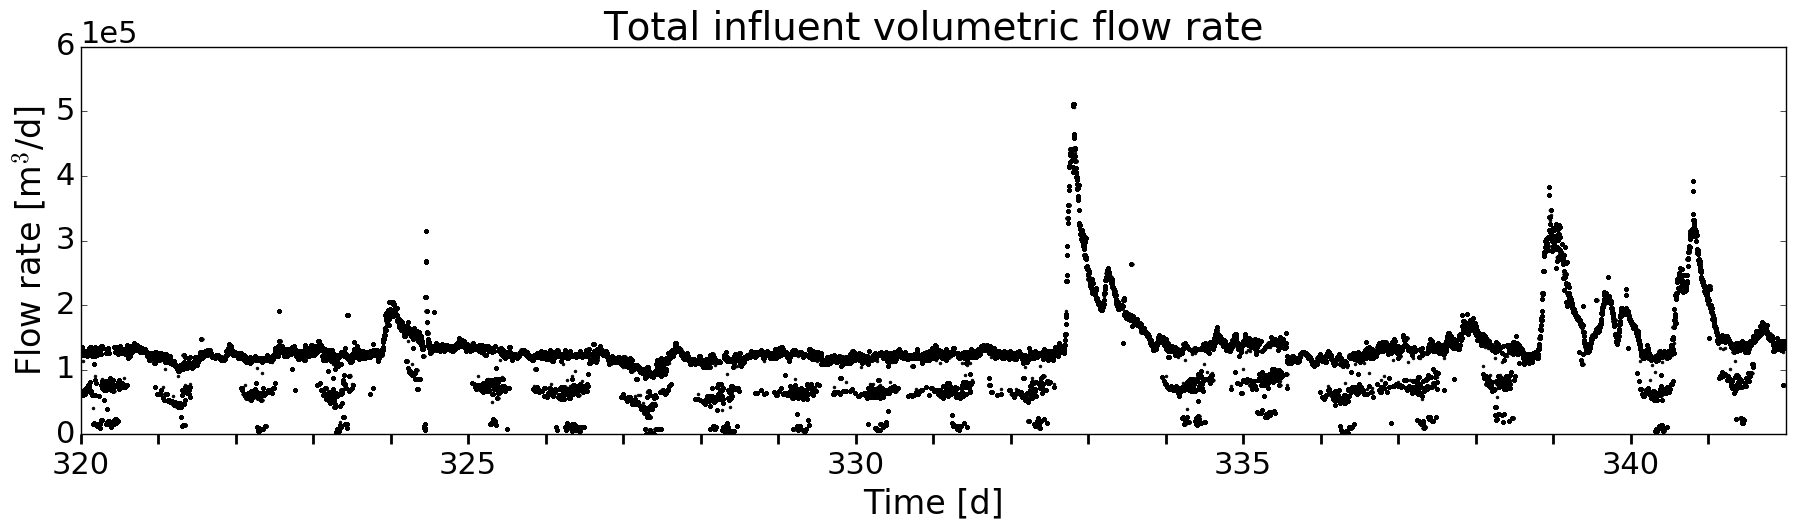

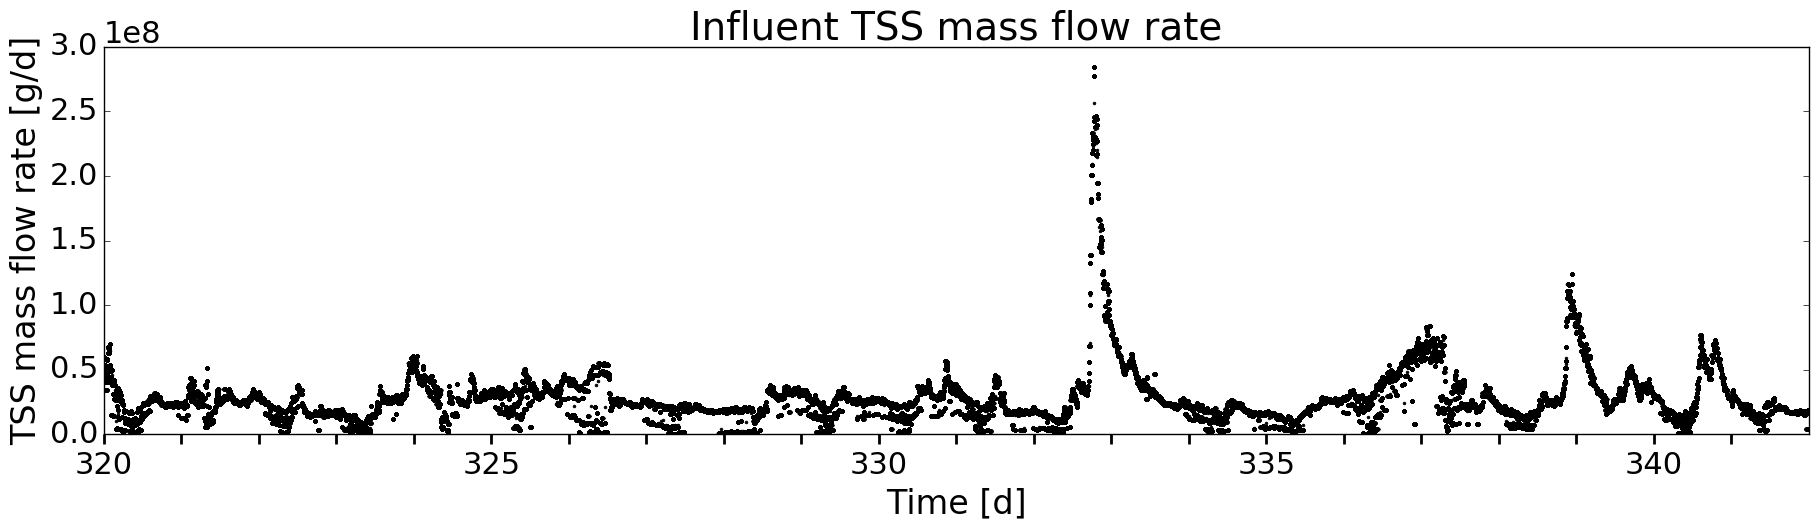

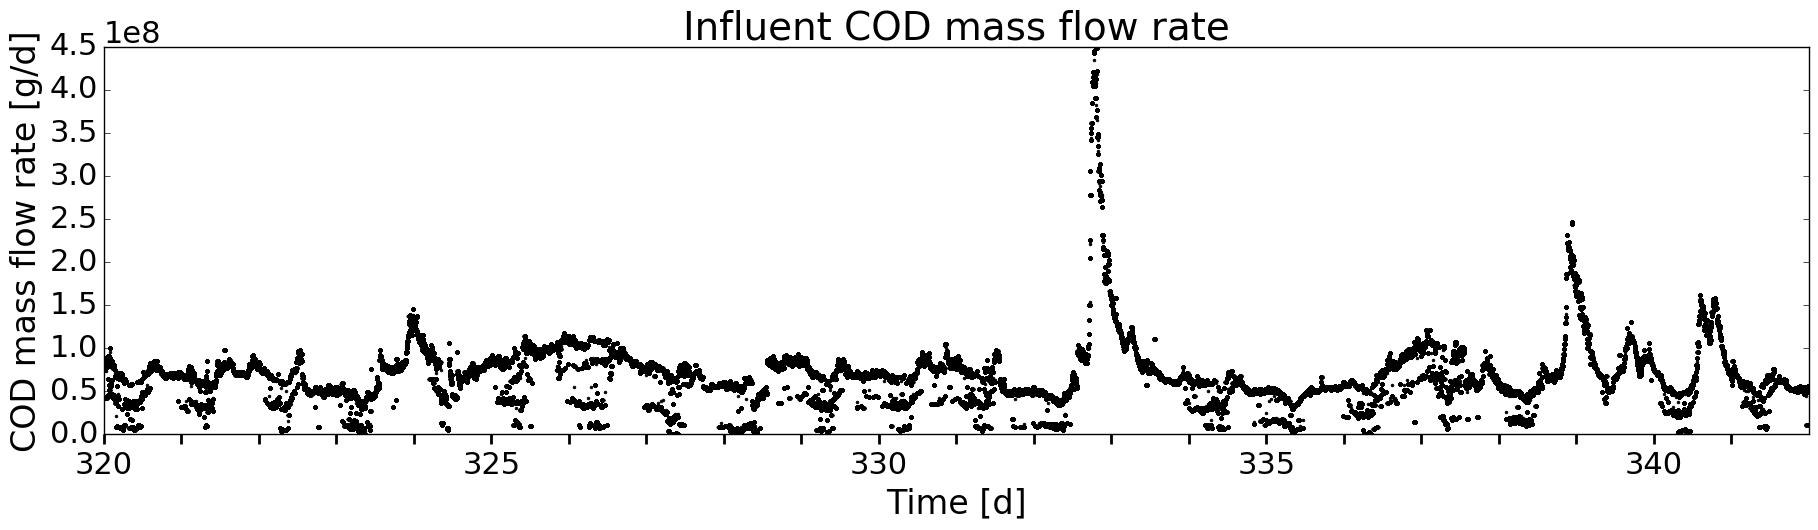

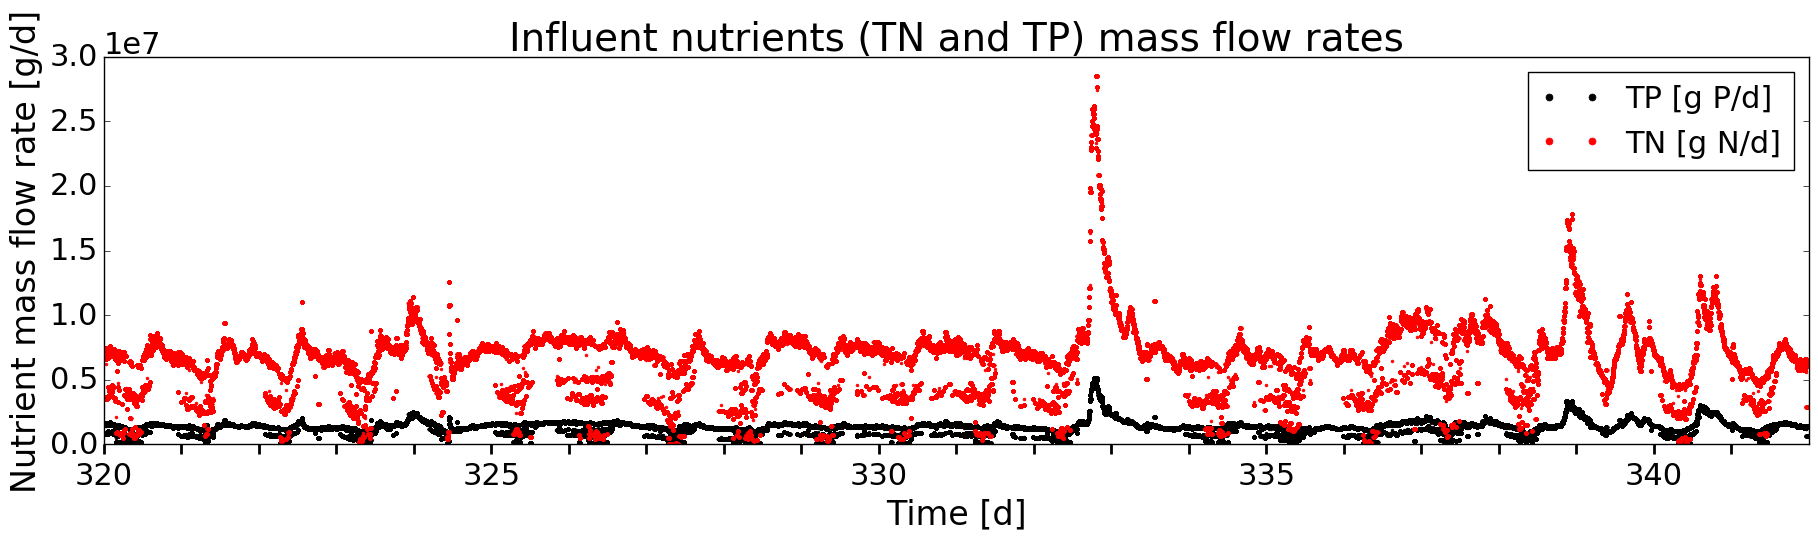

In [238]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10

##Influent flow rate
fig, ax = plt.subplots(figsize=(22,5));
#figsize=(w,h) in inches
_=ax.plot(data_influent['time'],data_influent['infl_q'],'k.',ms=4)
#'k.': markers are black point
#ms=10: marker size
_=ax.set_title('Total influent volumetric flow rate',fontsize=28)
_=ax.set_xlabel('Time [d]',fontsize=24)
_=ax.set_xlim(data_influent.loc[0,'time'],data_influent.loc[len(data_influent)-1,'time']);
_=ax.set_ylabel('Flow rate [m$^3$/d]',fontsize=24)
# ax.legend(loc=0,fontsize=14)
#Use scientiefic notation for number bigger than (10,3), i.e. 10^3
plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
#Probably used pylab for 1 of the modifications beneath
ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
ax.xaxis.set_minor_locator(minorLocator)
ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
if save_plots:
    plt.savefig('results/'+scenario_name+'_influent_flow_rate',bbox_inches='tight')

## Influent TSS mass flow rate
fig, ax = plt.subplots(figsize=(22,5));
#figsize=(w,h) in inches
_=ax.plot(data_influent['time'],data_influent['infl_X_TSS'].values,'k.',ms=4)
#'k.': markers are black point
#ms=10: marker size
_=ax.set_title('Influent TSS mass flow rate',fontsize=28)
_=ax.set_xlabel('Time [d]',fontsize=24)
_=ax.set_xlim(data_influent.loc[0,'time'],data_influent.loc[len(data_influent)-1,'time']);
_=ax.set_ylabel('TSS mass flow rate [g/d]',fontsize=24)
# ax.legend(loc=0,fontsize=14)
#Use scientiefic notation for number bigger than (10,3), i.e. 10^3
plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
#Probably used pylab for 1 of the modifications beneath
ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
ax.xaxis.set_minor_locator(minorLocator)
ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
if save_plots:
    plt.savefig('results/'+scenario_name+'_influent_TSS_mass_flow_rate',bbox_inches='tight')

## Influent COD mass flow rate
fig, ax = plt.subplots(figsize=(22,5));
#figsize=(w,h) in inches
_=ax.plot(data_influent['time'],data_influent['infl_q'].values*data_influent['infl_COD'].values,'k.',ms=4)
#'k.': markers are black point
#ms=10: marker size
_=ax.set_title('Influent COD mass flow rate',fontsize=28)
_=ax.set_xlabel('Time [d]',fontsize=24)
_=ax.set_xlim(data_influent.loc[0,'time'],data_influent.loc[len(data_influent)-1,'time']);
_=ax.set_ylabel('COD mass flow rate [g/d]',fontsize=24)
# ax.legend(loc=0,fontsize=14)
#Use scientiefic notation for number bigger than (10,3), i.e. 10^3
plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
#Probably used pylab for 1 of the modifications beneath
ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
ax.xaxis.set_minor_locator(minorLocator)
ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
if save_plots:
    plt.savefig('results/'+scenario_name+'_influent_COD_mass_flow_rate',bbox_inches='tight')

## Influent nutrients mass flow rates
fig, ax = plt.subplots(figsize=(22,5))
#figsize=(w,h) in inches
_=ax.plot(data_influent['time'],data_influent['infl_q'].values*data_influent['infl_TP'].values,'k.',ms=4,\
       label='TP [g P/d]')
_=ax.plot(data_influent['time'],data_influent['infl_q'].values*data_influent['infl_TN'].values,'r.',ms=4,\
       label='TN [g N/d]')
#'k.': markers are black point
#ms=10: marker size
_=ax.set_title('Influent nutrients (TN and TP) mass flow rates',fontsize=28)
_=ax.set_xlabel('Time [d]',fontsize=24)
_=ax.set_xlim(data_influent.loc[0,'time'],data_influent.loc[len(data_influent)-1,'time'])
_=ax.set_ylabel('Nutrient mass flow rate [g/d]',fontsize=24)
##Make legend markersize bigger for visibility
lgnd = plt.legend(loc=0,fontsize=22)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(10)
#Use scientiefic notation for number bigger than (10,3), i.e. 10^3
plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
#Probably used pylab for 1 of the modifications beneath
ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
ax.xaxis.set_minor_locator(minorLocator)
ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
if save_plots:
    plt.savefig('results/'+scenario_name+'_influent_nutrients_mass_flow_rate',bbox_inches='tight')


### Plotting of results for CO$_2$ emissions

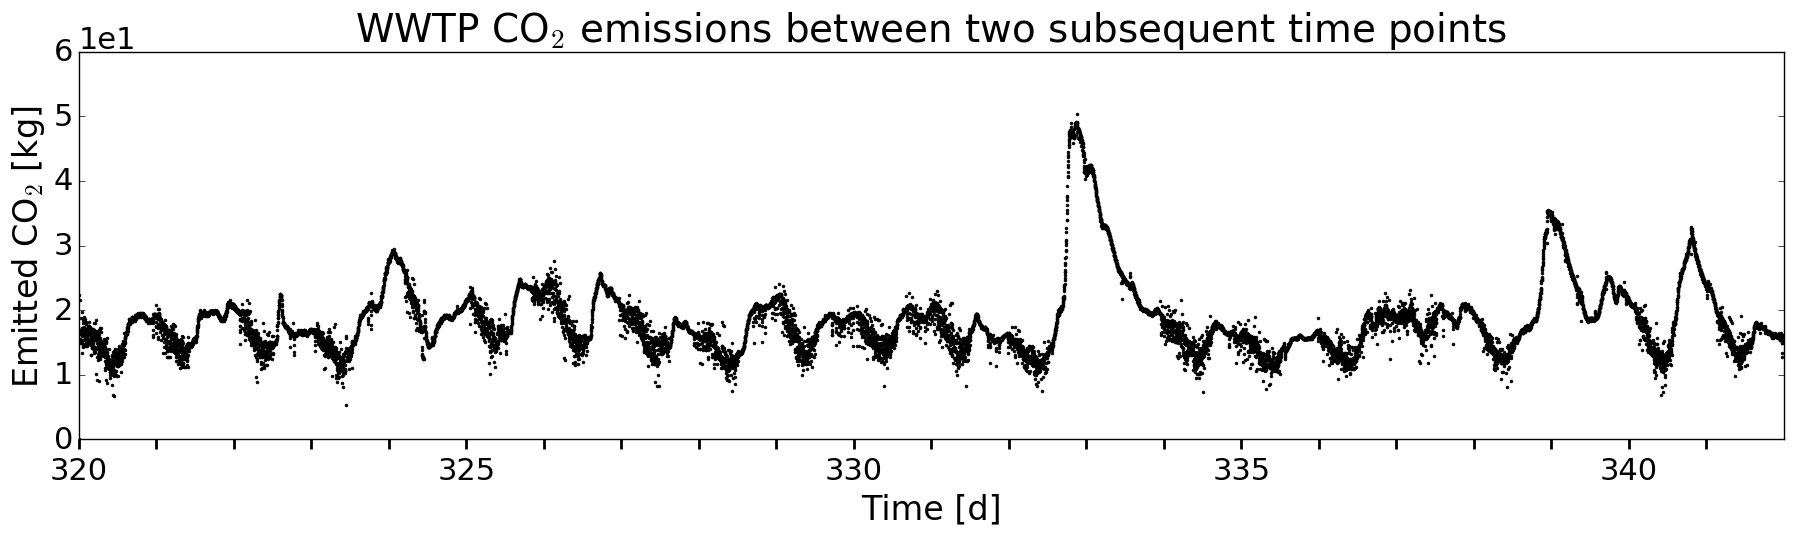

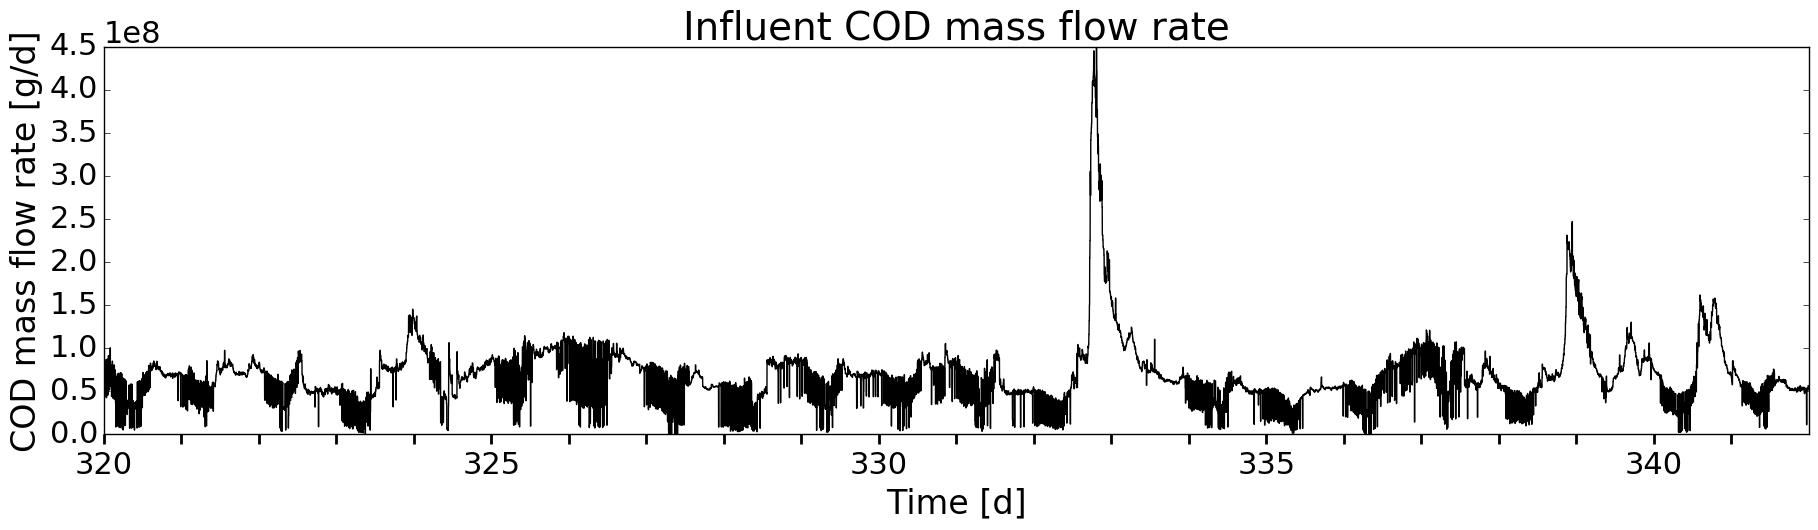

In [239]:
###figsize thesis
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
if time_intervals:
    ## Plot CO2 emissions
    fig, ax = plt.subplots(figsize=(22,5));
    #figsize=(w,h) in inches
    _=ax.plot(co2_emissions['time'],co2_emissions['co2_emission'],'k.',ms=4)
    #'k.': markers are black point
    #ms=10: marker size
    _=ax.set_title('WWTP CO$_2$ emissions between two subsequent time points',fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
    _=ax.set_xlabel('Time [d]',fontsize=24)
    _=ax.set_xlim(co2_emissions.loc[0,'time'],co2_emissions.loc[len(co2_emissions)-1,'time']);
    _=ax.set_ylabel('Emitted CO$_2$ [kg]',fontsize=24)
    # ax.legend(loc=0,fontsize=14)
    #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    #Probably used pylab for 1 of the modifications beneath
    ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    plt.savefig('CO2_emissions')
    if save_plots:
        plt.savefig('results/'+scenario_name+'_CO2_emissions',bbox_inches='tight')

    ## Influent COD mass flow rate
    ##Note: used line instead of markers to better visualize the dynamic behaviour of the influent during dry weather conditions
    fig, ax = plt.subplots(figsize=(22,5));
    #figsize=(w,h) in inches
    _=ax.plot(data_influent['time'],data_influent['infl_q'].values*data_influent['infl_COD'].values,'k-',ms=4)
    #'k.': markers are black point
    #ms=10: marker size
    _=ax.set_title('Influent COD mass flow rate',fontsize=28)
    _=ax.set_xlabel('Time [d]',fontsize=24)
    _=ax.set_xlim(data_influent.loc[0,'time'],data_influent.loc[len(data_influent)-1,'time']);
    _=ax.set_ylabel('COD mass flow rate [g/d]',fontsize=24)
    # ax.legend(loc=0,fontsize=14)
    #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    #Probably used pylab for 1 of the modifications beneath
    ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger

### Plotting of non-CO$_2$ direct WWTP emissions

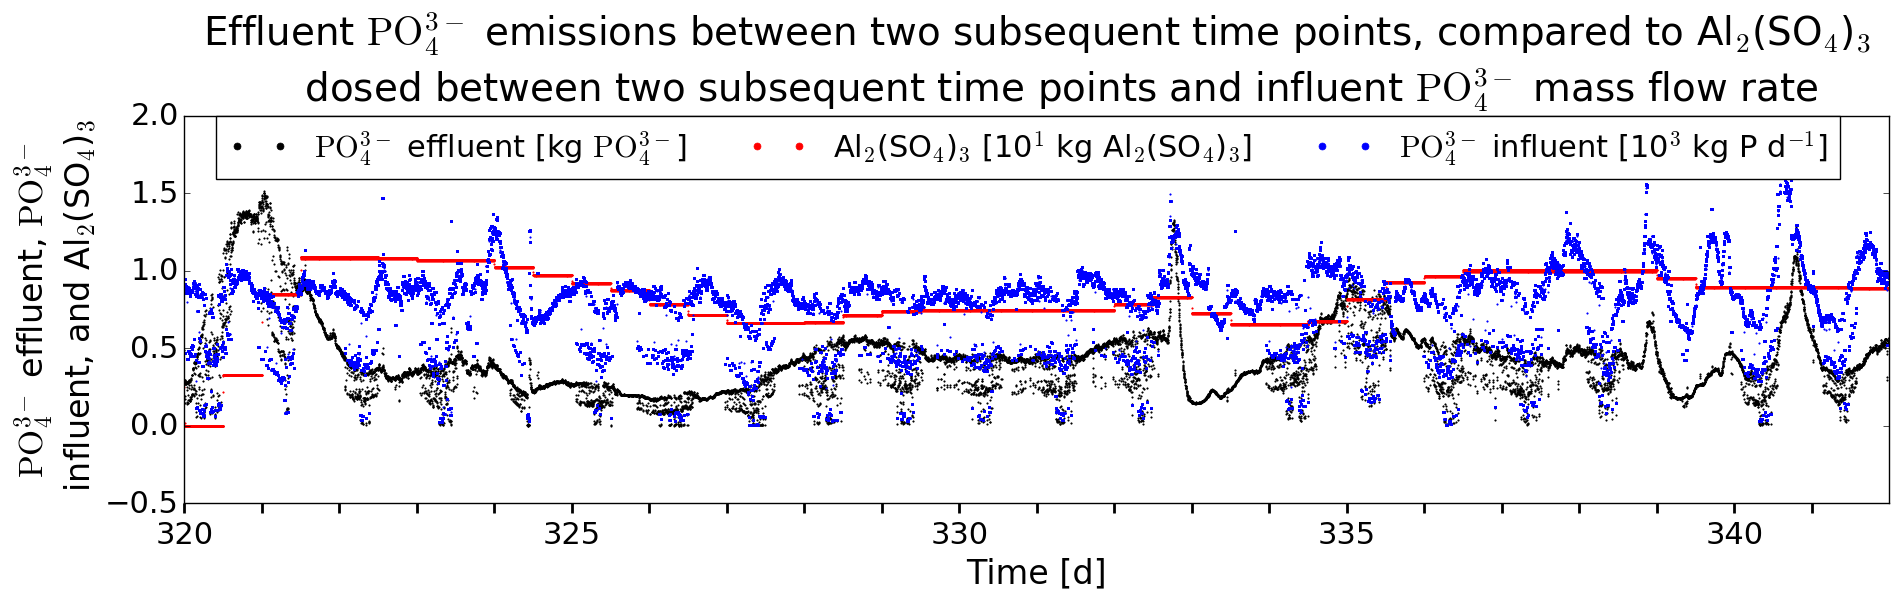

In [240]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)

if time_intervals:
    ## Effluent phosphate emissions compared to influent phosphate mass flow rate and dosing of aluminium sulphate
    fig, ax = plt.subplots(figsize=(22,5))
    #figsize=(w,h) in inches
    _=ax.plot(relevant_effluent_data['time'],relevant_effluent_data['po4'],'k.',ms=2,\
           label='$\mathrm{PO}_{4}^{3-}$ effluent [kg $\mathrm{PO}_{4}^{3-}$]')
    _=ax.plot(al_data['time'],al_data['alum_sulf'].values/10,'r.',ms=2,\
           label='Al$_{2}$(SO$_{4}$)$_{3}$ [10$^1$ kg Al$_{2}$(SO$_{4}$)$_{3}$]')
    _=ax.plot(data_influent['time'],data_influent['infl_S_PO'].values/1e6,'b.',ms=2,\
           label='$\mathrm{PO}_{4}^{3-}$ influent [10$^3$ kg P d$^{-1}$]')
    #'k.': markers are black point
    #ms=10: marker size
    _=ax.set_title('Effluent $\mathrm{PO}_{4}^{3-}$ emissions between two subsequent time points, compared to Al$_{2}$(SO$_{4}$)$_{3}$\n\
    dosed between two subsequent time points and influent $\mathrm{PO}_{4}^{3-}$ mass flow rate' ,fontsize=28,y=1.02)
    #y=1.01 moves title up (readability of subscript)
    _=ax.set_xlabel('Time [d]',fontsize=24)
    _=ax.set_xlim(relevant_effluent_data.loc[0,'time'],relevant_effluent_data.loc[len(relevant_effluent_data)-1,'time'])
    _=ax.set_ylabel('$\mathrm{PO}_{4}^{3-}$ effluent, $\mathrm{PO}_{4}^{3-}$\n influent, and Al$_{2}$(SO$_{4}$)$_{3}$',fontsize=24)
    ##Make legend markersize bigger for visibility
    lgnd = plt.legend(fontsize=22,ncol=3,bbox_to_anchor=(0.98, 1.04))
    for i in range(len(lgnd.legendHandles)):
        lgnd.legendHandles[i]._legmarker.set_markersize(10)
    #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    #Probably used pylab for 1 of the modifications beneath
    ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    if save_plots:
        plt.savefig('results/'+scenario_name+'_PO4_influentAndEffluent_alumDosing',bbox_inches='tight')

In [241]:
units_relevant_data_effluent
relevant_effluent_data.head()

time     po4 non_po4_p     no3 non_no3_n      acetic_acid     h2o
0    d  kg PO4      kg P  kg NO3      kg N  kg actetic acid  kg H2O

time       po4  non_po4_p       no3  non_no3_n  acetic_acid  \
0  320.00000  0.000000   0.000000  0.000000   0.000000     0.000000   
1  320.00139  0.488126   0.011715  5.259562   0.932038     0.009562   
2  320.00278  0.296157   0.001013  3.309103   0.571380     0.005984   
3  320.00417  0.279741   0.000482  3.141858   0.542259     0.005595   
4  320.00556  0.271232   0.000385  3.043813   0.524404     0.005314   

             h2o  
0       0.000000  
1  276596.602651  
2  174474.955945  
3  165817.206702  
4  160555.778102

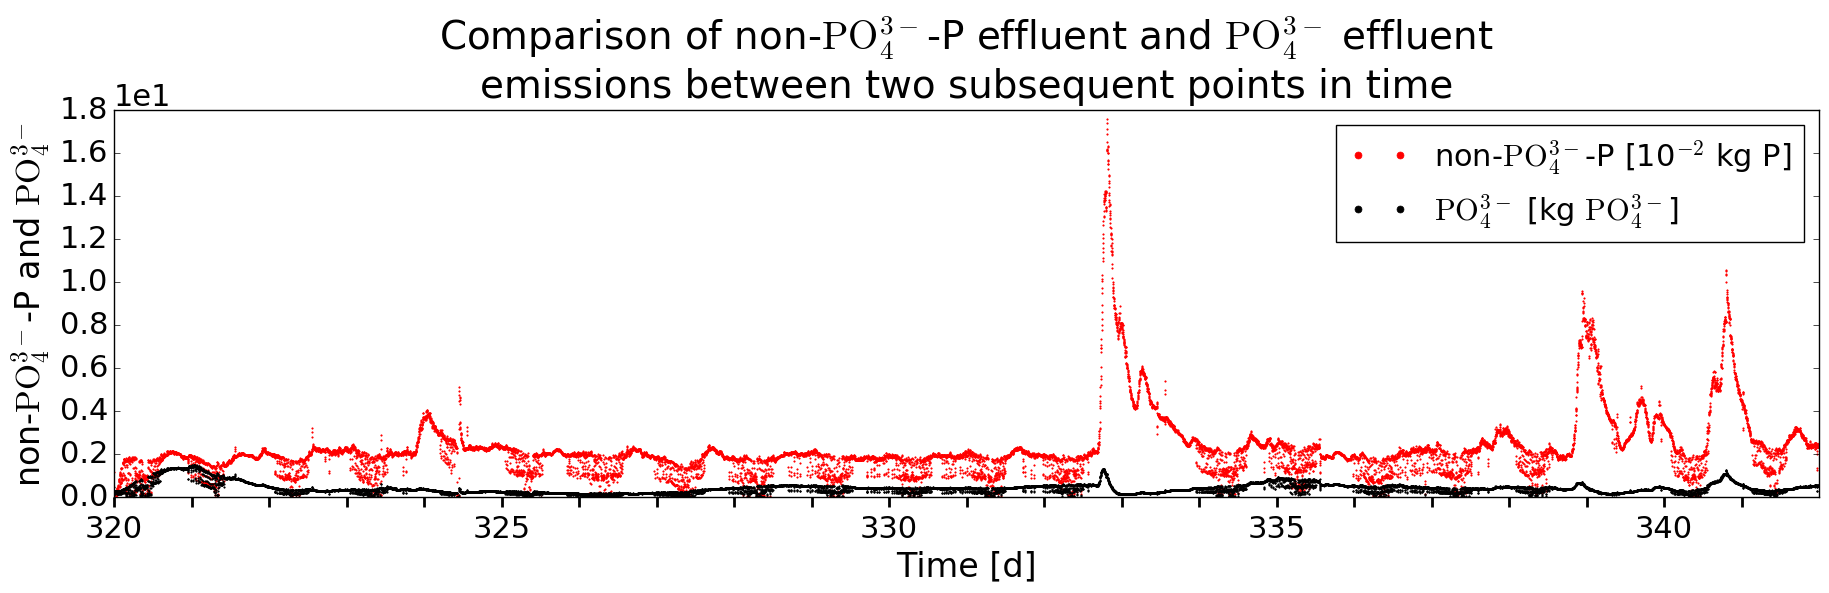

In [242]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)

if time_intervals:
    ## Comparison of non-PO4-P and PO4 effluent emissions
    fig, ax = plt.subplots(figsize=(22,5))
    #figsize=(w,h) in inches
    # _=ax.plot(data['time'],data['infl_TP'].values*data['infl_q'].values/1e9,'k.',ms=2,\
    #        label='$\mathrm{PO}_{4}^{3-}$ effluent [kg $\mathrm{PO}_{4}^{3-}$]')
    _=ax.plot(relevant_effluent_data['time'],relevant_effluent_data['non_po4_p'].values*10**2,'r.',ms=2,\
           label='non-$\mathrm{PO}_{4}^{3-}$-P [10$^{-2}$ kg P]')
    _=ax.plot(relevant_effluent_data['time'],relevant_effluent_data['po4'],'k.',ms=2,\
           label='$\mathrm{PO}_{4}^{3-}$ [kg $\mathrm{PO}_{4}^{3-}$]')
    #'k.': markers are black point
    #ms=10: marker size
    _=ax.set_title('Comparison of non-$\mathrm{PO}_{4}^{3-}$-P effluent and $\mathrm{PO}_{4}^{3-}$ effluent\nemissions between two subsequent points in time' ,fontsize=28,y=1.02)#y=1.01 moves title up (readability of subscript)
    _=ax.set_xlabel('Time [d]',fontsize=24)
    _=ax.set_xlim(relevant_effluent_data.loc[0,'time'],relevant_effluent_data.loc[len(relevant_effluent_data)-1,'time'])
    _=ax.set_ylabel('non-$\mathrm{PO}_{4}^{3-}$-P and $\mathrm{PO}_{4}^{3-}$',fontsize=24)
    ##Make legend markersize bigger for visibility
    lgnd = plt.legend(loc=0,fontsize=22)
    for i in range(len(lgnd.legendHandles)):
        lgnd.legendHandles[i]._legmarker.set_markersize(10)
    #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    #Probably used pylab for 1 of the modifications beneath
    ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    if save_plots:
        plt.savefig('results/'+scenario_name+'_effluent_nonPO4_PAndPO4_comparison',bbox_inches='tight')


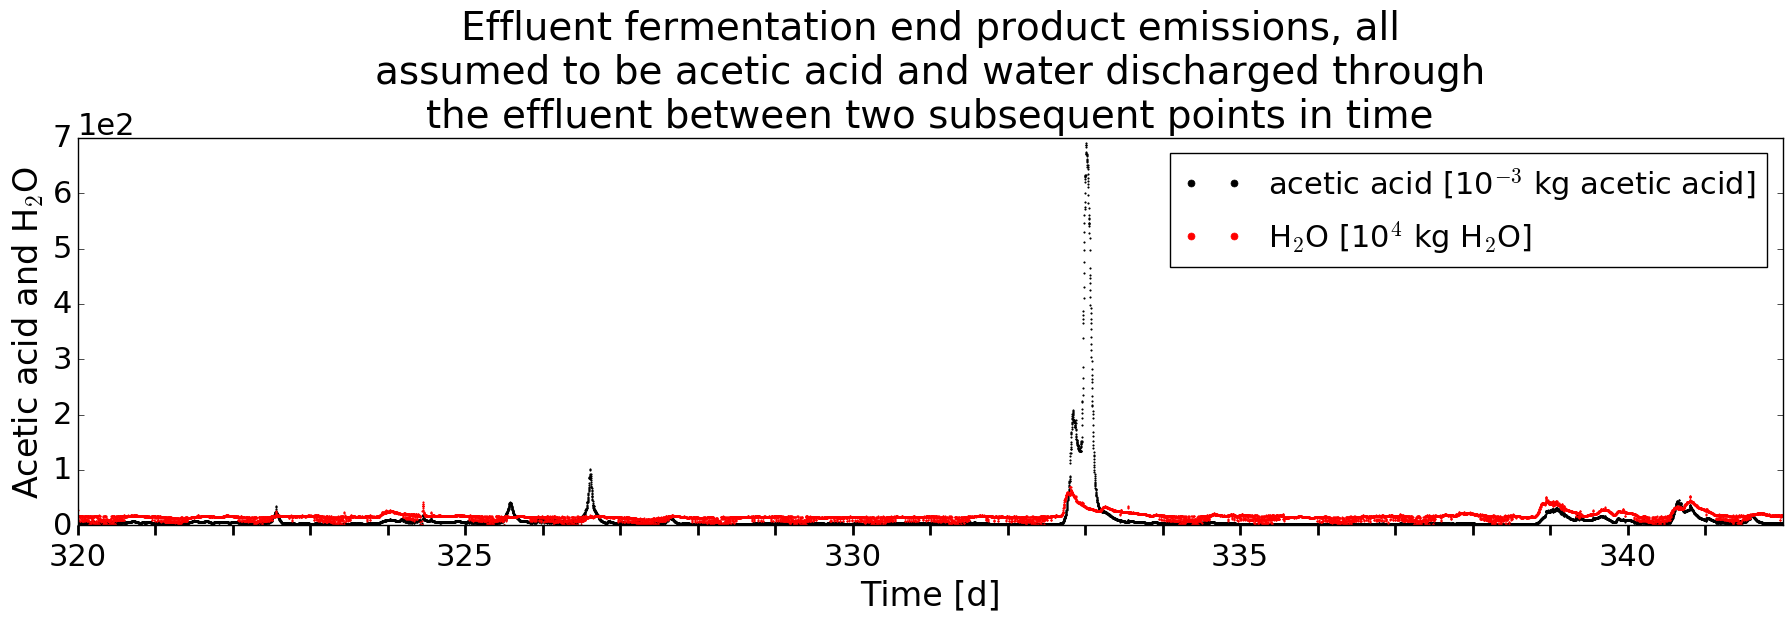

In [243]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)

if time_intervals:
    ## Discharge of effluent water and effluent fermentation end products
    fig, ax = plt.subplots(figsize=(22,5))
    #figsize=(w,h) in inches
    # _=ax.plot(data['time'],data['infl_TP'].values*data['infl_q'].values/1e9,'k.',ms=2,\
    #        label='$\mathrm{PO}_{4}^{3-}$ effluent [kg $\mathrm{PO}_{4}^{3-}$]')
    _=ax.plot(relevant_effluent_data['time'],relevant_effluent_data['acetic_acid'].values*10**3,'k.',ms=2,\
           label='acetic acid [10$^{-3}$ kg acetic acid]')
    _=ax.plot(relevant_effluent_data['time'],relevant_effluent_data['h2o'].values/10**4,'r.',ms=2,\
           label='H$_2$O [10$^{4}$ kg H$_2$O]')
    #'k.': markers are black point
    #ms=10: marker size
    _=ax.set_title('Effluent fermentation end product emissions, all\nassumed to be acetic acid and water discharged through\nthe effluent between two subsequent points in time' ,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
    _=ax.set_xlabel('Time [d]',fontsize=24)
    _=ax.set_xlim(relevant_effluent_data.loc[0,'time'],relevant_effluent_data.loc[len(relevant_effluent_data)-1,'time'])
    _=ax.set_ylabel('Acetic acid and H$_2$O',fontsize=24)
    ##Make legend markersize bigger for visibility
    lgnd = plt.legend(loc=0,fontsize=22)
    for i in range(len(lgnd.legendHandles)):
        lgnd.legendHandles[i]._legmarker.set_markersize(10)
    #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    #Probably used pylab for 1 of the modifications beneath
    ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    if save_plots:
        plt.savefig('results/'+scenario_name+'_effluent_water_fermentationEndProducts',bbox_inches='tight')

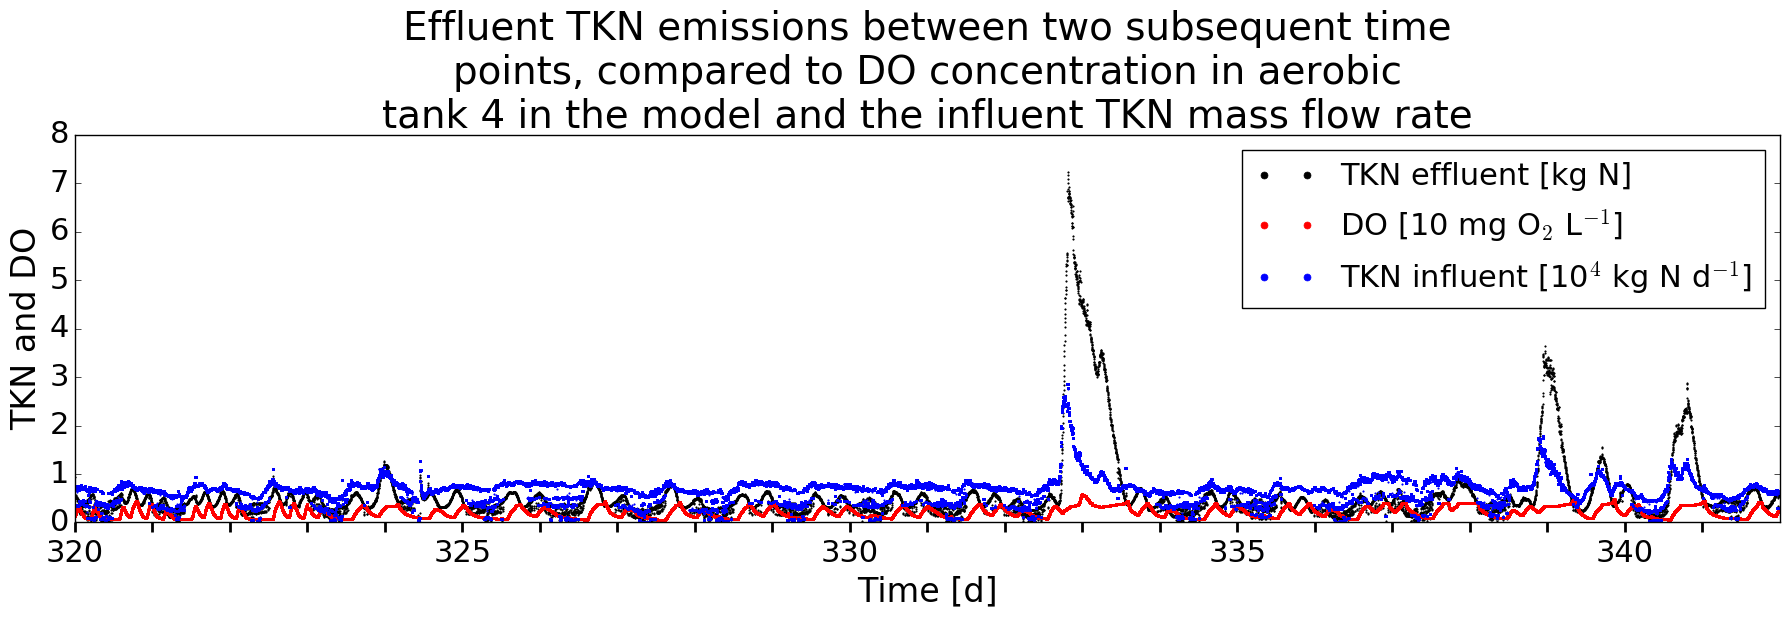

In [244]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)

if time_intervals:
    ## Effluent TKN-N compared to influent TKN mass flow rate and DO in aerobic tank 4
    fig, ax = plt.subplots(figsize=(22,5))
    #figsize=(w,h) in inches
    _=ax.plot(relevant_effluent_data['time'],relevant_effluent_data['non_no3_n'],'k.',ms=2,\
           label='TKN effluent [kg N]')
    _=ax.plot(data['time'],data['controller_nh4_do'].values/10,'r.',ms=2,\
           label='DO [10 mg O$_2$ L$^{-1}$]')
    _=ax.plot(data['time'],data['infl_TKN'].values*data['infl_q'].values/1e7,'b.',ms=2,\
           label='TKN influent [10$^{4}$ kg N d$^{-1}$]')
    #'k.': markers are black point
    #ms=10: marker size
    _=ax.set_title('Effluent TKN emissions between two subsequent time\npoints, compared to DO concentration in aerobic\ntank 4 in the model and the influent TKN mass flow rate' ,fontsize=28)
    _=ax.set_xlabel('Time [d]',fontsize=24)
    _=ax.set_xlim(relevant_effluent_data.loc[0,'time'],relevant_effluent_data.loc[len(relevant_effluent_data)-1,'time'])
    _=ax.set_ylabel('TKN and DO',fontsize=24)
    ##Make legend markersize bigger for visibility
#     lgnd = plt.legend(bbox_to_anchor=(0.9, 1.05),fontsize=22,frameon=False,ncol=3)
    lgnd = plt.legend(loc=0,fontsize=22,frameon=True)
    for i in range(len(lgnd.legendHandles)):
        lgnd.legendHandles[i]._legmarker.set_markersize(10)
    #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    #Probably used pylab for 1 of the modifications beneath
    ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    if save_plots:
        plt.savefig('results/'+scenario_name+'_TKN_influentAndEffluent_DO',bbox_inches='tight')

In [245]:
data.head()

time  controller_nh4_do   precip_q  precip_S_PO_in  precip_S_PO_out  \
0  320.00000           1.223312  221053.64       903341.91        200870.83   
1  320.00002           1.225822  221593.95       903563.39        212932.90   
2  320.00005           1.228322  222111.28       903775.46        225102.97   
3  320.00007           1.230821  222623.47       903985.44        237287.02   
4  320.00009           1.233295  223086.45       904175.27        249605.33   

   energy_aeration  energy_mixing  energy_pumping  dosing_alum   effl_S_A  \
0       76829583.0      1748836.9    2.275014e+09    831169.08  12881.686   
1       76829567.0      1748836.9    2.275014e+09    794131.54  12507.912   
2       76829552.0      1748836.9    2.275014e+09    758669.73  12150.158   
3       76829536.0      1748836.9    2.275014e+09    723559.37  11795.974   
4       76829521.0      1748836.9    2.275014e+09    691823.21  11476.072   

   effl_S_NH  effl_S_NO  effl_S_PO  effl_X_I_i  effl_X_TSS   effl_COD  \
0  580717.63  1501353.3  165231.97   564415.43   2947385.7  56.530121   
1  564100.64  1457877.1  160463.17   508288.30   2654289.0  55.904863   
2  548181.49  1416258.5  155897.14   458826.48   2395998.7  55.339978   
3  532418.36  1375053.5  151376.30   410597.09   2144144.1  54.786702   
4  518153.21  1337819.5  147289.39   374200.02   1954078.0  54.344884   

      effl_q  effl_TKN   effl_TN   effl_TP  infl_S_NH  infl_S_NO  infl_S_PO  \
0  348861.04  3.584214  7.887800  0.593349  4904857.1        0.0  913788.59   
1  338799.82  3.559829  7.862882  0.584654  4904857.1        0.0  913788.59   
2  329165.98  3.537816  7.840365  0.576798  4904857.1        0.0  913788.59   
3  319627.42  3.516260  7.818309  0.569104  4904857.1        0.0  913788.59   
4  311003.65  3.499085  7.800685  0.562958  4904857.1        0.0  913788.59   

   infl_X_TSS   infl_COD     infl_q   infl_TKN    infl_TN    infl_TP  \
0  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   
1  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   
2  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   
3  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   
4  59546166.0  683.91765  130541.23  55.468709  55.468709  12.634727   

   biology_q  biology_TKN  waste_X_I_i  waste_q  waste_TSS  aer1_COD_in  \
0  123341.23    40.452307          0.0      0.0        0.0    3402.2371   
1  123341.23    50.709788          0.0      0.0        0.0    3402.2316   
2  123341.23    50.709788          0.0      0.0        0.0    3402.2262   
3  123341.23    50.709788          0.0      0.0        0.0    3402.2207   
4  123341.23    50.709788          0.0      0.0        0.0    3402.2150   

      aer1_q  aer1_COD_out  aer2_COD_out  aer3_COD_out  aer4_COD_out  \
0  6729093.8     3402.0822     3402.0057     3401.8970     3401.6776   
1  6719044.9     3402.0820     3402.0055     3401.8968     3401.6774   
2  6709424.1     3402.0817     3402.0052     3401.8965     3401.6772   
3  6699898.8     3402.0814     3402.0050     3401.8963     3401.6769   
4  6691290.2     3402.0809     3402.0048     3401.8961     3401.6767   

   aer5_COD_out  aer6_COD_in     aer6_q  aer6_COD_out  ana1_COD_in     ana1_q  \
0     3401.6442    3401.6442  6022687.8     3401.5459    1619.7069  221053.64   
1     3401.6440    3401.6440  6012626.6     3401.5458    1788.5242  221593.95   
2     3401.6438    3401.6438  6002992.8     3401.5457    1792.3036  222111.28   
3     3401.6436    3401.6436  5993454.2     3401.5456    1796.0422  222623.47   
4     3401.6434    3401.6434  5984830.4     3401.5455    1799.3888  223086.45   

   ana1_COD_out  ana2_COD_out  ana3_COD_out  ana4_COD_out  ano1_COD_in  \
0     1887.3975     1887.0448     1886.8806     1886.7275    3401.8344   
1     1887.2086     1887.0446     1886.8807     1886.7275    3397.9078   
2     1887.0292     1887.0440     1886.8807     1886.7276    3394.1379   
3     1886.8513     1887.0434     1886.8807     1886.727

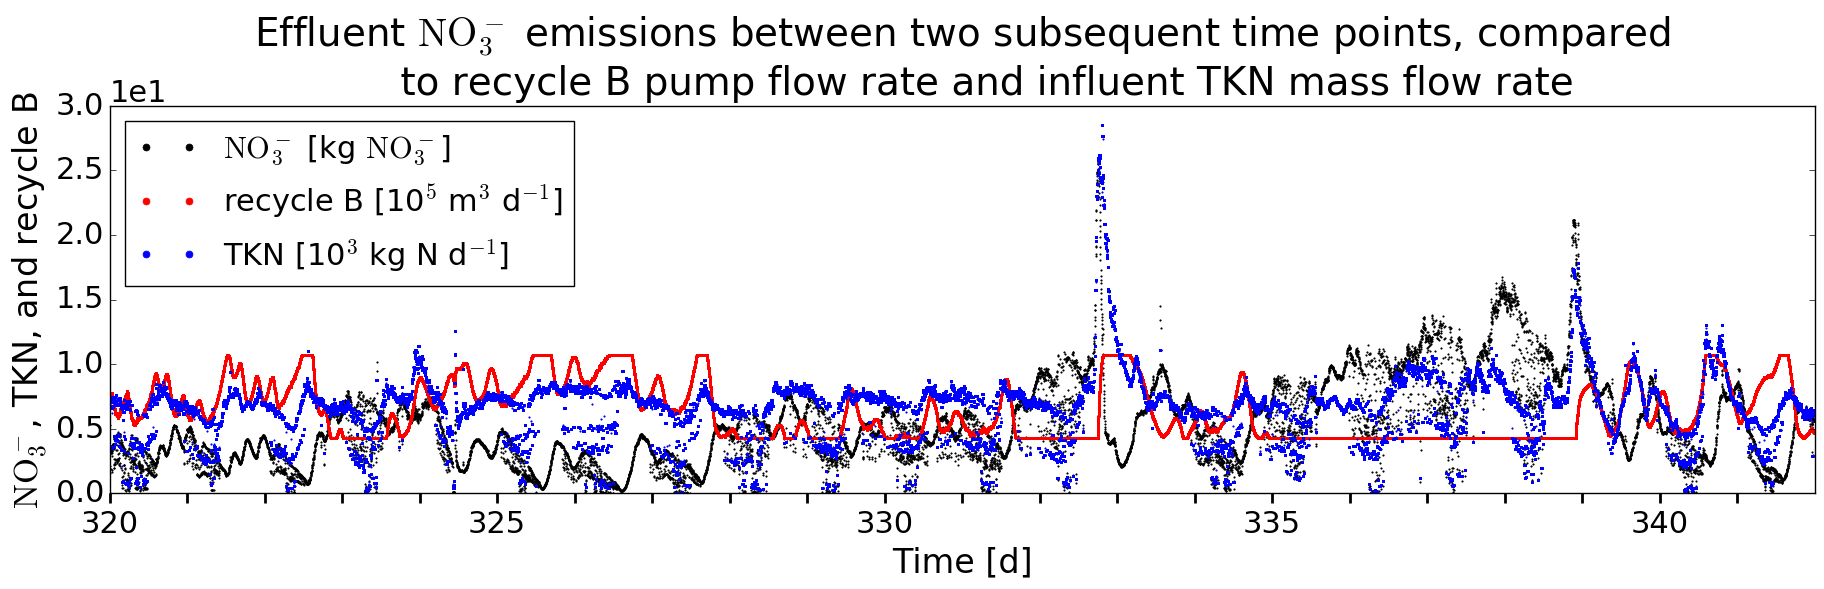

In [246]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)

if time_intervals:
    ## Effluent nitrate compared to influent TKN mass flow rate and volumetric flow rate of recycle B pump
    fig, ax = plt.subplots(figsize=(22,5))
    #figsize=(w,h) in inches
    _=ax.plot(relevant_effluent_data['time'],relevant_effluent_data['no3'],'k.',ms=2,\
           label='$\mathrm{NO}_3^-$ [kg $\mathrm{NO}_3^-$]')
    _=ax.plot(data['time'],data['recB_pump_flowRate'].values/10**5,'r.',ms=2,\
           label='recycle B [10$^5$ m$^3$ d$^{-1}$]')
    _=ax.plot(data['time'],data['infl_TKN'].values*data['infl_q'].values/1e6,'b.',ms=2,\
           label='TKN [10$^{3}$ kg N d$^{-1}$]')
    #'k.': markers are black point
    #ms=10: marker size
    _=ax.set_title('Effluent $\mathrm{NO}_3^-$ emissions between two subsequent time points, compared\n\
    to recycle B pump flow rate and influent TKN mass flow rate' ,fontsize=28,y=1.02)#y=1.01 moves title up (readability of subscript)
    _=ax.set_xlabel('Time [d]',fontsize=24)
    _=ax.set_xlim(relevant_effluent_data.loc[0,'time'],relevant_effluent_data.loc[len(relevant_effluent_data)-1,'time'])
    _=ax.set_ylabel('$\mathrm{NO}_3^-$, TKN, and recycle B' ,fontsize=24)
    ##Make legend markersize bigger for visibility
#     lgnd = plt.legend(bbox_to_anchor=(0.9, 1.05),fontsize=22,frameon=False,ncol=3)
    lgnd = plt.legend(loc=0,fontsize=22,frameon=True)
    for i in range(len(lgnd.legendHandles)):
        lgnd.legendHandles[i]._legmarker.set_markersize(10)
    #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    #Probably used pylab for 1 of the modifications beneath
    ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    if save_plots:
        plt.savefig('results/'+scenario_name+'_NO3effluent_TKNinfluent_recBflowRate',bbox_inches='tight')

In [247]:
# units
# data_influent.head()
units_relevant_data_effluent
relevant_effluent_data.head()
# data_influent.head()
# units
# data.head()

time     po4 non_po4_p     no3 non_no3_n      acetic_acid     h2o
0    d  kg PO4      kg P  kg NO3      kg N  kg actetic acid  kg H2O

time       po4  non_po4_p       no3  non_no3_n  acetic_acid  \
0  320.00000  0.000000   0.000000  0.000000   0.000000     0.000000   
1  320.00139  0.488126   0.011715  5.259562   0.932038     0.009562   
2  320.00278  0.296157   0.001013  3.309103   0.571380     0.005984   
3  320.00417  0.279741   0.000482  3.141858   0.542259     0.005595   
4  320.00556  0.271232   0.000385  3.043813   0.524404     0.005314   

             h2o  
0       0.000000  
1  276596.602651  
2  174474.955945  
3  165817.206702  
4  160555.778102

### Plot LCIA results for sludge treatment
Visual check of plausibility of results: Produced waste sludge mass should be more or less proportional to effluent TSS mass flow rate, since for every subsequent time interval - all equal in length - the former is the integral of the latter. All LCIA results should be proportional to the produced waste sludge masses, since the latter is converted into the former using only linear scalings. These plots will however be commented out, because the check was performed and everything seemed alright. The plot of the sludge produced in the considered time intervals will not be commented out, because it is relevant to interpret the LCA results. <br>

In [248]:
np.sum(data_sludge['waste_q']<0)

0

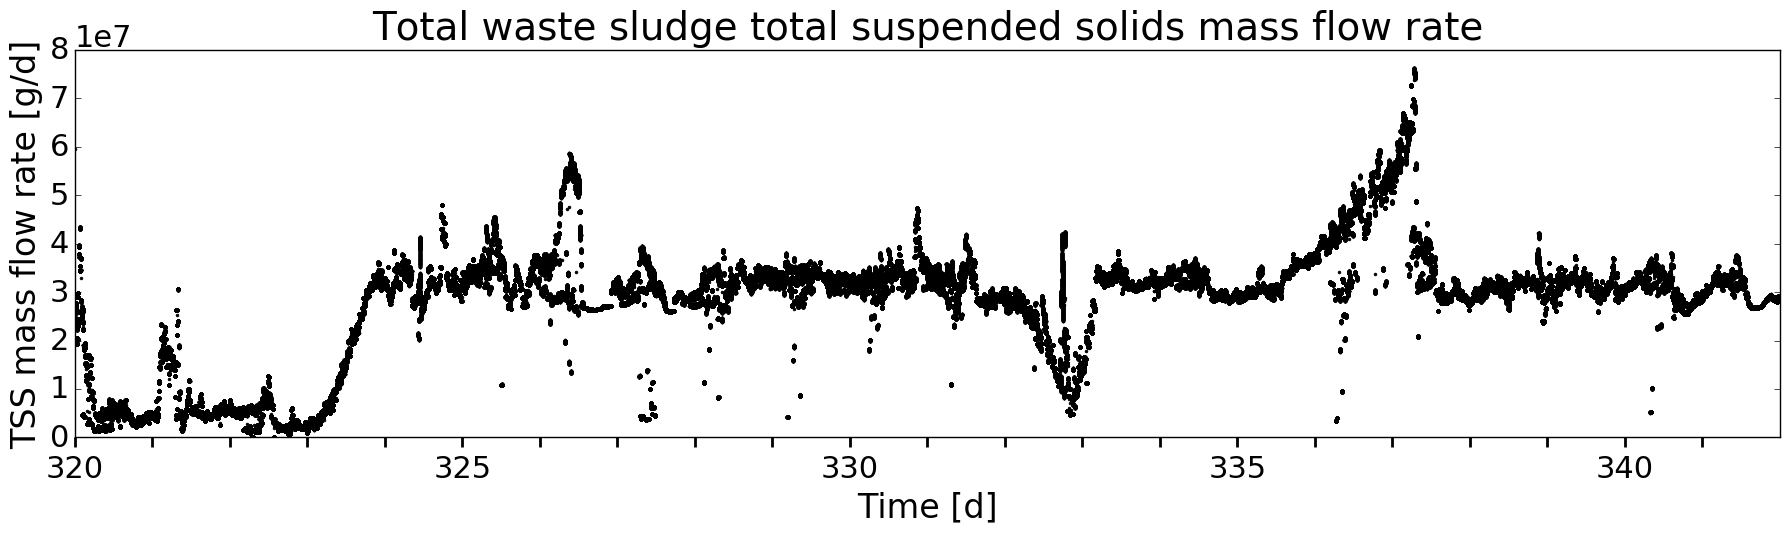

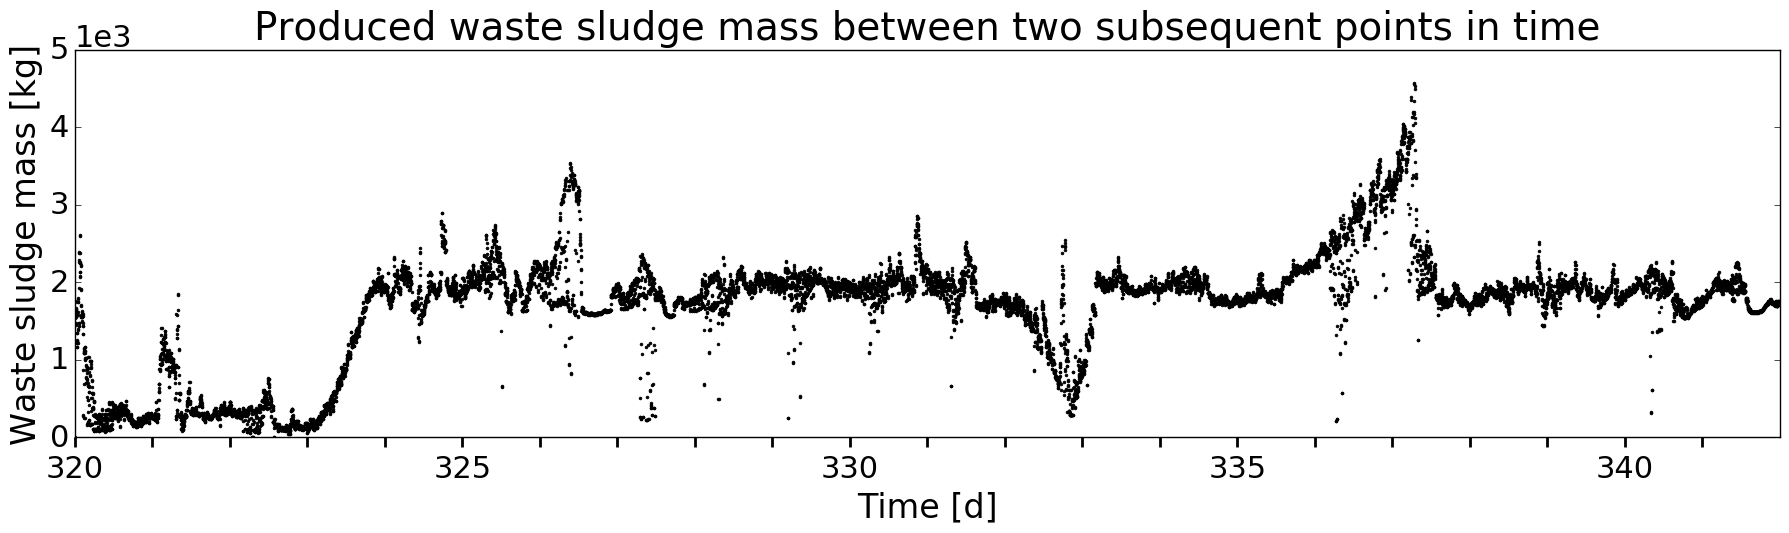

In [249]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
if time_intervals:
    ## Plot TSS mass flow rate in sludge discharge for visual control
    fig, ax = plt.subplots(figsize=(22,5));
    #figsize=(w,h) in inches
    _=ax.plot(data_sludge['time'],data_sludge['waste_q'].values*data_sludge['waste_TSS'].values+data['waste_TSS2'].values*\
data['waste_q2'].values,'k.',ms=4)
    #'k.': markers are black point
    #ms=10: marker size
    _=ax.set_title('Total waste sludge total suspended solids mass flow rate',fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
    _=ax.set_xlabel('Time [d]',fontsize=24)
    _=ax.set_xlim(data_sludge.loc[0,'time'],data_sludge.loc[len(data_sludge)-1,'time']);
    _=ax.set_ylabel('TSS mass flow rate [g/d]',fontsize=24)
    # ax.legend(loc=0,fontsize=14)
    #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    #Probably used pylab for 1 of the modifications beneath
    ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger

    ## Plot produced waste sludge mass that has to be treated for visual control
    fig, ax = plt.subplots(figsize=(22,5));
    #figsize=(w,h) in inches
    _=ax.plot(sludge_mass['time'],sludge_mass['waste_sludge'],'k.',ms=4)
    #'k.': markers are black point
    #ms=10: marker size
    _=ax.set_title('Produced waste sludge mass between two subsequent points in time',fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
    _=ax.set_xlabel('Time [d]',fontsize=24)
    _=ax.set_xlim(sludge_mass.loc[0,'time'],sludge_mass.loc[len(sludge_mass)-1,'time']);
    _=ax.set_ylabel('Waste sludge mass [kg]',fontsize=24)
    # ax.legend(loc=0,fontsize=14)
    #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    #Probably used pylab for 1 of the modifications beneath
    ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    if save_plots:
        plt.savefig('results/'+scenario_name+'_waste_sludge_mass',bbox_inches='tight')

    # ## Plot some sludge treatment LCIA midpoint results
    # fig, ax = plt.subplots(figsize=(22,5));
    # #figsize=(w,h) in inches
    # _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint['CC'],'k.',ms=2)
    # #'k.': markers are black point
    # #ms=10: marker size
    # _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint['FD'],'.',ms=2)
    # _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint['HT'],'.',ms=2)
    # _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint['IR'],'.',ms=2)
    # _=ax.set_title('Some sludge treatment LCIA midpoint results',fontsize=20)
    # _=ax.set_xlabel('Time [d]',fontsize=16)
    # _=ax.set_xlim(sludge_treatment_midpoint.loc[0,'time'],sludge_treatment_midpoint.loc[len(sludge_\
    # treatment_midpoint)-1,'time']);
    # _=ax.set_ylabel('Impact category result\n[various units]',fontsize=16)
    # _=ax.legend(loc=0,fontsize=14)
    # # ax.legend(loc=0,fontsize=14)
    # #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    # #Probably used pylab for 1 of the modifications beneath
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    # minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    # ax.xaxis.set_minor_locator(minorLocator)
    # ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    # ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    # ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    # ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    # ax.yaxis.offsetText.set_fontsize(14)#Size of scientific notation
    # ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger

    # ## Plot some sludge treatment LCIA midpoint results
    # fig, ax = plt.subplots(figsize=(22,5));
    # #figsize=(w,h) in inches
    # _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint['TA'],'.',ms=2)
    # #'k.': markers are black point
    # #ms=10: marker size
    # _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint['FE'],'.',ms=2)
    # _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint['POF'],'.',ms=2)
    # _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint['PMF'],'.',ms=2)
    # _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint['NLT'],'.',ms=2)
    # _=ax.set_title('Some sludge treatment LCIA midpoint results',fontsize=20)
    # _=ax.set_xlabel('Time [d]',fontsize=16)
    # _=ax.set_xlim(sludge_treatment_midpoint.loc[0,'time'],sludge_treatment_midpoint.loc[len(sludge_\
    # treatment_midpoint)-1,'time']);
    # _=ax.set_ylabel('Impact category result\n[various units]',fontsize=16)
    # _=ax.legend(loc=0,fontsize=14)
    # # ax.legend(loc=0,fontsize=14)
    # #Use scientiefic notation for number bigger than (10,3), i.e. 10^3
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(10,3))
    # #Probably used pylab for 1 of the modifications beneath
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    # minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    # ax.xaxis.set_minor_locator(minorLocator)
    # ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    # ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    # ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    # ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
    # ax.yaxis.offsetText.set_fontsize(14)#Size of scientific notation
    # ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger

    ###For choosing impact categories with results of comparable magnitude so that plot scaling is ok
    # sludge_mass.head()
    # sludge_treatment_midpoint.head()
    # len(sludge_treatment_midpoint)
    # len(sludge_mass)

In [250]:
# sludge_treatment_midpoint.head()
# units_midpoint

## Plotting LCIA results
### Time series
In this section, the LCIA results will be plotted as time series. It would be more logical to place this section after the heatmap section. The reason for this, is that it is easy to identify the moments when the environmental impacts are the worst on these heatmaps. Subsequently, the time series of individual impact categories can be analyzed. These will give more information than the heatmaps, because it is much easier to also plot the contributions of the direct WWTP emissions, direct WWTP electricity usage, chemical production, and sludge treatment to the total impacts on them. However, the section with heatmaps will come after all time series plots, since the loading of the heatmap packages makes the layout of the other plots ugly.

In [251]:
# units_midpoint
# midpoint_categories
# midpoint_total
# emissions_midpoint
# sludge_treatment_midpoint
# electricity_midpoint
# al_dosing_midpoint

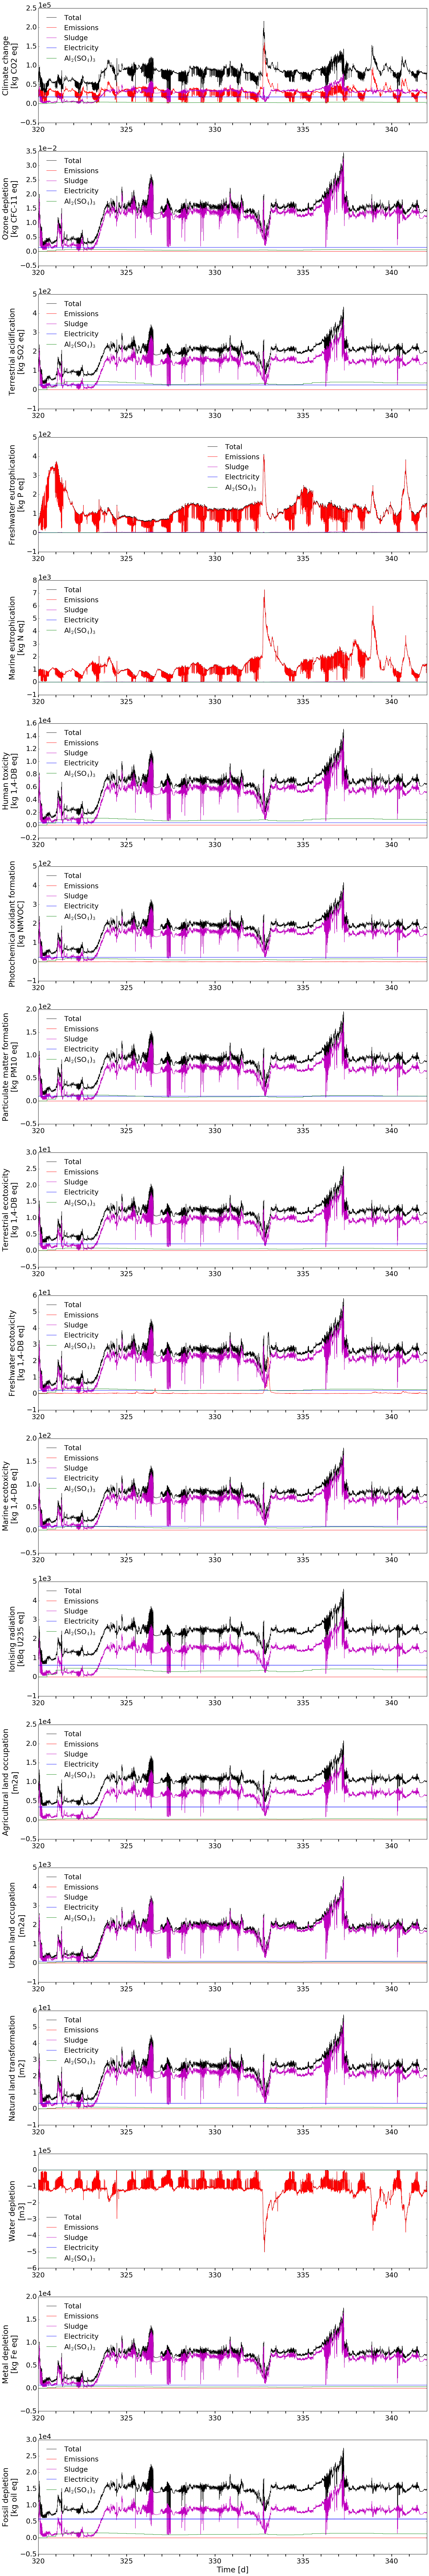

In [252]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)

if time_intervals:
    ## Effluent phosphate emissions compared to influent phosphate mass flow rate and dosing of aluminium sulphate
    fig, axes = plt.subplots(nrows=18,figsize=(22,18*8))#18*5
    _=plt.subplots_adjust(hspace=0.25)#Adjust space between plots
    #figsize=(w,h) in inches
    for i,ax in enumerate(axes):
        _=ax.plot(midpoint_total['time'],midpoint_total[midpoint_categories[i]],'k-',ms=2,\
               label='Total')
        _=ax.plot(emissions_midpoint['time'],emissions_midpoint[midpoint_categories[i]],'r-',ms=2,\
               label='Emissions')
        _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint[midpoint_categories[i]],'m-',ms=2,\
               label='Sludge')
        _=ax.plot(electricity_midpoint['time'],electricity_midpoint[midpoint_categories[i]],'b-',ms=2,\
               label='Electricity')
        _=ax.plot(al_dosing_midpoint['time'],al_dosing_midpoint[midpoint_categories[i]],'g-',ms=2,\
               label='Al$_2$(SO$_4$)$_3$')
        #'k.': markers are black point
        #ms=10: marker size
    #     _=ax.set_title('Various effluent emissions between two subsequent points in time' ,fontsize=20)
        if i==17:#Python starts indexing at 0...
            _=ax.set_xlabel('Time [d]',fontsize=24)
        _=ax.set_xlim(relevant_effluent_data.loc[0,'time'],relevant_effluent_data.loc[len(relevant_effluent_data)-1,\
        'time'])
        _=ax.set_ylabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==midpoint_categories[i]][0]+'\n['\
        +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==midpoint_categories[i]][0]+']',fontsize=24)
        _=ax.legend(loc=(0),fontsize=22,frameon=False)
        #Use scientiefic notation for (m,n), i.e number: <10^m,>10^n
        ax.yaxis.get_major_formatter().set_powerlimits((0, 1))#
        #Probably used pylab for 1 of the modifications beneath
        ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
        minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
        ax.xaxis.set_minor_locator(minorLocator)
        ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
        ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
        ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
        ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
        ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
        ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    if save_plots:
        plt.savefig('results/'+scenario_name+'_midpointResults_timeSeries',bbox_inches='tight')

### Probability distributions
Here, the above time series will be converted to histograms in order to visualize the distribution of the obtained results. This will for instance be interesting if emission peaks occur. This will in particular be relevant for impact categories related to emissions where large peaks can cause large acute impacts, probably eutrophication and toxicity related impacts categories. For these categories, the fact that these peaks are or are not present, might be an additional driver for decision making.<br>
Another interesting aspect about the histograms, is that if the functional unit that has the most influence on the environmental impacts is chosen, a more homogeneous result in time will be obtained. Hence, the statistical dispersion of the data will become much smaller! Thus, in addition to the time series - where this is also visible - the histograms will aid nicely in locating the main driver of the environmental impacts. 

#### Histograms of the total impacts for the midpoint impact categories

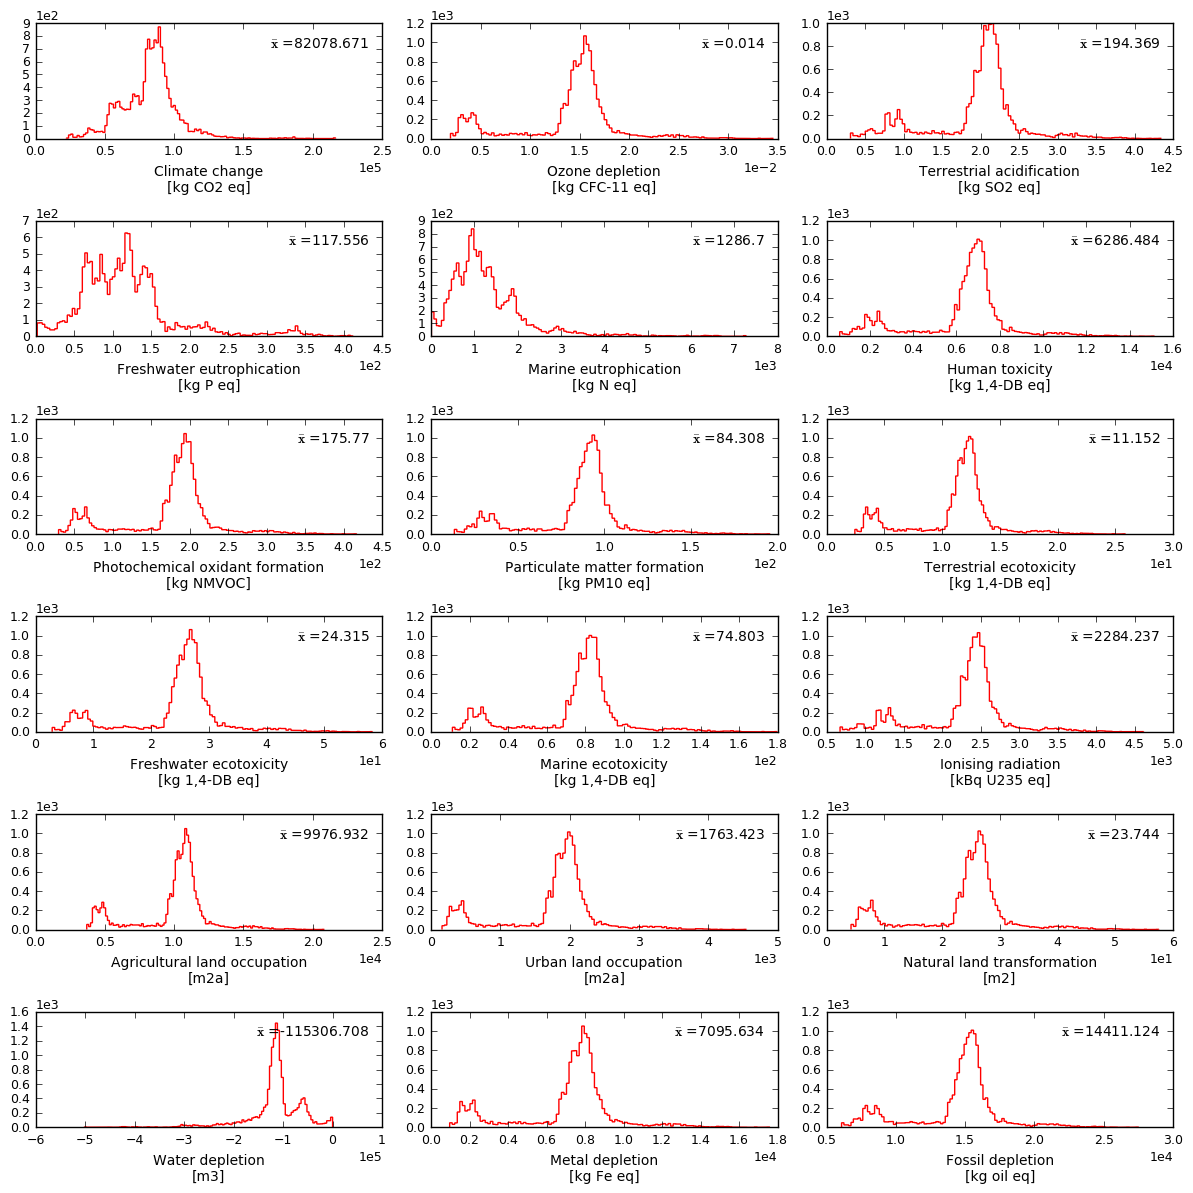

In [253]:
if time_intervals:
    _=plt.figure(figsize=(3*4,6*2))
    #figsize=(w,h) in inches
    _=plt.subplots_adjust(hspace=0.7,wspace=0.1)#Adjust space between plots
    for category,i in zip(midpoint_categories,range(len(midpoint_categories))):#Loop over impact categories. i is iteration number.
        _=plt.subplot(6,3,i+1)#Make one figure with subplots.
        dist_avg=round(np.average(midpoint_total.loc[1:,category].values),3)#Add arithmetic mean to plot. Don't take t=0 into account.
        #Make histogram. Number of bins equal to sqrt(observations), rounded to nearest integer. Do not plot time=0, because no impact
        #generated yet then. Do not normalize frequencies, this will give strange result for impacts smaller than 1. Add mean as legend label.
        _=plt.hist(midpoint_total.loc[1:,category].values,bins=int(round(np.sqrt(len(midpoint_total)-1))),\
        histtype='step',normed=False,color='r',label=r'$\mathbf{\bar x}$ ='+str(dist_avg))
        #Remove makertype from legend.
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
        #Use scientiefic notation for numbers bigger than (10,1), i.e. 10^1
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        #Get x axis labels.
        _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
        +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=10)
    #     _=plt.ylabel('Frequency',fontsize=10)#Not really much sense in adding this.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
    if save_plots:
        plt.savefig('results/'+scenario_name+'_midpoint_distribution_total',bbox_inches='tight')

#### Histograms of the impacts of the contributing processes for the midpoint impact categories

In [254]:
## Note, only comment added in first part of for loop to avoid unnecessary large cel length
if time_intervals:   
    _=plt.figure(figsize=(4*3,18*2))#Make one figure
    #figsize=(w,h) in inches
    counter=1#Used to add subplots to their respective place in the figure
    _=plt.subplots_adjust(hspace=0.4,wspace=0.4)#Adjust space between plots
    for category in midpoint_categories:#Loop over impact categories. 
        ##Plot first contributing process
        _=plt.subplot(18,4,counter)#Make subplots on one figure
        counter+=1#One figure added, thus add next figure on subsequent place
        ##Make histogram. Number of bins equal to sqrt(observations), rounded to nearest integer. Do not plot time=0, because no impact
        ##generated yet then. Do not normalize frequencies, this will give strange result for impacts smaller than 1.
        _=plt.hist(emissions_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
        histtype='step',normed=False,color='b',label='Emissions')
        ##Use scientiefic notation for number bigger than (10,1), i.e. 10^3
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
        ##Get x axis labels.
        #Full impact category names
#         _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
#         +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=10)
        #Abbreviations
        _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=10)
#         _=plt.ylabel('Frequency',fontsize=10)#Not really much sense in adding this.
        ##Remove makertype from legend.
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
            
        ##Plot subsequent contributing process
        _=plt.subplot(18,4,counter)
        _=plt.hist(sludge_treatment_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
        histtype='step',normed=False,color='c',label='Sludge')
        counter+=1
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
        ##Full impact category names as x axis label.
#         _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
#         +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=10)
        ##Abbreviations as x axis label.
        _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=10)
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)

        _=plt.subplot(18,4,counter)
        _=plt.hist(electricity_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
        histtype='step',normed=False,color='y',label='Electricity')
        counter+=1
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))#Limit number of tick labels
        ##Full impact category names as x axis label.
#         _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
#         +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=10)
        ##Abbreviations as x axis label.
        _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=10)
#         _=plt.ylabel('Frequency',fontsize=10)#Not really much sense in adding this.
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
        
        _=plt.subplot(18,4,counter)
        _=plt.hist(al_dosing_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
        histtype='step',normed=False,color='m',label='Al$_2$(SO$_4$)$_3$')
        counter+=1
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
        #Full impact category names as x axis label.
#         _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
#         +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=10)
        #Abbreviations as x axis label.
        _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=10)
#         _=plt.ylabel('Frequency',fontsize=10)#Not really much sense in adding this.
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
        if save_plots:
            plt.savefig('results/'+scenario_name+'_midpoint_distribution_contributions',bbox_inches='tight')

#### Histograms of the total impacts for the endpoint impact categories

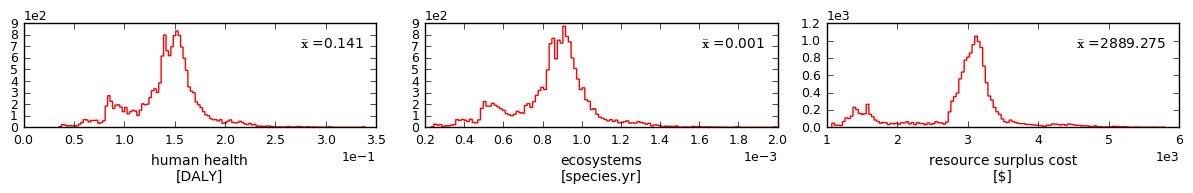

In [255]:
if time_intervals:
    _=plt.figure(figsize=(3*4,2))
    #figsize=(w,h) in inches
    _=plt.subplots_adjust(hspace=0.7,wspace=0.1)#Adjust space between plots
    for category,i in zip(endpoint_categories,range(len(endpoint_categories))):#Loop over impact categories. i is iteration number.
        _=plt.subplot(1,3,i+1)#Make one figure with subplots.
        dist_avg=round(np.average(endpoint_sum_total.loc[1:,category].values),3)#Add arithmetic mean to plot. Don't take t=0 into account.
        #Make histogram. Number of bins equal to sqrt(observations), rounded to nearest integer. Do not plot time=0, because no impact
        #generated yet then. Do not normalize frequencies, this will give strange result for impacts smaller than 1. Add mean as legend label.
        _=plt.hist(endpoint_sum_total.loc[1:,category].values,bins=int(round(np.sqrt(len(endpoint_sum_total)-1))),\
        histtype='step',normed=False,color='r',label=r'$\mathbf{\bar x}$ ='+str(dist_avg))
        #Remove makertype from legend.
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
        #Use scientiefic notation for numbers bigger than (10,1), i.e. 10^1
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        #Get x axis labels.
        _=plt.xlabel(units_endpoint_sum.columns[units_endpoint_sum.loc['abbreviation']==category][0]+'\n['\
        +units_endpoint_sum.loc['unit',units_endpoint_sum.loc['abbreviation']==category][0]+']',fontsize=10)
    #     _=plt.ylabel('Frequency',fontsize=10)#Not really much sense in adding this.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
    if save_plots:
        plt.savefig('results/'+scenario_name+'_endpoint_distribution_total',bbox_inches='tight')

#### Histograms of the impacts of the contributing processes for the endpoint impact categories

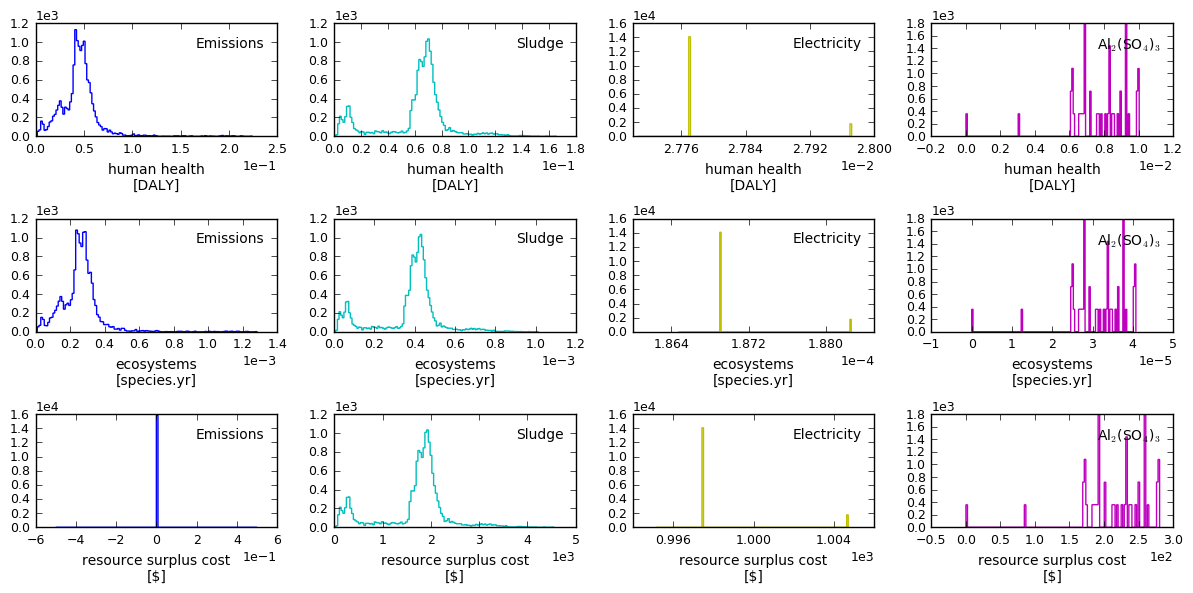

In [256]:
## Note, only comment added in first part of for loop to avoid unnecessary large cel length
if time_intervals:   
    _=plt.figure(figsize=(4*3,3*2))#Make one figure
    #figsize=(w,h) in inches
    counter=1#Used to add subplots to their respective place in the figure
    _=plt.subplots_adjust(hspace=0.4,wspace=0.4)#Adjust space between plots
    for category in endpoint_categories:#Loop over impact categories. 
        ##Plot first contributing process
        _=plt.subplot(3,4,counter)#Make subplots on one figure
        counter+=1#One figure added, thus add next figure on subsequent place
        ##Make histogram. Number of bins equal to sqrt(observations), rounded to nearest integer. Do not plot time=0, because no impact
        ##generated yet then. Do not normalize frequencies, this will give strange result for impacts smaller than 1.
        _=plt.hist(emissions_endpoint_sum.loc[1:,category].values, bins=int(round(np.sqrt(len(endpoint_sum_total)-1))),\
        histtype='step',normed=False,color='b',label='Emissions')
        ##Use scientiefic notation for number bigger than (10,1), i.e. 10^3
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
        ##Get x axis labels.
        #Full impact category names
        _=plt.xlabel(units_endpoint_sum.columns[units_endpoint_sum.loc['abbreviation']==category][0]+'\n['\
        +units_endpoint_sum.loc['unit',units_endpoint_sum.loc['abbreviation']==category][0]+']',fontsize=10)
        #Abbreviations
#         _=plt.xlabel(category+'\n['+units_endpoint_sum.loc['unit',units_endpoint_sum.loc['abbreviation']==category][0]+']',fontsize=10)
#         _=plt.ylabel('Frequency',fontsize=10)#Not really much sense in adding this.
        ##Remove makertype from legend.
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
            
        ##Plot subsequent contributing process
        _=plt.subplot(3,4,counter)
        _=plt.hist(sludge_treatment_endpoint_sum.loc[1:,category].values, bins=int(round(np.sqrt(len(endpoint_sum_total)-1))),\
        histtype='step',normed=False,color='c',label='Sludge')
        counter+=1
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
        ##Full impact category names as x axis label.
        _=plt.xlabel(units_endpoint_sum.columns[units_endpoint_sum.loc['abbreviation']==category][0]+'\n['\
        +units_endpoint_sum.loc['unit',units_endpoint_sum.loc['abbreviation']==category][0]+']',fontsize=10)
        ##Abbreviations as x axis label.
#         _=plt.xlabel(category+'\n['+units_endpoint_sum.loc['unit',units_endpoint_sum.loc['abbreviation']==category][0]+']',fontsize=10)
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)

        _=plt.subplot(3,4,counter)
        _=plt.hist(electricity_endpoint_sum.loc[1:,category].values, bins=int(round(np.sqrt(len(endpoint_sum_total)-1))),\
        histtype='step',normed=False,color='y',label='Electricity')
        counter+=1
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))#Limit number of tick labels
        ##Full impact category names as x axis label.
        _=plt.xlabel(units_endpoint_sum.columns[units_endpoint_sum.loc['abbreviation']==category][0]+'\n['\
        +units_endpoint_sum.loc['unit',units_endpoint_sum.loc['abbreviation']==category][0]+']',fontsize=10)
        ##Abbreviations as x axis label.
#         _=plt.xlabel(category+'\n['+units_endpoint_sum.loc['unit',units_endpoint_sum.loc['abbreviation']==category][0]+']',fontsize=10)
#         _=plt.ylabel('Frequency',fontsize=10)#Not really much sense in adding this.
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
        
        _=plt.subplot(3,4,counter)
        _=plt.hist(al_dosing_endpoint_sum.loc[1:,category].values, bins=int(round(np.sqrt(len(endpoint_sum_total)-1))),\
        histtype='step',normed=False,color='m',label='Al$_2$(SO$_4$)$_3$')
        counter+=1
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        plt.tick_params(axis='both', which='both', labelsize=9)#Adjust tick label fontsize
        plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
        #Full impact category names as x axis label.
        _=plt.xlabel(units_endpoint_sum.columns[units_endpoint_sum.loc['abbreviation']==category][0]+'\n['\
        +units_endpoint_sum.loc['unit',units_endpoint_sum.loc['abbreviation']==category][0]+']',fontsize=10)
        #Abbreviations as x axis label.
#         _=plt.xlabel(category+'\n['+units_endpoint_sum.loc['unit',units_endpoint_sum.loc['abbreviation']==category][0]+']',fontsize=10)
#         _=plt.ylabel('Frequency',fontsize=10)#Not really much sense in adding this.
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
        if save_plots:
            plt.savefig('results/'+scenario_name+'_endpoint_distribution_contributions',bbox_inches='tight')

### Heatmaps
In this section heatmaps will be made. The intention of making them, is to display the results for all ReCiPe impact categories as time series in a clear and concise manner.

One of the ways that heatmaps will be made, is to display the total endpoint scores for a scenario, next to the relative contributions of the midpoint scores. In this way, it will be possible to see which midpoint categories contribute the most to the endpoints. It will also be visible when in time the endpoint impacts are the worst.

Another way of presenting heatmaps will be plotting all the midpoint impact categories normalized to their respective maximum occurring impact in the simulation time span. On this plot will be visible when the midpoint impacts are the worst.


#### Heatmaps of endpoint results together with the relative contributions of the midpoint categories
##### Human health endpoint impact category

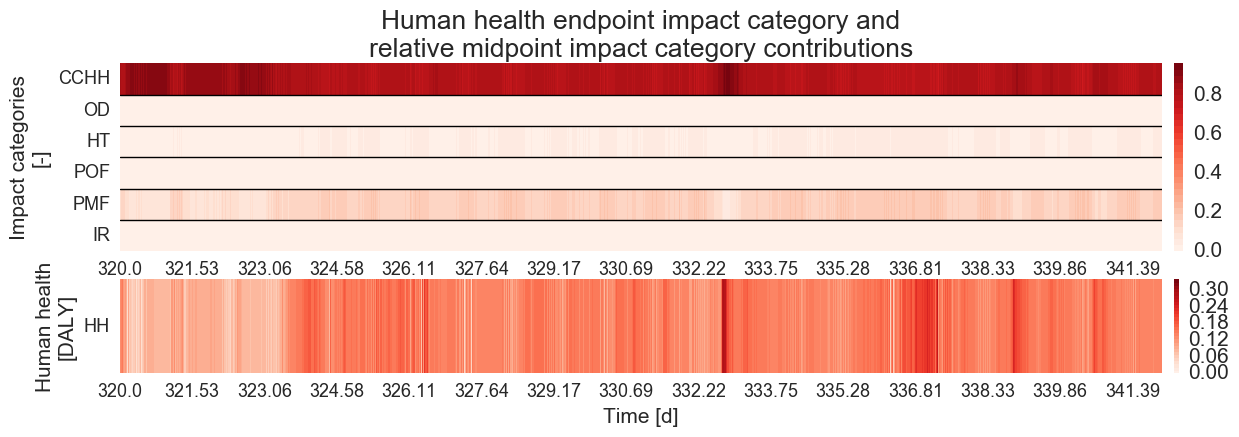

In [257]:
##Make heatmaps an option that can be chosen, because the packages for heatmaps make the layout of the other plots ugly.
if time_intervals and heatmaps:
    import os
    import seaborn as sns
    from matplotlib.colors import ListedColormap

    ##Assign data to standard variable, to make code generic
    plot_data=endpoint_total[['time','CCHH','OD','HT','POF','PMF','IR']].copy()
    plot_data2=endpoint_sum_total[['time','HH']].copy()

    ##Select data from pandas dataframe
    heat_map = pd.DataFrame(plot_data.loc[:,plot_data.columns!='time'].values,index=\
    np.round(plot_data.loc[:,'time'].values,2),columns=plot_data.columns[1:])
    heat_map2 = pd.DataFrame(plot_data2.loc[:,plot_data2.columns!='time'].values,index=\
    np.round(plot_data2.loc[:,'time'].values,2),columns=plot_data2.columns[1:])

    ##Select colorpalette
    shades = sns.color_palette('Reds',30)
   
    ##Sizes for heatmaps for in thesis
    #figsize: (15,4), title: 19, x and ylabel: 15, ticklabels: 13, font_scale: 1.5 (changes legend font size)
    ##Make plot
    fig = plt.subplots(figsize=(16,4))
    grid = gridspec.GridSpec(2, 1,height_ratios=[2, 1])#Make 2 subplots, 2 rows 1 column. Adjust individual subplot sizes
    sns.set(font_scale=1.5)#Adapt legend font size (This adapts overall fontsize. Other font sizes reset below.)
    total=plt.subplot(grid[1])#Make first subplot, place at bottom position.
    _=sns.heatmap(heat_map2.T, cmap=ListedColormap(shades),xticklabels=1100,ax=total,cbar_kws={'pad':1e-2})#xticklabels=n, display 1 label every n labels
    contributions=plt.subplot(grid[0],sharex=total)#Make 2nd subplot, place at top position.
    _=sns.heatmap(heat_map.T, cmap=ListedColormap(shades),xticklabels=1100,ax=contributions,cbar_kws={'pad':1e-2})#xticklabels=n, display 1 label every n labels
    for line in range(1,np.shape(plot_data)[1]-1):#Add lines between impact categories for clarity.
        _=contributions.axhline(line, linewidth=1, c='k')
    _=contributions.set_title('Human health endpoint impact category and\nrelative midpoint impact category contributions',fontsize=19)
    _=total.set_xlabel('Time [d]',fontsize=15)
    _=contributions.set_ylabel('Impact categories\n[-]',fontsize=15)
    _=total.set_ylabel('Human health\n[DALY]',fontsize=15)
    contributions.tick_params(axis='x', which='major', labelsize=13)#Major tick labels fontsize
    contributions.tick_params(axis='y', which='major', labelsize=13)#Major tick labels fontsize
    total.tick_params(axis='both', which='major', labelsize=13)#Major tick labels fontsize
    total.tick_params(axis='both', which='minor', labelsize=13)#Minor tick labels fontsize
    _=plt.setp( total.yaxis.get_majorticklabels(), rotation=0)#Adjust rotation of tick labels
    if save_plots:
        plt.savefig('results/'+scenario_name+'_heatmap_midpointContribution_to_humanHealthEndpoint',bbox_inches='tight')

##### Ecosystem endpoint impact category

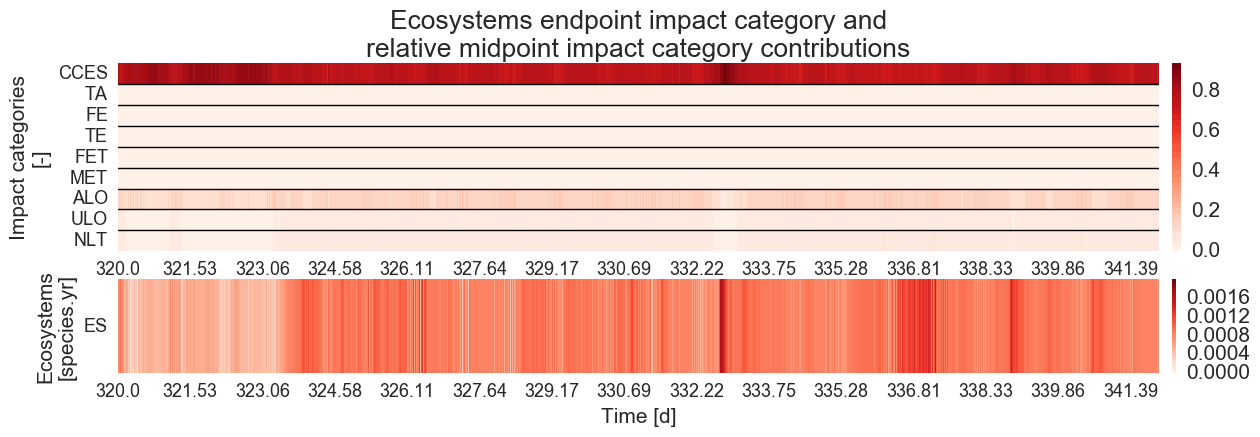

In [258]:
##Make heatmaps an option that can be chosen, because the packages for heatmaps make the layout of the other plots ugly.
if time_intervals and heatmaps:
    import os
    import seaborn as sns
    from matplotlib.colors import ListedColormap

    ##Assign data to standard variable, to make code generic
    plot_data=endpoint_total[['time','CCES','TA','FE','TE','FET','MET','ALO','ULO','NLT']].copy()
    plot_data2=endpoint_sum_total[['time','ES']].copy()

    ##Select data from pandas dataframe
    heat_map = pd.DataFrame(plot_data.loc[:,plot_data.columns!='time'].values,index=\
    np.round(plot_data.loc[:,'time'].values,2),columns=plot_data.columns[1:])
    heat_map2 = pd.DataFrame(plot_data2.loc[:,plot_data2.columns!='time'].values,index=\
    np.round(plot_data2.loc[:,'time'].values,2),columns=plot_data2.columns[1:])
    
    ##Select colorpalette
    shades = sns.color_palette('Reds',30)

    ##Sizes for heatmaps for in thesis
    #figsize: (15,4), title: 19, x and ylabel: 15, ticklabels: 13, font_scale: 1.5 (changes legend font size)
    ##Make plot
    fig = plt.subplots(figsize=(16,4))
    grid = gridspec.GridSpec(2, 1,height_ratios=[2, 1])#Make 2 subplots, 2 rows 1 column. Adjust individual subplot sizes
    sns.set(font_scale=1.5)#Adapt legend font size (This adapts overall fontsize. Other font sizes reset below.)
    total=plt.subplot(grid[1])#Make first subplot, place at bottom position.
    _= sns.heatmap(heat_map2.T, cmap=ListedColormap(shades),xticklabels=1100,ax=total,cbar_kws={'pad':1e-2})#xticklabels=n, display 1 label every n labels
    contributions=plt.subplot(grid[0],sharex=total)#Make 2nd subplot, place at top position.
    _= sns.heatmap(heat_map.T, cmap=ListedColormap(shades),xticklabels=1100,ax=contributions,cbar_kws={'pad':1e-2})#xticklabels=n, display 1 label every n labels
    for line in range(1,np.shape(plot_data)[1]-1):#Add lines between impact categories for clarity.
        _=contributions.axhline(line, linewidth=1, c='k')
    _=contributions.set_title('Ecosystems endpoint impact category and\nrelative midpoint impact category contributions',fontsize=19)
    _=total.set_xlabel('Time [d]',fontsize=15)
    _=contributions.set_ylabel('Impact categories\n[-]',fontsize=15)
    _=total.set_ylabel('Ecosystems\n[species.yr]',fontsize=15)
    total.tick_params(axis='both', which='major', labelsize=13)#Major tick labels fontsize
    total.tick_params(axis='both', which='minor', labelsize=13)#Minor tick labels fontsize
    contributions.tick_params(axis='both', which='major', labelsize=13)#Major tick labels fontsize
    contributions.tick_params(axis='both', which='minor', labelsize=13)#Minor tick labels fontsize
    _=plt.setp( total.yaxis.get_majorticklabels(), rotation=0)#Adjust rotation of tick labels
    if save_plots:
        plt.savefig('results/'+scenario_name+'_heatmap_midpointContribution_to_ecosystemsEndpoint',bbox_inches='tight')

##### Resource surplus cost endpoint impact category

In [259]:
##Make heatmaps an option that can be chosen, because the packages for heatmaps make the layout of the other plots ugly.
if time_intervals and heatmaps:
    import os
    import seaborn as sns
    from matplotlib.colors import ListedColormap

    ##Assign data to standard variable, to make code generic
    plot_data=endpoint_total[['time','MD','FD']].copy()
    plot_data2=endpoint_sum_total[['time','RSC']].copy()

    ##Select data from pandas dataframe
    heat_map = pd.DataFrame(plot_data.loc[:,plot_data.columns!='time'].values,index=\
    np.round(plot_data.loc[:,'time'].values,2),columns=plot_data.columns[1:])
    heat_map2 = pd.DataFrame(plot_data2.loc[:,plot_data2.columns!='time'].values,index=\
    np.round(plot_data2.loc[:,'time'].values,2),columns=plot_data2.columns[1:])

    ##Select colorpalette
    shades = sns.color_palette('Reds',30)

    ##Sizes for heatmaps for in thesis
    #figsize: (15,3.8), title: 19, x and ylabel: 15, ticklabels: 13, font_scale: 1.5 (changes legend font size)
    ##Make plot
    fig = plt.subplots(figsize=(16,3.8))
    grid = gridspec.GridSpec(2, 1,height_ratios=[1.3, 1])#Make 2 subplots, 2 rows 1 column. Adjust individual subplot sizes [2,1]
    sns.set(font_scale=1.5)#Adapt legend font size (This adapts overall fontsize. Other font sizes reset below.)
    total=plt.subplot(grid[1])#Make first subplot, place at bottom position.
    _= sns.heatmap(heat_map2.T, cmap=ListedColormap(shades),xticklabels=1100,ax=total,cbar_kws={'pad':1e-2})#xticklabels=n, display 1 label every n labels
    contributions=plt.subplot(grid[0],sharex=total)#Make 2nd subplot, place at top position.
    _= sns.heatmap(heat_map.T, cmap=ListedColormap(shades),xticklabels=1100,ax=contributions,cbar_kws={'pad':1e-2})#xticklabels=n, display 1 label every n labels
    for line in range(1,np.shape(plot_data)[1]-1):#Add lines between impact categories for clarity.
        _=contributions.axhline(line, linewidth=1, c='k')
    _=contributions.set_title('Resource surplus cost endpoint impact category and\nrelative midpoint impact category contributions',fontsize=19)
    _=total.set_xlabel('Time [d]',fontsize=15)
    _=contributions.set_ylabel('Impact categories\n[-]',fontsize=15)
    _=total.set_ylabel('Resource\n surplus cost [$]',fontsize=15)
    contributions.tick_params(axis='both', which='major', labelsize=13)#Major tick labels fontsize
    contributions.tick_params(axis='both', which='minor', labelsize=13)#Minor tick labels fontsize
    total.tick_params(axis='both', which='major', labelsize=13)#Major tick labels fontsize
    total.tick_params(axis='both', which='minor', labelsize=13)#Minor tick labels fontsize
    _=plt.setp( total.yaxis.get_majorticklabels(), rotation=0)#Adjust rotation of tick labels
    _=plt.setp( contributions.yaxis.get_majorticklabels(), rotation=0)#Adjust rotation of tick labels
    if save_plots:
        plt.savefig('results/'+scenario_name+'_heatmap_midpointContribution_to_resourceSurplusCostEndpoint',bbox_inches='tight')

    ##Add horizontal lines for clarity
    # for line in range(1,np.shape(plot_data)[1]-1):
    #     _=ax.axhline(line, linewidth=1, c='k')

#### Heatmaps of midpoint results normalized to their respective maximum values

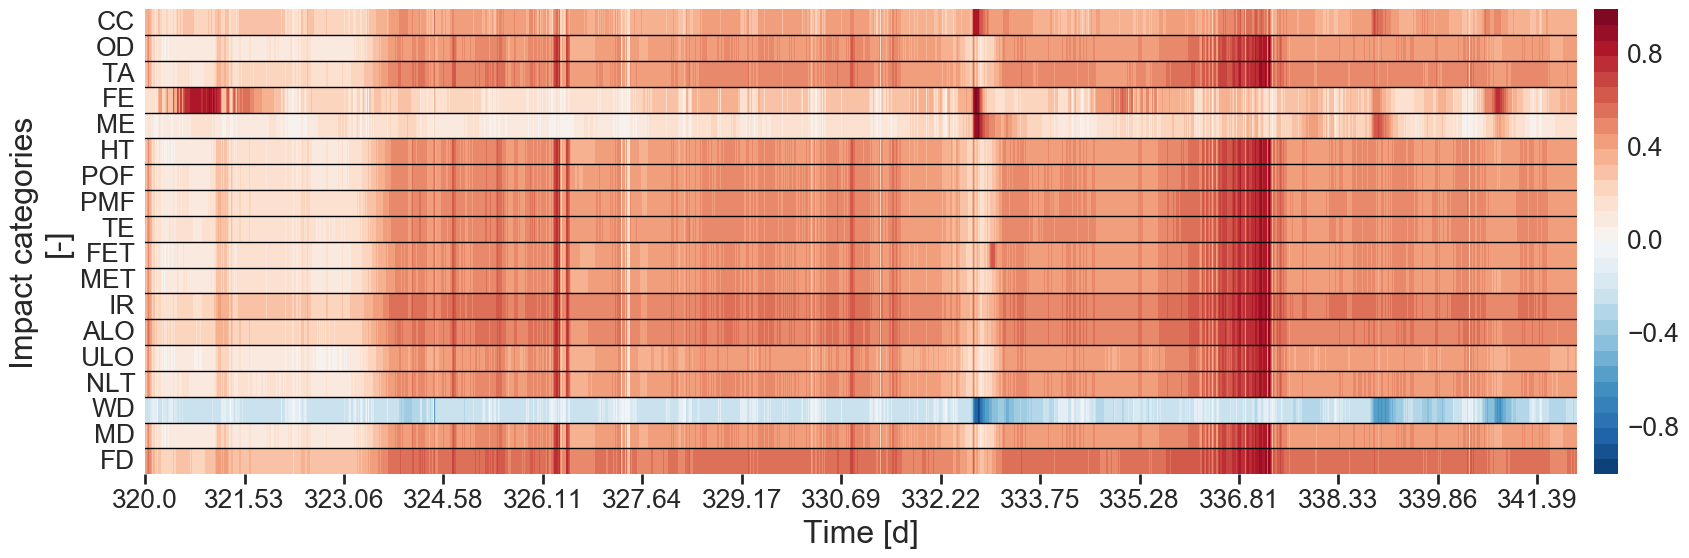

In [260]:
##Make heatmaps an option that can be chosen, because the packages for heatmaps make the layout of the other plots ugly.
if time_intervals and heatmaps:
    import os
    import seaborn as sns
    from matplotlib.colors import ListedColormap
    ##Assign data to standard variable, to make code generic
    plot_data=midpoint_total_normalized.copy()
    
#     cbar=plt.colorbar(pad = 0.05)
    ##Select data from pandas dataframe
    heat_map = pd.DataFrame(plot_data.loc[:,plot_data.columns!='time'].values,index=\
    np.round(plot_data.loc[:,'time'].values,2),columns=plot_data.columns[1:])

    ##Select colorpalette
    # shades = sns.color_palette('Blues',20)
    shades=sns.color_palette("RdBu_r",30)
    # shades=sns.color_palette("coolwarm", 7)
#     shades = sns.color_palette('Reds',30)
    # shades = sns.color_palette('YlOrRd',30)
    # shades = sns.color_palette('OrRd',30)

    ##Sizes for heatmaps for in thesis
    #figsize: (22,6), no title, x and ylabel: 23, ticklabels: 19, font_scale: 1.9 (changes legend font size)
    ##Make plot
    fig, ax = plt.subplots(figsize=(22,6))
    sns.set(font_scale=1.9)#Adapt legend font size (This adapts overall fontsize. Other font sizes reset below.)
    ax = sns.heatmap(heat_map.T, cmap=ListedColormap(shades),xticklabels=1100,cbar_kws={'pad':1e-2})
    #xticklabels=n, display 1 label every n labels, pad determines colobar position
#     _=ax.set_title('All midpoint impact category results, normalized to their respective maximum values',fontsize=24)
    _=ax.set_xlabel('Time [d]',fontsize=23)
    _=ax.set_ylabel('Impact categories\n[-]',fontsize=23)
    ax.tick_params(axis='x', which='major', labelsize=19, width=2, length=7,pad=10)#Major tick labels fontsize
    ax.tick_params(axis='y', which='major', labelsize=19)#Major tick labels fontsize
    _=plt.setp(plt.yticks()[1], rotation=0)#Adjust rotation of tick labels
    ##Add horizontal lines for clarity
    for line in range(1,np.shape(plot_data)[1]-1):
        _=ax.axhline(line, linewidth=1, c='k')
    if save_plots:
        plt.savefig('results/'+scenario_name+'_heatmap_midpoint',bbox_inches='tight')

### Barplots in case of no incorporation of dynamic aspect into LCA results, i.e. calculation of average LCA results over the whole simulation time span
If the dynamic aspect of the WWTP modelling results is not incorporated into the LCA results, total environmental impacts over the whole simulation time span are calculated (which is the case if the variable "time_intervals is set to False). Depending on the choice of the functional unit, these results are scaled to for instance the volume of influent that entered the plant in the whole simulation time span. Anyway, if "time_intervals" is set to False, for each impact category only one total result is calculated - as is normally the case in LCA. In this case, below the usual LCA barplots will be made.

#### Comparison of total midpoint impact category results for scenario analysis
If multiple scenarios are run, by altering the settings in the section "Variables that can be modified to determine the output" between subsequent notebook executions, a bar plot that compares the different scenarios can be generated in this section.

In [261]:
###This code can be used to alter the order of the plots.
##First, visualize the keys
# scenarios.keys()
##Fill in the keys in the keys_list, comment out keys_list in plot code
# keys_list=['TSS','setpoint','peaks','reference']

In [262]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
# plot_comparison=True
if not time_intervals and plot_comparison:
    ##First bring together the data from all the scenarios. Also obtain legend names.
    midpoint_all_scenarios=pd.DataFrame(np.zeros((len(scenarios),len(midpoint_categories))),columns=midpoint_categories)
    legend_names=[0]*len(scenarios)
    keys_list=list(scenarios.keys())
    for i, key in enumerate(keys_list):
        midpoint_all_scenarios.loc[i]=scenarios[key][0].loc[1,midpoint_categories].values
        legend_names[i]=scenarios[key][1]
#     midpoint_all_scenarios#Uncomment to view
    ##Express results of different scenarios per impact category as percentage of largest result
    midpoint_all_scenarios[midpoint_categories]=midpoint_all_scenarios.values/np.max(abs(midpoint_all_scenarios.values),axis=0)*100
#     midpoint_all_scenarios#Uncomment to view
    f, ax1 = plt.subplots(1, figsize=(22,8))#figsize=(w,h) in inches
    bar_width = 0.2# Set the bar width
    ##Positions of the left bar-boundaries
    bar_l = [i+1 for i in range(np.shape(midpoint_all_scenarios)[1])]
    ##Positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l]
    ##Making the plot
    colors=['b','r','g','y','c','m','k']#Colors to choose frome. One will be chosen for each scenario.
    if len(midpoint_all_scenarios)%2!=0:#If number of scenarios is odd
        #Position set of bars at middle of x-axis label
        middle_index=int((len(midpoint_all_scenarios)+1)/2)
        position_list=list(reversed(list((np.arange(middle_index)*-1))))+list(range(1,middle_index))
        ## Create a bar plot, in position bar_l. alpha: 0 is transparent, 1 is opaque.
        for i in range(len(midpoint_all_scenarios)):
            _=ax1.bar(np.array(bar_l)+position_list[i]*bar_width,midpoint_all_scenarios.loc[i],width=bar_width,alpha=0.7,\
                      color=colors[i])
    else:#If number of scenarios is even
        #Position set of bars at middle of x-axis label
        middle_index=int(len(midpoint_all_scenarios)/2)
        position_list=list(reversed(list(((np.arange(middle_index)+1/2)*-1))))+list(np.arange(middle_index)+1/2)
        ## Create a bar plot, in position bar_l. alpha: 0 is transparent, 1 is opaque.
        for i in range(len(midpoint_all_scenarios)):
            _=ax1.bar(np.array(bar_l)+position_list[i]*bar_width,midpoint_all_scenarios.loc[i],width=bar_width,alpha=0.7,\
                      color=colors[i])
    ### set the x ticks with names
    ##Tick label name is full impact category name. Comment out in case abbreviation is tick label name
#     ticknames=[0]*len(midpoint_categories)
#     for i,category in enumerate(midpoint_categories):
#         ticknames[i]=units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]
#     _=plt.xticks(tick_pos, ticknames,rotation=45)#Best for readability is 60
    ##Tick label name is abbreviation for impact category. Comment out in case of full impact category name for tick label
    _=plt.xticks(tick_pos, midpoint_categories)
    _=ax1.set_xlabel('Midpoint impact categories',fontsize=26)
    ##Set a buffer around the edge
    _=plt.xlim([min(tick_pos)-bar_width*len(midpoint_all_scenarios)/1.5, max(tick_pos)+bar_width*len(midpoint_all_scenarios)/1.5])
    _=ax1.set_ylabel('Impact category result\n [% of maximum result]',fontsize=26)
    _=ax1.legend( legend_names,loc=0,fontsize=26)
    ##Probably used pylab for 1 of the modifications beneath
    ax1.tick_params(axis='both', which='major', labelsize=26)#Major tick labels fontsize
#     ax1.tick_params(axis='both', which='minor', labelsize=14)#Minor tick labels fontsize
    ##Clear memory
    del midpoint_all_scenarios
    if save_plots:
        plt.savefig('results/'+scenario_name+'_barchart_comparison_midpoint',bbox_inches='tight')

#### Comparison of total midpoint endpoint category results for scenario analysis
If multiple scenarios are run, by altering the settings in the section "Variables that can be modified to determine the output" between subsequent notebook executions, a bar plot that compares the different scenarios can be generated in this section.

In [263]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
if not time_intervals and plot_comparison:
    ##First bring together the data from all the scenarios. Also obtain legend names.
    endpoint_all_scenarios=pd.DataFrame(np.zeros((len(scenarios),len(endpoint_categories))),columns=endpoint_categories)
    legend_names=[0]*len(scenarios)
    keys_list=list(scenarios.keys())
    for i, key in enumerate(keys_list):
        endpoint_all_scenarios.loc[i]=scenarios[key][2].loc[1,endpoint_categories].values
        legend_names[i]=scenarios[key][1]
#     endpoint_all_scenarios#Uncomment to view
    ##Express results of different scenarios per impact category as percentage of largest result
    endpoint_all_scenarios[endpoint_categories]=endpoint_all_scenarios.values/np.max(abs(endpoint_all_scenarios.values),axis=0)*100
#     endpoint_all_scenarios#Uncomment to view
    f, ax1 = plt.subplots(1, figsize=(22,4))#figsize=(w,h) in inches
    bar_width = 0.1# Set the bar width
    ##Positions of the left bar-boundaries
    bar_l = [i+1 for i in range(np.shape(endpoint_all_scenarios)[1])]
    ##Positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l]
    ##Making the plot
    colors=['b','r','g','y','c','m','k']#Colors to choose frome. One will be chosen for each scenario.
    if len(endpoint_all_scenarios)%2!=0:#If number of scenarios is odd
        #Position set of bars at middle of x-axis label
        middle_index=int((len(endpoint_all_scenarios)+1)/2)
        position_list=list(reversed(list((np.arange(middle_index)*-1))))+list(range(1,middle_index))
        ## Create a bar plot, in position bar_l. alpha: 0 is transparent, 1 is opaque.
        for i in range(len(endpoint_all_scenarios)):
            _=ax1.bar(np.array(bar_l)+position_list[i]*bar_width,endpoint_all_scenarios.loc[i],width=bar_width,alpha=0.7,\
                      color=colors[i])
    else:#If number of scenarios is even
        #Position set of bars at middle of x-axis label
        middle_index=int(len(endpoint_all_scenarios)/2)
        position_list=list(reversed(list(((np.arange(middle_index)+1/2)*-1))))+list(np.arange(middle_index)+1/2)
        ## Create a bar plot, in position bar_l. alpha: 0 is transparent, 1 is opaque.
        for i in range(len(endpoint_all_scenarios)):
            _=ax1.bar(np.array(bar_l)+position_list[i]*bar_width,endpoint_all_scenarios.loc[i],width=bar_width,alpha=0.7,\
                      color=colors[i])
    ### set the x ticks with names
    ##Tick label name is full impact category name. Comment out in case abbreviation is tick label name
    ticknames=[0]*len(endpoint_categories)
    for i,category in enumerate(endpoint_categories):
        ticknames[i]=units_endpoint_sum.columns[units_endpoint_sum.loc['abbreviation']==category][0]
    _=plt.xticks(tick_pos, ticknames)
    ##Tick label name is abbreviation for impact category. Comment out in case of full impact category name for tick label
#     _=plt.xticks(tick_pos, endpoint_categories)
#     _=ax1.set_xlabel('Endpoint impact categories',fontsize=16)
    ##Set a buffer around the edge
    _=plt.xlim([min(tick_pos)-bar_width*len(endpoint_all_scenarios)/1.5, max(tick_pos)+bar_width*len(endpoint_all_scenarios)/1.5])
    _=ax1.set_ylabel('Impact category\nresult [% of ma-\nximum result]',fontsize=26)
    _=ax1.legend( legend_names,loc=(0.6,0.2),fontsize=26)
    ##Probably used pylab for 1 of the modifications beneath
    ax1.tick_params(axis='both', which='major', labelsize=26)#Major tick labels fontsize
    ax1.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
#     ax1.tick_params(axis='both', which='minor', labelsize=14)#Minor tick labels fontsize
    if save_plots:
        plt.savefig('results/'+scenario_name+'_barchart_comparison_endpoint',bbox_inches='tight')

#### Bar chart for analysis of contributions to midpoint impact categories
In this section, a bar chart will be made that visualizes the individual contributions of the processes that were taken into account to the total impact category results.

In [264]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
# if not time_intervals:
if not time_intervals:
    ##Assign data to standard variable, to make code generic
    bar_data=bar_chart_data_normalized.copy()
    f, ax1 = plt.subplots(1, figsize=(22,5))#figsize=(w,h) in inches
    bar_width = 0.75# Set the bar width
    ##For testing if negattive values are plotted correctly:
#     bar_data.loc['Sludge','WD']=-10
#     bar_data.loc['Electricity','WD']=-20
#     bar_data.loc['Al$_2$(SO$_4$)$_3$','WD']=-30
    # positions of the left bar-boundaries
    bar_l = [i+1 for i in range(np.shape(bar_data)[1])]
    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l]
    # Create a bar plot, in position bar_1. alpha: 0 is transparent, 1 is opaque.
    _=ax1.bar(bar_l,bar_data.T['Emissions'],width=bar_width,label='Emissions',alpha=0.7,color='#F4561D')
    ##The bars will be composed of the contributing elements. If the first element is plotted in one bar, the value where the bar stopped
    ##is the bottom for the subsequent value. Since negative and positive values can occur, one "bottom" for positive and one for negative
    ##values needs to be caclulated.
    #Initialize bottoms
    bottoms_pos=[0]*np.shape(bar_data)[1]
    bottoms_neg=[0]*np.shape(bar_data)[1]
    bottoms=[0]*np.shape(bar_data)[1]
    #Calculate bottoms
    for i,category in enumerate(bar_data.columns):
        if bar_data.loc['Emissions',category]>0:#At position 0, emissions is located.
            bottoms_pos[i]+=bar_data.loc['Emissions',category]
        else:
            bottoms_neg[i]+=bar_data.loc['Emissions',category]
        if bar_data.loc['Sludge',category]>0:#This part determines the bottoms for the next addition to the bar. At position 1, sludge is located.
            bottoms[i]=bottoms_pos[i]
        else:
            bottoms[i]=bottoms_neg[i]
    _=ax1.bar(bar_l,bar_data.T['Sludge'],width=bar_width,bottom=bottoms,label='Sludge',alpha=0.7,color='#F1911E')
    bottoms=[0]*np.shape(bar_data)[1]
    #Update bottoms_pos and bottoms_neg and determine bottoms for next addition to bars.
    for i,category in enumerate(bar_data.columns):
        if bar_data.loc['Sludge',category]>0:#At position 1, sludge is located.
            bottoms_pos[i]+=bar_data.loc['Sludge',category]
        else:
            bottoms_neg[i]+=bar_data.loc['Sludge',category]
        if bar_data.loc['Electricity',category]>0:#This part determines the bottoms for the next addition to the bar. At position 2, electricity is located.
            bottoms[i]=bottoms_pos[i]
        else:
            bottoms[i]=bottoms_neg[i]
    _=ax1.bar(bar_l,bar_data.T['Electricity'],width=bar_width,bottom=bottoms,label='Electricity',alpha=0.7,color='#F1BD1A')
    bottoms=[0]*np.shape(bar_data)[1]
    for i,category in enumerate(bar_data.columns):
        if bar_data.loc['Electricity',category]>0:# At position 2, electricity is located.
            bottoms_pos[i]+=bar_data.loc['Electricity',category]
        else:
            bottoms_neg[i]+=bar_data.loc['Electricity',category]
        if bar_data.loc['Al$_2$(SO$_4$)$_3$',category]>0:#This part determines the bottoms for the next addition to the bar. 
                                                    #At position 3, Al2(SO4)3 is located.
            bottoms[i]=bottoms_pos[i]
        else:
            bottoms[i]=bottoms_neg[i]
    _=ax1.bar(bar_l,bar_data.T['Al$_2$(SO$_4$)$_3$'],width=bar_width,bottom=bottoms,label='Al$_2$(SO$_4$)$_3$',alpha=0.7,color='#40FF00')
    ### set the x ticks with names
    ##Tick label name is full impact catgeory name. Comment out in case abbreviation is tick label name
#     ticknames=[0]*np.shape(bar_data)[1]
#     for i,category in enumerate(bar_data.columns):
#         ticknames[i]=units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]
#     _=plt.xticks(tick_pos, ticknames,rotation=30)#Best for readability is 60
    ##Tick label name is abbreviation for impact category. Comment out in case of full impact category name for tick label
    _=plt.xticks(tick_pos, bar_data.columns)
    _=ax1.set_xlabel('Midpoint impact categories',fontsize=24)
    # Set a buffer around the edge
    _=plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
    _=ax1.set_ylabel('Impact category\ncontribution [%]',fontsize=24)
    _=ax1.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),ncol=4,fontsize=22)
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
    #Probably used pylab for 1 of the modifications beneath
    ax1.tick_params(axis='both', which='major', labelsize=22)#Major tick labels fontsize
#     ax1.tick_params(axis='both', which='minor', labelsize=14)#Minor tick labels fontsize
    bar_data#Uncomment to view
    if save_plots:
        plt.savefig('results/'+scenario_name+'_barchart_contributions_midpoint',bbox_inches='tight')
    

#### Bar chart for analysis of contributions to endpoint impact categories
In this section, a bar chart will be made that visualizes the individual contributions of the processes that were taken into account to the total impact category results.

In [265]:
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
# if not time_intervals:
if not time_intervals:
    ##Assign data to standard variable, to make code generic
    bar_data=bar_chart_data_normalized2.copy()
    f, ax1 = plt.subplots(1, figsize=(22,5))#figsize=(w,h) in inches
    bar_width = 0.75# Set the bar width
    # positions of the left bar-boundaries
    bar_l = [i+1 for i in range(np.shape(bar_data)[1])]
    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l]
    # Create a bar plot, in position bar_1. alpha: 0 is transparent, 1 is opaque.
    _=ax1.bar(bar_l,bar_data.T['Emissions'],width=bar_width,label='Emissions',alpha=0.7,color='#F4561D')
    ##The bars will be composed of the contributing elements. If the first element is plotted in one bar, the value where the bar stopped
    ##is the bottom for the subsequent value. Since negative and positive values can occur, one "bottom" for positive and one for negative
    ##values needs to be caclulated.
    #Initialize bottoms
    bottoms_pos=[0]*np.shape(bar_data)[1]
    bottoms_neg=[0]*np.shape(bar_data)[1]
    bottoms=[0]*np.shape(bar_data)[1]
    #Calculate bottoms
    for i,category in enumerate(bar_data.columns):
        if bar_data.loc['Emissions',category]>0:
            bottoms_pos[i]+=bar_data.loc['Emissions',category]
        else:
            bottoms_neg[i]+=bar_data.loc['Emissions',category]
        if bar_data.loc['Sludge',category]>0:#This part determines the bottoms for the next addition to the bar. 
            bottoms[i]=bottoms_pos[i]
        else:
            bottoms[i]=bottoms_neg[i]
    _=ax1.bar(bar_l,bar_data.T['Sludge'],width=bar_width,bottom=bottoms,label='Sludge',alpha=0.7,color='#F1911E')
    bottoms=[0]*np.shape(bar_data)[1]
    #Update bottoms_pos and bottoms_neg and determine bottoms for next addition to bars.
    for i,category in enumerate(bar_data.columns):
        if bar_data.loc['Sludge',category]>0:
            bottoms_pos[i]+=bar_data.loc['Sludge',category]
        else:
            bottoms_neg[i]+=bar_data.loc['Sludge',category]
        if bar_data.loc['Electricity',category]>0:#This part determines the bottoms for the next addition to the bar. 
            bottoms[i]=bottoms_pos[i]
        else:
            bottoms[i]=bottoms_neg[i]
    _=ax1.bar(bar_l,bar_data.T['Electricity'],width=bar_width,bottom=bottoms,label='Electricity',alpha=0.7,color='#F1BD1A')
    bottoms=[0]*np.shape(bar_data)[1]
    for i,category in enumerate(bar_data.columns):
        if bar_data.loc['Electricity',category]>0:
            bottoms_pos[i]+=bar_data.loc['Electricity',category]
        else:
            bottoms_neg[i]+=bar_data.loc['Electricity',category]
        if bar_data.loc['Al$_2$(SO$_4$)$_3$',category]>0:#This part determines the bottoms for the next addition to the bar. 
            bottoms[i]=bottoms_pos[i]
        else:
            bottoms[i]=bottoms_neg[i]
    _=ax1.bar(bar_l,bar_data.T['Al$_2$(SO$_4$)$_3$'],width=bar_width,bottom=bottoms,label='Al$_2$(SO$_4$)$_3$',alpha=0.7,color='#40FF00')
    ### set the x ticks with names
    ##Tick label name is full impact catgeory name. Comment out in case abbreviation is tick label name
    ticknames=[0]*np.shape(bar_data)[1]
    for i,category in enumerate(bar_data.columns):
        ticknames[i]=units_endpoint_sum.columns[units_endpoint_sum.loc['abbreviation']==category][0]
    _=plt.xticks(tick_pos, ticknames)#Best for readability is 60
    ##Tick label name is abbreviation for impact category. Comment out in case of full impact category name for tick label
#     _=plt.xticks(tick_pos, bar_data.columns)
#     _=ax1.set_xlabel('Endpoint impact categories',fontsize=16)
    # Set a buffer around the edge
    _=plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
    _=ax1.set_ylabel('Impact category\ncontribution [%]',fontsize=24)
    _=ax1.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),ncol=4,fontsize=22)
    #Probably used pylab for 1 of the modifications beneath
    ax1.tick_params(axis='both', which='major', labelsize=24)#Major tick labels fontsize
#     ax1.tick_params(axis='both', which='minor', labelsize=14)#Minor tick labels fontsize
    bar_data#Uncomment to view
    if save_plots:
        plt.savefig('results/'+scenario_name+'_barchart_contributions_endpoint',bbox_inches='tight')

# Place to export plots for presentation
Since the ideal font sizes for the plot labels and titles tend to be different for presentations and written reports, below a section is made where ideal font sizes for presentations are written in the comments. In this way, a selection of the above plots only needs to be copy pasted here. Subsequently, after altering the font sizes, the selected plots can be written out.

In [266]:
##Sizes for exporting conventional plots for presenatation
#figsize: (22,6), markers: 4, of 2 ingeval meerdere plots, title: 24, ax labels: 20, tick labels: 18, scientific notation: 18, legend: 18
##Paste beneath code to generate plot to write out as png. String is written out filename.
# plt.savefig('produced_wasteSludgeMass')

# References
- Amerlinck, Y. (2015). Model refinements in view of improving wastewater treatment plant optimization: restoring the balance in sub model detail. Ghent University, Belgium. PhD thesis.
- Amerlinck, Y. (2017). Personal communication with dr. Youri Amerlinck, who was a researcher of Ghent University, faculty of bio-science engineering, in 2017.
- Ayyakkannu, K. and Chandramohan, D. (1971). Occurrence and distribution of phosphate solubilizing bacteria and phosphatase in marine sediments at Porto Novo. Marine Biology, 11: 201–205.
- Blom, B. (2013). Waterschap De Dommel. Beheren afvalwaterketen. Milieuprestatie 2013.
Online, url: http://edepot.wur.nl/306675.
- PubChem (visited at 23 april 2017). Aluminum phosphate. Online, url: https://pubchem.ncbi.nlm.nih.gov/compound/Aluminum_phosphate#section=Solubility.
- De Mulder, C. (2017). Personal communication with ir. Chaïm De Mulder, who was a researcher of Ghent University, faculty of bio-science engineering, in 2017.
- Gernaey K. V., J&oslash;rgensen S. B. (2004). Benchmarking combined biological phosphorus and nitrogen
removal wastewater treatment processes. Control Engineering Practice, 12:357–373.
- Hadjimichael, A., Morera, S., Benedetti, L., Flameling, T., Corominas, L., Weijers, S., and Comas, J. (2016). Assessing urban wastewater system upgrades using integrated modeling, life cycle analysis and shadow pricing. Environmental Science & Technology, Just Accep.
- Henze, M., Gujer, W., Mino, T., and van Loosdrecht, M. (2000). Activated sludge models
ASM1, ASM2, ASM2d and ASM3. Edited by IWA task group on mathematical modelling
for design and operation of biological wastewater treatment. Published by IWA Publishing
in its Scientific and Technical Report series. Technical report, IWA. 
- Kampschreur, M. J. (2010). Dynamics of nitric oxide and nitrous oxide emission during nitrogen conversion processes. PhD thesis. url:
http://repository.tudelft.nl/islandora/object/uuid:e48e4002-684f-4ede-95a7-47e33be018f5?collection=research.
- Kim, D., Bowen, J. D., and Kinnear, D. (2015). Comprehensive Numerical Modeling of
Greenhouse Gas Emissions from Water Resource Recovery Facilities. Water Environment Research, 87:1955-1969.
- Sijstermans, L. (2016). Personal communication with Luc Sijstermans (Manager Process & Environmental issues N.V. Slibverwerking Noord-Brabant).
- Tseng, L. D. Y., Robinson, A. K., Zhang, X. Y., Xu, X. M., Southon, J., Hamilton, A. J., Sobhani, R., Stenstrom, M. K., and Rosso, D. (2016). Identification of Preferential Paths of Fossil Carbon within Water Resource Recovery Facilities via Radiocarbon Analysis. Environmental Science & Technology, 50:12166-12178.
- VROM (2008). Protocol 8136 Afvalwater, t.b.v NIR 2008 uitgave maart 2008. Dutch.

# Appendix 1: Calculating the energy usage for sludge pumping to Mierlo
Data was obtained from the Eindhoven WWTP about sludge pumping to Mierlo. The data contains the current usage [A] of a sludge pump and the volumetric flow rate of sludge [m$^3$/h], in time intervals of 1 minute for approximately 5 days and 7 hours. Some values of the data are missing. Missing data will be replaced by values of previous time points, since the data do not vary much. The current usage will be multiplied with 400 V - the working voltage - to obtain the power usage. Both power usage and flow rate will be integrated numerically over the whole time span to calculate the total volume of sludge pumped and energy used. A density of 1 kg L$^{-1}$ will be assumed for the sludge. The total energy usage will be divided by the mass of sludge pumped to obtain an estimate for kWh (kg sludge pumped)$^{-1}$

In [267]:
pompen = pd.read_table('data/misc/pompenMierlo.txt', sep='\t',dtype=str)
# pompen.head()#Uncomment to view
pompen.drop('Datumtijd', axis=1, inplace=True)
# pompen.head()#Uncomment to view
pompen.fillna(method='pad',inplace=True)
pompen = pompen.astype(float)
# pompen.head()#Uncomment to view
pompen[['time','A','m3/h']]=pompen[['time','A','m3/h']].values*[60,400,1/(3600)]
pompen.rename(columns = {'A':'W','m3/h':'m3/s'}, inplace = True)
# pompen.head()
pompen_integrated,_=dmlca.integrate(pompen,[False])
pompen_integrated.rename(columns = {'W':'J','m3/s':'m3'}, inplace = True)
pompen_integrated.head()
print('kWh/kg sludge pumped to Mierlo')
pompen_integrated.loc[1,'J']/pompen_integrated.loc[1,'m3']/(3.6e6*1000)
print('Approximation of previous underestimation. Previously underestimated energy usage by the following factor:')
0.00033867340828878527/1.838e-5

time             J           m3
0       0.0  0.000000e+00     0.000000
1  457020.0  4.767650e+09  3910.396039

kWh/kg sludge pumped to Mierlo


0.00033867340828878527

Approximation of previous underestimation. Previously underestimated energy usage by the following factor:


18.426191963481244

# Appendix 2: calculating some life cycle inventory results to incorporate in thesis
## WWTP inputs though the influent, scaled to the FU

In [268]:
# data_influent.head()#Uncomment to view
# units#Uncomment to view

In [269]:
if LCI:
    ###Selecting data that will be included in thesis and integrating them. Resulting units: infl_q: m3/d*d=m3, infl_TN: g N/m3*m3/d*d/1000=kg N,
    ###infl_TP: g P/m3*m3/d*d/1000=kg P, infl_COD: g COD/m3*m3/d*d/1000=kg COD
    influent_inputs=data[['time','infl_q','infl_COD','infl_TN','infl_TP']].copy()
    # influent_inputs.head()#Uncomment to view
    influent_inputs[['infl_COD','infl_TN','infl_TP']]=influent_inputs[['infl_COD','infl_TN','infl_TP']].values*\
    influent_inputs['infl_q'].values.reshape((-1,1))/1000
    # influent_inputs.head()#Uncomment to view
    influent_inputs,_=dmlca.integrate(influent_inputs,[time_intervals,time_units])
    print('Units: infl_q: m3, infl_COD: kg CO, infl_TN: kg N, and infl_TP: kg P')
    influent_inputs.head()

Units: infl_q: m3, infl_COD: kg CO, infl_TN: kg N, and infl_TP: kg P


time      infl_q    infl_COD    infl_TN   infl_TP
0  320.00000    0.000000    0.000000   0.000000  0.000000
1  320.00139  181.452310  124.098437  10.064925  2.292600
2  320.00278  181.452310  124.098437  10.064925  2.292600
3  320.00417  178.025780  118.686647   9.746768  2.216450
4  320.00556  174.739333  113.496258   9.441624  2.143414

In [270]:
if LCI:
    if fu!=0:
        print('Selected functional unit and its units')
        chosen_fu_units#Uncomment to view
        chosen_fu.head()#Uncomment to view
        influent_inputs.loc[1:,influent_inputs.columns!='time']=influent_inputs.loc[1:,influent_inputs.columns!='time'].values/\
        chosen_fu.iloc[1:,1].values.reshape((-1,1))
    print('Units: see above but per FU')
    influent_inputs.head()
    if not time_intervals:
        for column in influent_inputs.loc[:,influent_inputs.columns!='time'].columns:
            print('{:s}: {:0.2e}'.format(column,influent_inputs.loc[1,column]))

Selected functional unit and its units


time timespan
0    d        d

time  timespan
0  320.00000   0.00000
1  320.00139   0.00139
2  320.00278   0.00139
3  320.00417   0.00139
4  320.00556   0.00139

Units: see above but per FU


time         infl_q      infl_COD      infl_TN      infl_TP
0  320.00000       0.000000      0.000000     0.000000     0.000000
1  320.00139  130541.230000  89279.451250  7240.953499  1649.352803
2  320.00278  130541.230000  89279.451250  7240.953499  1649.352803
3  320.00417  128076.100827  85386.076931  7012.063473  1594.568110
4  320.00556  125711.750000  81651.984095  6792.535594  1542.024325

## Calculating WWTP operational electricity usage [kWh] - not including sludge pumping - scaled to the FU

In [271]:
if LCI:
#     data_energy.head()#Uncomment to view
    data_energy_fu=data_energy.copy()
    if fu!=0:
    #     print('Selected functional unit and its units')
    #     chosen_fu_units#Uncomment to view
    #     chosen_fu.head()#Uncomment to view
        data_energy_fu.loc[1:,'energy_total']=data_energy_fu.loc[1:,'energy_total'].values/chosen_fu.iloc[1:,1].values
    print('Units: kWh/FU')
    data_energy_fu.head()
    if not time_intervals:
        print('{:s}: {:0.2e}'.format('energy_total',data_energy_fu.loc[1,'energy_total']))


Units: kWh/FU


time  energy_total
0  320.00000      0.000000
1  320.00139  33426.444453
2  320.00278  33426.444454
3  320.00417  33426.444453
4  320.00556  33426.444453

## Calculating LCI data for sludge treatment scaled to the FU

In [272]:
if LCI:
#     sludge_impact_help.head()#Uncomment to view. Unit of electricity usage is equal column name...
#     sludge_mass#Uncomment to view.
#     units_sludge_mass#Uncomment to view.
    sludge_treatment_fu=sludge_impact_help.copy()
    sludge_treatment_fu['waste_sludge']=sludge_mass['waste_sludge'].copy()
    if fu!=0:
    #     print('Selected functional unit and its units')
    #     chosen_fu_units#Uncomment to view
    #     chosen_fu.head()#Uncomment to view
        sludge_treatment_fu.loc[1:,sludge_treatment_fu.columns!='time']=sludge_treatment_fu.loc[1:,sludge_treatment_fu.columns!='time'].\
        values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    print('Units: Sludge pumping to Mierlo: kWh/FU, sludge to dry: kg sludge/FU, transport: tkm/FU, sludge to incinerate: kg sludge/FU,\n\
         waste_sludge: kg sludge/FU')
    sludge_treatment_fu.head()
    if not time_intervals:
        for column in sludge_treatment_fu.loc[:,sludge_treatment_fu.columns!='time'].columns:
            print('{:s}: {:0.2e}'.format(column,sludge_treatment_fu.loc[1,column]))



Units: Sludge pumping to Mierlo: kWh/FU, sludge to dry: kg sludge/FU, transport: tkm/FU, sludge to incinerate: kg sludge/FU,
         waste_sludge: kg sludge/FU


time         kWh  kg_sludge_to_dry           tkm  incinerated_sludge  \
0  320.00000    0.000000      0.000000e+00      0.000000            0.000000   
1  320.00139  430.081117      1.228488e+06  12698.992798       108176.605314   
2  320.00278  426.843928      1.219242e+06  12603.408417       107362.368000   
3  320.00417  400.860176      1.145021e+06  11836.186900       100826.777295   
4  320.00556  377.129608      1.077237e+06  11135.495109        94857.921295   

   waste_sludge  
0  0.000000e+00  
1  1.269899e+06  
2  1.260341e+06  
3  1.183619e+06  
4  1.113550e+06

## Scaling chemical dosing data to the FU

In [273]:

if LCI:
    if fu!=0:
#         print('Selected functional unit and its units')
#         chosen_fu_units#Uncomment to view
#         chosen_fu.head()#Uncomment to view
        al_data_units#Uncomment to view
#         al_data.head()#Uncomment to view
        al_data_fu=al_data.copy()
        al_data_fu.loc[1:,['alum_sulf','al_transport']]=al_data_fu.loc[1:,['alum_sulf','al_transport']].values/\
        chosen_fu.iloc[1:,1].values.reshape((-1,1))
    print('Units: see above but per FU')
    al_data_fu.head()
    if not time_intervals:
        for column in al_data_fu.loc[:,al_data_fu.columns!='time'].columns:
            print('{:s}: {:0.2e}'.format(column,al_data_fu.loc[1,column]))

time                    alum_sulf al_transport
0    d  kg Al$_{2}$(SO$_{4}$)$_{3}$          tkm

Units: see above but per FU


time    alum_sulf  al_transport
0  320.00000     0.000000      0.000000
1  320.00139  1783.884133    515.844156
2  320.00278   111.023430     32.104545
3  320.00417     6.883189      1.990406
4  320.00556     0.427558      0.123636

## Scaling greenhouse gas emissions to the FU
### CO2 emissions

In [274]:
if LCI:
    if fu!=0:
#         print('Selected functional unit and its units')
#         chosen_fu_units#Uncomment to view
#         chosen_fu.head()#Uncomment to view
#         co2_emissions.head()#Uncomment to view
#         co2_units#Uncomment to view
#         co2_fossil.head()#Uncomment to view
#         co2_fossil_units#Uncomment to view
        co2_lci=pd.DataFrame(columns=['time','co2_biogenic','co2_fossil'])
        co2_lci[['time','co2_fossil']]=co2_fossil.copy()
        co2_lci['co2_biogenic']=co2_emissions['co2_emission'].values-co2_fossil['co2_emission_fossil'].values
#         co2_lci#Uncomment to view
        co2_lci.loc[1:,['co2_biogenic','co2_fossil']]=co2_lci.loc[1:,['co2_biogenic','co2_fossil']].values/\
        chosen_fu.iloc[1:,1].values.reshape((-1,1))
    print('Units: kg CO2/FU')
    co2_lci.head()
    if not time_intervals:
        for column in ['co2_biogenic','co2_fossil']:
            print('{:s}: {:0.2e}'.format(column,co2_lci.loc[1,column]))

Units: kg CO2/FU


time  co2_biogenic   co2_fossil
0  320.00000      0.000000     0.000000
1  320.00139  10501.641002  1513.966552
2  320.00278  10367.495051  1494.627433
3  320.00417  10598.352523  1527.908945
4  320.00556  10535.870379  1518.901222

### N2O and CH4 emissions

In [275]:
if LCI:
    if fu!=0:
#         print('Selected functional unit and its units')
#         chosen_fu_units#Uncomment to view
#         chosen_fu.head()#Uncomment to view
#         n2o_ch4.head()#Uncomment to view
#         n2o_ch4_units#Uncomment to view
        n2o_ch4_fu=n2o_ch4.copy()
        n2o_ch4_fu.loc[1:,n2o_ch4_fu.columns!='time']=n2o_ch4_fu.loc[1:,n2o_ch4_fu.columns!='time'].values/\
        chosen_fu.iloc[1:,1].values.reshape((-1,1))
    print('Units: kg CH4/FU, kg N2O/FU')
    n2o_ch4_fu.head()
    if not time_intervals:
        for column in n2o_ch4_fu.loc[:,n2o_ch4_fu.columns!='time'].columns:
            print('{:s}: {:0.2e}'.format(column,n2o_ch4_fu.loc[1,column]))

Units: kg CH4/FU, kg N2O/FU


time  ch4_emission_fossil  ch4_emission_biogenic  n2o_emission
0  320.00000             0.000000               0.000000      0.000000
1  320.00139            65.620397             559.335762     72.409535
2  320.00278            65.620397             559.335762     72.409535
3  320.00417            62.758767             534.943772     70.120635
4  320.00556            60.014208             511.549680     67.925356

## Scaling effluent emissions to the FU

In [276]:
if LCI:
    if fu!=0:
#         print('Selected functional unit and its units')
#         chosen_fu_units#Uncomment to view
#         chosen_fu.head()#Uncomment to view
#         CFs_midpoint#Uncomment to view
#         units_relevant_data_effluent#Uncomment to view
        relevant_effluent_data.head()#Uncomment to view
        relevant_effluent_data_fu=relevant_effluent_data.copy() 
        relevant_effluent_data_fu.loc[1:,relevant_effluent_data_fu.columns!='time']=relevant_effluent_data_fu.loc[1:,\
        relevant_effluent_data_fu.columns!='time'].values/chosen_fu.iloc[1:,1].values.reshape((-1,1))
    print('Units: see dataframe, but per FU')
    units_relevant_data_effluent
    relevant_effluent_data_fu.head()
    if not time_intervals:
        for column in relevant_effluent_data_fu.loc[:,relevant_effluent_data_fu.columns!='time'].columns:
            print('{:s}: {:0.2e}'.format(column,relevant_effluent_data_fu.loc[1,column]))


time       po4  non_po4_p       no3  non_no3_n  acetic_acid  \
0  320.00000  0.000000   0.000000  0.000000   0.000000     0.000000   
1  320.00139  0.488126   0.011715  5.259562   0.932038     0.009562   
2  320.00278  0.296157   0.001013  3.309103   0.571380     0.005984   
3  320.00417  0.279741   0.000482  3.141858   0.542259     0.005595   
4  320.00556  0.271232   0.000385  3.043813   0.524404     0.005314   

             h2o  
0       0.000000  
1  276596.602651  
2  174474.955945  
3  165817.206702  
4  160555.778102

Units: see dataframe, but per FU


time     po4 non_po4_p     no3 non_no3_n      acetic_acid     h2o
0    d  kg PO4      kg P  kg NO3      kg N  kg actetic acid  kg H2O

time         po4  non_po4_p          no3   non_no3_n  acetic_acid  \
0  320.00000    0.000000   0.000000     0.000000    0.000000     0.000000   
1  320.00139  351.169657   8.427981  3783.857708  670.531033     6.879148   
2  320.00278  213.062295   0.728988  2380.649972  411.064706     4.305035   
3  320.00417  201.252628   0.346951  2260.329642  390.114247     4.025496   
4  320.00556  195.130656   0.277199  2189.793454  377.269384     3.822700   

            h2o  
0  0.000000e+00  
1  1.989904e+08  
2  1.255216e+08  
3  1.192930e+08  
4  1.155078e+08

# Appendix 3: Place for exporting plots from which only parts are needed
## Time series
In the cell below can be chosen which time series will be added to the plot that will be exported. 

In [277]:
# midpoint_categories#Midpoint impact categories. Uncomment to view.
# units_midpoint#Abbreviations for midpoint impact categories. Uncomment to view.
###All midpoint impact categories:
#['CC', 'OD', 'TA', 'FE', 'ME', 'HT', 'POF', 'PMF', 'TE', 'FET','MET', 'IR', 'ALO', 'ULO', 'NLT', 'WD', 'MD', 'FD']
##Copy above list to definition of the variable selection_list and delete unneeded categories.
selection_list=['CC']
##Run the cell
midpoint_selection=np.array(selection_list,dtype='object')
midpoint_selection#Uncomment to view

array(['CC'], dtype=object)

Set options, run cell.

In [278]:
############################
###Options
############################

extract_figures=True#Setting to True will generate the selected plots.
extract_figures=False
figure_name='all'#String. Adds identifier to string contained in scenario_name for the filename used for storage of the figure.
save_plots2=True#Setting to True will save the plots as .png.
save_plots2=False

############################
###Plot code
############################

##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
if time_intervals and extract_figures:
    ## Effluent phosphate emissions compared to influent phosphate mass flow rate and dosing of aluminium sulphate
    fig, axes = plt.subplots(nrows=len(midpoint_selection),figsize=(22,len(midpoint_selection)*8))#18*8
    _=plt.subplots_adjust(hspace=0.13)#Adjust space between plots
    #figsize=(w,h) in inches
    if len(midpoint_selection)>1:
        for i,ax in enumerate(axes):
            _=ax.plot(midpoint_total['time'],midpoint_total[midpoint_selection[i]],'k-',ms=2,\
                   label='Total')
            _=ax.plot(emissions_midpoint['time'],emissions_midpoint[midpoint_selection[i]],'r-',ms=2,\
                   label='Emissions')
            _=ax.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint[midpoint_selection[i]],'m-',ms=2,\
                   label='Sludge')
            _=ax.plot(electricity_midpoint['time'],electricity_midpoint[midpoint_selection[i]],'b-',ms=2,\
                   label='Electricity')
            _=ax.plot(al_dosing_midpoint['time'],al_dosing_midpoint[midpoint_selection[i]],'g-',ms=2,\
                   label='Al$_2$(SO$_4$)$_3$')
            #'k.': markers are black point
            #ms=10: marker size
        #     _=ax.set_title('Various effluent emissions between two subsequent points in time' ,fontsize=20)
            if i==len(midpoint_selection)-1:#Python starts indexing at 0...
                _=ax.set_xlabel('Time [d]',fontsize=24)
            _=ax.set_xlim(midpoint_total.loc[0,'time'],midpoint_total.loc[len(midpoint_total)-1,'time'])
            _=ax.set_ylabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==midpoint_selection[i]][0]+'\n['\
            +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==midpoint_selection[i]][0]+']',fontsize=24)
            _=ax.legend(loc=(0),fontsize=22,frameon=False)
            #Use scientiefic notation for (m,n), i.e number: <10^m,>10^n
            ax.yaxis.get_major_formatter().set_powerlimits((0, 1))#
            #Probably used pylab for 1 of the modifications beneath
            ax.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
            minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
            ax.xaxis.set_minor_locator(minorLocator)
            ax.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
            ax.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
            ax.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
            ax.xaxis.set_ticks_position('bottom')#Turn off ticks at top
            ax.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
            ax.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
        if save_plots2:
            plt.savefig('results/'+scenario_name+figure_name+'_midpointResults_timeSeries',bbox_inches='tight')
    else:
        _=axes.plot(midpoint_total['time'],midpoint_total[midpoint_selection[0]],'k-',ms=2,\
               label='Total')
        _=axes.plot(emissions_midpoint['time'],emissions_midpoint[midpoint_selection[0]],'r-',ms=2,\
               label='Emissions')
        _=axes.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint[midpoint_selection[0]],'m-',ms=2,\
               label='Sludge')
        _=axes.plot(electricity_midpoint['time'],electricity_midpoint[midpoint_selection[0]],'b-',ms=2,\
               label='Electricity')
        _=axes.plot(al_dosing_midpoint['time'],al_dosing_midpoint[midpoint_selection[0]],'g-',ms=2,\
               label='Al$_2$(SO$_4$)$_3$')
        #'k.': markers are black point
        #ms=10: marker size
    #     _=ax.set_title('Various effluent emissions between two subsequent points in time' ,fontsize=20)
        _=axes.set_xlabel('Time [d]',fontsize=24)
        _=axes.set_xlim(midpoint_total.loc[0,'time'],midpoint_total.loc[len(midpoint_total)-1,'time'])
        _=axes.set_ylabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+'\n['\
        +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+']',fontsize=24)
        _=axes.legend(loc=(0),fontsize=22,frameon=False)
        #Use scientiefic notation for (m,n), i.e number: <10^m,>10^n
        axes.yaxis.get_major_formatter().set_powerlimits((0, 1))#
        #Probably used pylab for 1 of the modifications beneath
        axes.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
        minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
        axes.xaxis.set_minor_locator(minorLocator)
        axes.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
        axes.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
        axes.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
        axes.xaxis.set_ticks_position('bottom')#Turn off ticks at top
        axes.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
        axes.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
        if save_plots2:
            plt.savefig('results/'+scenario_name+figure_name+'_midpointResults_timeSeries',bbox_inches='tight')

In [279]:
###############"
###Mag we
###############"
############################
###Options
############################

extract_figures=True#Setting to True will generate the selected plots.
extract_figures=False
figure_name='al_emissions'#String. Adds identifier to string contained in scenario_name for the filename used for storage of the figure.
save_plots2=True#Setting to True will save the plots as .png.
save_plots2=False

############################
###Plot code
############################

##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
if time_intervals and extract_figures:
    ## Effluent phosphate emissions compared to influent phosphate mass flow rate and dosing of aluminium sulphate
    fig, axes = plt.subplots(nrows=2,figsize=(22,2*8))#18*8
    _=plt.subplots_adjust(hspace=0.13)#Adjust space between plots
    #figsize=(w,h) in inches   
        
#     _=axes[0].plot(midpoint_total['time'],midpoint_total[midpoint_selection[0]],'k-',ms=2,\
#            label='Total')
# #     _=axes[0].set_xlabel('Time [d]',fontsize=24)
#     _=axes[0].set_xlim(midpoint_total.loc[0,'time'],midpoint_total.loc[len(midpoint_total)-1,'time'])
#     _=axes[0].set_ylabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+'\n['\
#     +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+']',fontsize=24)
#     _=axes[0].legend(loc=(0),fontsize=22,frameon=False)
#     axes[0].yaxis.get_major_formatter().set_powerlimits((0, 1))#
#     axes[0].get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
#     minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
#     axes[0].xaxis.set_minor_locator(minorLocator)
#     axes[0].tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
#     axes[0].tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
#     axes[0].tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
#     axes[0].xaxis.set_ticks_position('bottom')#Turn off ticks at top
#     axes[0].yaxis.offsetText.set_fontsize(22)#Size of scientific notation
#     axes[0].tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    
    
    _=axes[1].plot(emissions_midpoint['time'],emissions_midpoint[midpoint_selection[0]],'r-',ms=2,\
           label='Emissions')
    _=axes[1].set_xlabel('Time [d]',fontsize=24)
    _=axes[1].set_xlim(midpoint_total.loc[0,'time'],midpoint_total.loc[len(midpoint_total)-1,'time'])
    _=axes[1].set_ylabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+'\n['\
    +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+']',fontsize=24)
    _=axes[1].legend(loc=(0),fontsize=22,frameon=False)
    axes[1].yaxis.get_major_formatter().set_powerlimits((0, 1))#
    axes[1].get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    axes[1].xaxis.set_minor_locator(minorLocator)
    axes[1].tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    axes[1].tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    axes[1].tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    axes[1].xaxis.set_ticks_position('bottom')#Turn off ticks at top
    axes[1].yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    axes[1].tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    
#     _=axes[1].plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint[midpoint_selection[0]],'m-',ms=2,\
#            label='Sludge')
# #     _=axes[1].set_xlabel('Time [d]',fontsize=24)
#     _=axes[1].set_xlim(midpoint_total.loc[0,'time'],midpoint_total.loc[len(midpoint_total)-1,'time'])
#     _=axes[1].set_ylabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+'\n['\
#     +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+']',fontsize=24)
#     _=axes[1].legend(loc=(0),fontsize=22,frameon=False)
#     axes[1].yaxis.get_major_formatter().set_powerlimits((0, 1))#
#     axes[1].get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
#     minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
#     axes[1].xaxis.set_minor_locator(minorLocator)
#     axes[1].tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
#     axes[1].tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
#     axes[1].tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
#     axes[1].xaxis.set_ticks_position('bottom')#Turn off ticks at top
#     axes[1].yaxis.offsetText.set_fontsize(22)#Size of scientific notation
#     axes[1].tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    
    
#     _=axes[2].plot(electricity_midpoint['time'],electricity_midpoint[midpoint_selection[0]],'b-',ms=2,\
#            label='Electricity')
#     _=axes[2].set_xlabel('Time [d]',fontsize=24)
#     _=axes[2].set_xlim(midpoint_total.loc[0,'time'],midpoint_total.loc[len(midpoint_total)-1,'time'])
#     _=axes[2].set_ylabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+'\n['\
#     +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+']',fontsize=24)
#     _=axes[2].legend(loc=(0),fontsize=22,frameon=False)
#     axes[2].yaxis.get_major_formatter().set_powerlimits((0, 1))#
#     axes[2].get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
#     minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
#     axes[2].xaxis.set_minor_locator(minorLocator)
#     axes[2].tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
#     axes[2].tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
#     axes[2].tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
#     axes[2].xaxis.set_ticks_position('bottom')#Turn off ticks at top
#     axes[2].yaxis.offsetText.set_fontsize(22)#Size of scientific notation
#     axes[2].tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    
    _=axes[0].plot(al_dosing_midpoint['time'],al_dosing_midpoint[midpoint_selection[0]],'g-',ms=2,\
           label='Al$_2$(SO$_4$)$_3$')
#     _=axes[0].set_xlabel('Time [d]',fontsize=24)
    _=axes[0].set_xlim(midpoint_total.loc[0,'time'],midpoint_total.loc[len(midpoint_total)-1,'time'])
    _=axes[0].set_ylabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+'\n['\
    +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+']',fontsize=24)
    _=axes[0].legend(loc=(0),fontsize=22,frameon=False)
    axes[0].yaxis.get_major_formatter().set_powerlimits((0, 1))#
    axes[0].get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
    minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
    axes[0].xaxis.set_minor_locator(minorLocator)
    axes[0].tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
    axes[0].tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
    axes[0].tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
    axes[0].xaxis.set_ticks_position('bottom')#Turn off ticks at top
    axes[0].yaxis.offsetText.set_fontsize(22)#Size of scientific notation
    axes[0].tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
    
    
    if save_plots2:
        plt.savefig('results/'+scenario_name+'_'+figure_name+'_midpointResults_timeSeries',bbox_inches='tight')
#     else:
# #         _=axes.plot(midpoint_total['time'],midpoint_total[midpoint_selection[0]],'k-',ms=2,\
# #                label='Total')
# #         _=axes.plot(emissions_midpoint['time'],emissions_midpoint[midpoint_selection[0]],'r-',ms=2,\
# #                label='Emissions')
# #         _=axes.plot(sludge_treatment_midpoint['time'],sludge_treatment_midpoint[midpoint_selection[0]],'m-',ms=2,\
# #                label='Sludge')
#         _=axes.plot(electricity_midpoint['time'],electricity_midpoint[midpoint_selection[0]],'b-',ms=2,\
#                label='Electricity')
# #         _=axes.plot(al_dosing_midpoint['time'],al_dosing_midpoint[midpoint_selection[0]],'g-',ms=2,\
# #                label='Al$_2$(SO$_4$)$_3$')
#         #'k.': markers are black point
#         #ms=10: marker size
#     #     _=ax.set_title('Various effluent emissions between two subsequent points in time' ,fontsize=20)
#         _=axes.set_xlabel('Time [d]',fontsize=24)
#         _=axes.set_xlim(midpoint_total.loc[0,'time'],midpoint_total.loc[len(midpoint_total)-1,'time'])
#         _=axes.set_ylabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+'\n['\
#         +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==midpoint_selection[0]][0]+']',fontsize=24)
#         _=axes.legend(loc=(0),fontsize=22,frameon=False)
#         #Use scientiefic notation for (m,n), i.e number: <10^m,>10^n
#         axes.yaxis.get_major_formatter().set_powerlimits((0, 1))#
#         #Probably used pylab for 1 of the modifications beneath
#         axes.get_xaxis().get_major_formatter().set_useOffset(False)#Don't do strange formatting on axis labels
#         minorLocator = AutoMinorLocator(5)#From every major tick tot major tick, set 5 ticks.
#         axes.xaxis.set_minor_locator(minorLocator)
#         axes.tick_params(axis='x', which='major', width=2, length=7, labelsize=22)#Major tick labels fontsize
#         axes.tick_params(axis='y', which='major', labelsize=22)#Major tick labels fontsize
#         axes.tick_params(axis='x', which='minor', width=2, length=7,direction='out', labelsize=22)#Minor tick labels fontsize
#         axes.xaxis.set_ticks_position('bottom')#Turn off ticks at top
#         axes.yaxis.offsetText.set_fontsize(22)#Size of scientific notation
#         axes.tick_params(axis='x',direction='out', pad=5)#Make distance of x axis tick labels from axis bigger
#         if save_plots2:
#             plt.savefig('results/'+scenario_name+figure_name+'_midpointResults_timeSeries',bbox_inches='tight')
            
            
######################
##mag weg
############"

## Bar charts

### Bar chart for analysis of contributions to midpoint impact categories

In [280]:
# midpoint_categories#Midpoint impact categories. Uncomment to view.
# units_midpoint#Abbreviations for midpoint impact categories. Uncomment to view.
###All midpoint impact categories:
#['CC', 'OD', 'TA', 'FE', 'ME', 'HT', 'POF', 'PMF', 'TE', 'FET','MET', 'IR', 'ALO', 'ULO', 'NLT', 'WD', 'MD', 'FD']
##Copy above list to definition of the variable selection_list and delete unneeded categories.
selection_list=['CC','FE','ME','PMF','FET','ALO','MD','FD']
##Run the cell
midpoint_selection=np.array(selection_list,dtype='object')
midpoint_selection#Uncomment to view
len(midpoint_selection)

array(['CC', 'FE', 'ME', 'PMF', 'FET', 'ALO', 'MD', 'FD'], dtype=object)

8

In [281]:
############################
###Options
############################

extract_figures=True#Setting to True will generate the selected plots.
# extract_figures=False
figure_name='selection'#String. Adds identifier to string contained in scenario_name for the filename used for storage of the figure.
save_plots2=True#Setting to True will save the plots as .png.
save_plots2=False

############################
###Plot code
############################

##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
# if not time_intervals:
if not time_intervals and extract_figures:
    ##Assign data to standard variable, to make code generic
    bar_data=bar_chart_data_normalized[midpoint_selection].copy()
    f, ax1 = plt.subplots(1, figsize=(22,5))#figsize=(w,h) in inches
    bar_width = 0.75# Set the bar width
    ##For testing if negattive values are plotted correctly:
#     bar_data.loc['Sludge','WD']=-10
#     bar_data.loc['Electricity','WD']=-20
#     bar_data.loc['Al$_2$(SO$_4$)$_3$','WD']=-30
    # positions of the left bar-boundaries
    bar_l = [i+1 for i in range(len(midpoint_selection))]
    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l]
    # Create a bar plot, in position bar_1. alpha: 0 is transparent, 1 is opaque.
    _=ax1.bar(bar_l,bar_data.T['Emissions'],width=bar_width,label='Emissions',alpha=0.7,color='#F4561D')
    ##The bars will be composed of the contributing elements. If the first element is plotted in one bar, the value where the bar stopped
    ##is the bottom for the subsequent value. Since negative and positive values can occur, one "bottom" for positive and one for negative
    ##values needs to be caclulated.
    #Initialize bottoms
    bottoms_pos=[0]*np.shape(bar_data)[1]
    bottoms_neg=[0]*np.shape(bar_data)[1]
    bottoms=[0]*np.shape(bar_data)[1]
    #Calculate bottoms
    for i,category in enumerate(bar_data.columns):
        if bar_data.loc['Emissions',category]>0:#At position 0, emissions is located.
            bottoms_pos[i]+=bar_data.loc['Emissions',category]
        else:
            bottoms_neg[i]+=bar_data.loc['Emissions',category]
        if bar_data.loc['Sludge',category]>0:#This part determines the bottoms for the next addition to the bar. At position 1, sludge is located.
            bottoms[i]=bottoms_pos[i]
        else:
            bottoms[i]=bottoms_neg[i]
    _=ax1.bar(bar_l,bar_data.T['Sludge'],width=bar_width,bottom=bottoms,label='Sludge',alpha=0.7,color='#F1911E')
    bottoms=[0]*np.shape(bar_data)[1]
    #Update bottoms_pos and bottoms_neg and determine bottoms for next addition to bars.
    for i,category in enumerate(bar_data.columns):
        if bar_data.loc['Sludge',category]>0:#At position 1, sludge is located.
            bottoms_pos[i]+=bar_data.loc['Sludge',category]
        else:
            bottoms_neg[i]+=bar_data.loc['Sludge',category]
        if bar_data.loc['Electricity',category]>0:#This part determines the bottoms for the next addition to the bar. At position 2, electricity is located.
            bottoms[i]=bottoms_pos[i]
        else:
            bottoms[i]=bottoms_neg[i]
    _=ax1.bar(bar_l,bar_data.T['Electricity'],width=bar_width,bottom=bottoms,label='Electricity',alpha=0.7,color='#F1BD1A')
    bottoms=[0]*np.shape(bar_data)[1]
    for i,category in enumerate(bar_data.columns):
        if bar_data.loc['Electricity',category]>0:# At position 2, electricity is located.
            bottoms_pos[i]+=bar_data.loc['Electricity',category]
        else:
            bottoms_neg[i]+=bar_data.loc['Electricity',category]
        if bar_data.loc['Al$_2$(SO$_4$)$_3$',category]>0:#This part determines the bottoms for the next addition to the bar. 
                                                    #At position 3, Al2(SO4)3 is located.
            bottoms[i]=bottoms_pos[i]
        else:
            bottoms[i]=bottoms_neg[i]
    _=ax1.bar(bar_l,bar_data.T['Al$_2$(SO$_4$)$_3$'],width=bar_width,bottom=bottoms,label='Al$_2$(SO$_4$)$_3$',alpha=0.7,color='#40FF00')
    ### set the x ticks with names
    ##Tick label name is full impact catgeory name. Comment out in case abbreviation is tick label name
#     ticknames=[0]*np.shape(bar_data)[1]
#     for i,category in enumerate(bar_data.columns):
#         ticknames[i]=units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]
#     _=plt.xticks(tick_pos, ticknames,rotation=30)#Best for readability is 60
    ##Tick label name is abbreviation for impact category. Comment out in case of full impact category name for tick label
    _=plt.xticks(tick_pos, bar_data.columns)
    _=ax1.set_xlabel('Midpoint impact categories',fontsize=24)
    # Set a buffer around the edge
    _=plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
    _=ax1.set_ylabel('Impact category\ncontribution [%]',fontsize=24)
    _=ax1.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),ncol=4,fontsize=22)
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
    #Probably used pylab for 1 of the modifications beneath
    ax1.tick_params(axis='both', which='major', labelsize=22)#Major tick labels fontsize
#     ax1.tick_params(axis='both', which='minor', labelsize=14)#Minor tick labels fontsize
    bar_data#Uncomment to view
    if save_plots2:
        plt.savefig('results/'+scenario_name+'_'+figure_name+'_barchart_contributions_midpoint',bbox_inches='tight')
    

### Comparison of total midpoint impact category results for scenario analysis

In [282]:
# midpoint_categories#Midpoint impact categories. Uncomment to view.
# units_midpoint#Abbreviations for midpoint impact categories. Uncomment to view.
###All midpoint impact categories:
#['CC', 'OD', 'TA', 'FE', 'ME', 'HT', 'POF', 'PMF', 'TE', 'FET','MET', 'IR', 'ALO', 'ULO', 'NLT', 'WD', 'MD', 'FD']
##Copy above list to definition of the variable selection_list and delete unneeded categories.
selection_list=['CC','FE','ME','PMF','FET','ALO','MD','FD']
##Run the cell
midpoint_selection=np.array(selection_list,dtype='object')
midpoint_selection#Uncomment to view
len(midpoint_selection)

array(['CC', 'FE', 'ME', 'PMF', 'FET', 'ALO', 'MD', 'FD'], dtype=object)

8

In [283]:
############################
###Options
############################

extract_figures=True#Setting to True will generate the selected plots.
# extract_figures=False
figure_name='selection'#String. Adds identifier to string contained in scenario_name for the filename used for storage of the figure.
save_plots2=True#Setting to True will save the plots as .png.
save_plots2=False

############################
###Plot code
############################
##Sizes for conventional plots for in thesis
##figsize: (22,5), markers: 4, title: 28, x and ylabel: 24, ticklabels: 22, scientific notation: 22, legend: 22, legend marker: 10
##,fontsize=28,y=1.01)#y=1.01 moves title up (readability of subscript)
# plot_comparison=True
if not time_intervals and plot_comparison and extract_figures:
    ##First bring together the data from all the scenarios. Also obtain legend names.
    midpoint_all_scenarios=pd.DataFrame(np.zeros((len(scenarios),len(midpoint_selection))),columns=midpoint_selection)
    legend_names=[0]*len(scenarios)
    keys_list=list(scenarios.keys())
    for i, key in enumerate(keys_list):
        midpoint_all_scenarios.loc[i]=scenarios[key][0].loc[1,midpoint_selection].values
        legend_names[i]=scenarios[key][1]
#     midpoint_all_scenarios#Uncomment to view
    ##Express results of different scenarios per impact category as percentage of largest result
    midpoint_all_scenarios[midpoint_selection]=midpoint_all_scenarios.values/np.max(abs(midpoint_all_scenarios.values),axis=0)*100
#     midpoint_all_scenarios#Uncomment to view
    f, ax1 = plt.subplots(1, figsize=(22,8))#figsize=(w,h) in inches
    bar_width = 0.2# Set the bar width
    ##Positions of the left bar-boundaries
    bar_l = [i+1 for i in range(np.shape(midpoint_all_scenarios)[1])]
    ##Positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l]
    ##Making the plot
    colors=['b','r','g','y','c','m','k']#Colors to choose frome. One will be chosen for each scenario.
    if len(midpoint_all_scenarios)%2!=0:#If number of scenarios is odd
        #Position set of bars at middle of x-axis label
        middle_index=int((len(midpoint_all_scenarios)+1)/2)
        position_list=list(reversed(list((np.arange(middle_index)*-1))))+list(range(1,middle_index))
        ## Create a bar plot, in position bar_l. alpha: 0 is transparent, 1 is opaque.
        for i in range(len(midpoint_all_scenarios)):
            _=ax1.bar(np.array(bar_l)+position_list[i]*bar_width,midpoint_all_scenarios.loc[i],width=bar_width,alpha=0.7,\
                      color=colors[i])
    else:#If number of scenarios is even
        #Position set of bars at middle of x-axis label
        middle_index=int(len(midpoint_all_scenarios)/2)
        position_list=list(reversed(list(((np.arange(middle_index)+1/2)*-1))))+list(np.arange(middle_index)+1/2)
        ## Create a bar plot, in position bar_l. alpha: 0 is transparent, 1 is opaque.
        for i in range(len(midpoint_all_scenarios)):
            _=ax1.bar(np.array(bar_l)+position_list[i]*bar_width,midpoint_all_scenarios.loc[i],width=bar_width,alpha=0.7,\
                      color=colors[i])
    ### set the x ticks with names
    ##Tick label name is full impact category name. Comment out in case abbreviation is tick label name
#     ticknames=[0]*len(midpoint_categories)
#     for i,category in enumerate(midpoint_categories):
#         ticknames[i]=units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]
#     _=plt.xticks(tick_pos, ticknames,rotation=45)#Best for readability is 60
    ##Tick label name is abbreviation for impact category. Comment out in case of full impact category name for tick label
    _=plt.xticks(tick_pos, midpoint_selection)
    _=ax1.set_xlabel('Midpoint impact categories',fontsize=26)
    ##Set a buffer around the edge
    _=plt.xlim([min(tick_pos)-bar_width*len(midpoint_all_scenarios)/1.5, max(tick_pos)+bar_width*len(midpoint_all_scenarios)/1.5])
    _=ax1.set_ylabel('Impact category result\n [% of maximum result]',fontsize=26)
    _=ax1.legend( legend_names,loc=0,bbox_to_anchor=(0.1, 0.98),ncol=4,fontsize=26)
    ##Probably used pylab for 1 of the modifications beneath
    ax1.tick_params(axis='both', which='major', labelsize=26)#Major tick labels fontsize
#     ax1.tick_params(axis='both', which='minor', labelsize=14)#Minor tick labels fontsize
    ##Clear memory
    del midpoint_all_scenarios
    if save_plots2:
        plt.savefig('results/'+scenario_name+'_'+figure_name+'_barchart_comparison_midpoint',bbox_inches='tight')

## Histograms
#### Histograms of the total impacts for the midpoint impact categories
In the cell below can be chosen which time series will be added to the plot that will be exported. 

In [284]:
# midpoint_categories#Midpoint impact categories. Uncomment to view.
# units_midpoint#Abbreviations for midpoint impact categories. Uncomment to view.
###All midpoint impact categories:
#['CC', 'OD', 'TA', 'FE', 'ME', 'HT', 'POF', 'PMF', 'TE', 'FET','MET', 'IR', 'ALO', 'ULO', 'NLT', 'WD', 'MD', 'FD']
##Copy above list to definition of the variable selection_list and delete unneeded categories.
selection_list=['CC','FE']
##Select number of rows and columns in the figure. DO not place more than 3 figures next to each other
n_rows=1
n_cols=2
##Run the cell
midpoint_selection=np.array(selection_list,dtype='object')
midpoint_selection#Uncomment to view

array(['CC', 'FE'], dtype=object)

Set options, run cell.

In [285]:
############################
###Options
############################

extract_figures=True#Setting to True will generate the selected plots.
extract_figures=False
figure_name='hist_test'#String. Adds identifier to string contained in scenario_name for the filename used for storage of the figure.
save_plots2=True#Setting to True will save the plots as .png.
save_plots2=False
col_size=4#always 4 
row_size=1.5#1.5 if n_cols=2, 2 if if n_cols=3
h_space=0.6#0.6 if n_cols=2, 0.5 if if n_cols=3
w_space=0.15#always 0.15
rc_font=8#8 if n_cols=2, 11 if if n_cols=3
x_and_y_font=rc_font
tick_font=rc_font
legend_font=rc_font


############################
###Plot code
############################

####Sizes for conventional plots for in thesis
###In case of 2 colums:
##figsize: (n_cols*4,n_rows*1.5), (hspace=0.6,wspace=0.15), plt.rc('font', size=8), x and ylabel: 8, ticklabels: 8
##Legend: 8
###In case of 3 columns: 
##figsize: (n_cols*4,n_rows*2), (hspace=0.5,wspace=0.15), plt.rc('font', size=11), x and ylabel: 11, ticklabels: 11
##Legend: 11
if time_intervals and extract_figures:
    _=plt.figure(figsize=(n_cols*col_size,n_rows*row_size))
    #figsize=(w,h) in inches
    _=plt.subplots_adjust(hspace=h_space,wspace=w_space)#Adjust space between plots
    for category,i in zip(midpoint_selection,range(len(midpoint_selection))):#Loop over impact categories. i is iteration number.
        _=plt.subplot(n_rows,n_cols,i+1)#Make one figure with subplots.
        dist_avg=round(np.average(midpoint_total.loc[1:,category].values),3)#Add arithmetic mean to plot. Don't take t=0 into account.
        #Make histogram. Number of bins equal to sqrt(observations), rounded to nearest integer. Do not plot time=0, because no impact
        #generated yet then. Do not normalize frequencies, this will give strange result for impacts smaller than 1. Add mean as legend label.
        _=plt.hist(midpoint_total.loc[1:,category].values,bins=int(round(np.sqrt(len(midpoint_total)-1))),\
        histtype='step',normed=False,color='r',label=r'$\mathbf{\bar x}$ ='+str(dist_avg))
        #Remove makertype from legend.
        leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=legend_font,frameon=False)
        for item in leg.legendHandles:
            item.set_visible(False)
        #Use scientiefic notation for numbers bigger than (10,1), i.e. 10^1
        plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
        plt.rc('font', size=rc_font)#ticklabel_format doesn't accept fontsize argument. This does the trick.
        ##Get x axis labels in case of full impact category names
        _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
        +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
        _=plt.ylabel('Frequency',fontsize=x_and_y_font)
        ##Make abbreviation of midpoint impact category the x label
#         _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=8)
    #     _=plt.ylabel('Frequency',fontsize=10)#Not really much sense in adding this.
        plt.tick_params(axis='both', which='both', labelsize=tick_font)#Adjust tick label fontsize
#         plt.tight_layout()#This makes layout nicer. Otherwise very hard to get nice layout for many plots in one figure.
    if save_plots2:
        plt.savefig('results/'+scenario_name+figure_name+'_midpoint_distribution_total',bbox_inches='tight')

#### Histograms of the impacts of the contributing processes for the midpoint impact categories
##### Histograms with legend is equal to product system process
In the cell below can be chosen which time series will be added to the plot that will be exported. 

In [286]:
# midpoint_categories#Midpoint impact categories. Uncomment to view.
# units_midpoint#Abbreviations for midpoint impact categories. Uncomment to view.
###All midpoint impact categories:
#['CC', 'OD', 'TA', 'FE', 'ME', 'HT', 'POF', 'PMF', 'TE', 'FET','MET', 'IR', 'ALO', 'ULO', 'NLT', 'WD', 'MD', 'FD']
##Copy above list to definition of the variable selection_list and delete unneeded categories.
selection_list=['FE','ME']
##Run the cell
midpoint_selection=np.array(selection_list,dtype='object')
midpoint_selection#Uncomment to view

array(['FE', 'ME'], dtype=object)

Set options, run cell.

In [287]:
############################
###Options
############################
##Select which ocntributions to plot
emissions=True
# emissions=False
sludge=True
sludge=False
electricity=True
electricity=False
al_dosing=True
al_dosing=False
##Select number of rows and columns in the figure. Do not place more than 3 figures next to each other
n_rows=1
n_cols=2
##Plot label of which contribution is on plot?
plot_label=True
plot_label=False
##Figure settings
extract_figures=True#Setting to True will generate the selected plots.
extract_figures=False
figure_name='hist_contributions'#String. Adds identifier to string contained in scenario_name for the filename used for storage of the figure.
save_plots2=True#Setting to True will save the plots as .png.
save_plots2=False
col_size=3.8#always 4 
row_size=1.5#1.5 if n_cols=2, 2 if if n_cols=3
h_space=0.6#0.6 if n_cols=2, 0.5 if if n_cols=3
w_space=0.15#always 0.15
rc_font=8#8 if n_cols=2, 11 if if n_cols=3
x_and_y_font=rc_font
tick_font=rc_font
legend_font=rc_font


############################
###Plot code
############################

####Sizes for conventional plots for in thesis
###In case of 2 colums:
##figsize: (n_cols*4,n_rows*1.5), (hspace=0.6,wspace=0.15), plt.rc('font', size=8), x and ylabel: 8, ticklabels: 8
##Legend: 8
###In case of 3 columns: 
##figsize: (n_cols*4,n_rows*2), (hspace=0.5,wspace=0.15), plt.rc('font', size=11), x and ylabel: 11, ticklabels: 11
##Legend: 11


## Note, only comment added in first part of for loop to avoid unnecessary large cel length
if time_intervals and extract_figures:   
#     _=plt.figure(figsize=(4*3,18*2))#Make one figure
    _=plt.figure(figsize=(n_cols*col_size,n_rows*row_size))
    #figsize=(w,h) in inches
    counter=1#Used to add subplots to their respective place in the figure
    _=plt.subplots_adjust(hspace=0.6,wspace=0.15)#Adjust space between plots
    for category in midpoint_selection:#Loop over impact categories. 
        if emissions:
            ##Plot first contributing process
            _=plt.subplot(n_rows,n_cols,counter)#Make subplots on one figure
            counter+=1#One figure added, thus add next figure on subsequent place
            ##Make histogram. Number of bins equal to sqrt(observations), rounded to nearest integer. Do not plot time=0, because no impact
            ##generated yet then. Do not normalize frequencies, this will give strange result for impacts smaller than 1.
            _=plt.hist(emissions_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
            histtype='step',normed=False,color='b',label='Emissions')
            ##Use scientiefic notation for number bigger than (10,1), i.e. 10^3
            plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
            plt.rc('font', size=rc_font)#ticklabel_format doesn't accept fontsize argument. This does the trick.
            plt.tick_params(axis='both', which='both', labelsize=tick_font)#Adjust tick label fontsize
            ##Get x axis labels.
            #Full impact category names
            _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
            +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            #Abbreviations
#             _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            _=plt.ylabel('Frequency',fontsize=x_and_y_font)
            if plot_label:
                ##Remove makertype from legend.
                leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=rc_font,frameon=False)
                for item in leg.legendHandles:
                    item.set_visible(False)
        
        if sludge:
            ##Plot subsequent contributing process
            _=plt.subplot(n_rows,n_cols,counter)
            _=plt.hist(sludge_treatment_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
            histtype='step',normed=False,color='c',label='Sludge')
            counter+=1
            plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
            plt.rc('font', size=rc_font)#ticklabel_format doesn't accept fontsize argument. This does the trick.
            plt.tick_params(axis='both', which='both', labelsize=tick_font)#Adjust tick label fontsize
            ##Full impact category names as x axis label.
            _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
            +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            ##Abbreviations as x axis label.
#             _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            _=plt.ylabel('Frequency',fontsize=x_and_y_font)
            if plot_label:
                leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
                for item in leg.legendHandles:
                    item.set_visible(False)
        
        if electricity:
            _=plt.subplot(n_rows,n_cols,counter)
            _=plt.hist(electricity_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
            histtype='step',normed=False,color='y',label='Electricity')
            counter+=1
            plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
            plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
            plt.tick_params(axis='both', which='both', labelsize=tick_font)#Adjust tick label fontsize
            plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))#Limit number of tick labels
            ##Full impact category names as x axis label.
            _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
            +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            ##Abbreviations as x axis label.
#             _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            _=plt.ylabel('Frequency',fontsize=x_and_y_font)
            if plot_label:
                leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=rc_font,frameon=False)
                for item in leg.legendHandles:
                    item.set_visible(False)
                
        if al_dosing:
            _=plt.subplot(n_rows,n_cols,counter)
            _=plt.hist(al_dosing_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
            histtype='step',normed=False,color='m',label='Al$_2$(SO$_4$)$_3$')
            counter+=1
            plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
            plt.rc('font', size=rc_font)#ticklabel_format doesn't accept fontsize argument. This does the trick.
            plt.tick_params(axis='both', which='both', labelsize=tick_font)#Adjust tick label fontsize
            #Full impact category names as x axis label.
            _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
            +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            #Abbreviations as x axis label.
#             _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            _=plt.ylabel('Frequency',fontsize=x_and_y_font)
            if plot_label:
                leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=rc_font,frameon=False)
                for item in leg.legendHandles:
                    item.set_visible(False)
        if save_plots2:
            plt.savefig('results/'+scenario_name+'_midpoint_distribution_contributions',bbox_inches='tight')

##### Histograms with legend is equal to 5 and 95 % quantiles
In the cell below can be chosen which time series will be added to the plot that will be exported. 

In [288]:
# midpoint_categories#Midpoint impact categories. Uncomment to view.
# units_midpoint#Abbreviations for midpoint impact categories. Uncomment to view.
###All midpoint impact categories:
#['CC', 'OD', 'TA', 'FE', 'ME', 'HT', 'POF', 'PMF', 'TE', 'FET','MET', 'IR', 'ALO', 'ULO', 'NLT', 'WD', 'MD', 'FD']
##Copy above list to definition of the variable selection_list and delete unneeded categories.
selection_list=['FE','ME']
##Run the cell
midpoint_selection=np.array(selection_list,dtype='object')
midpoint_selection#Uncomment to view

array(['FE', 'ME'], dtype=object)

Set options, run cell.

In [289]:
############################
###Options
############################
##Select which ocntributions to plot
emissions=True
# emissions=False
sludge=True
sludge=False
electricity=True
electricity=False
al_dosing=True
al_dosing=False
##Select number of rows and columns in the figure. Do not place more than 3 figures next to each other
n_rows=1
n_cols=2
##Plot label of which contribution is on plot?
plot_label=True
# plot_label=False
##Figure settings
extract_figures=True#Setting to True will generate the selected plots.
extract_figures=False
figure_name='hist_contributions'#String. Adds identifier to string contained in scenario_name for the filename used for storage of the figure.
save_plots2=True#Setting to True will save the plots as .png.
save_plots2=False
col_size=3.8#always 4 
row_size=1.5#1.5 if n_cols=2, 2 if if n_cols=3
h_space=0.6#0.6 if n_cols=2, 0.5 if if n_cols=3
w_space=0.15#always 0.15
rc_font=8#8 if n_cols=2, 11 if if n_cols=3
x_and_y_font=rc_font
tick_font=rc_font
legend_font=rc_font


############################
###Plot code
############################

####Sizes for conventional plots for in thesis
###In case of 2 colums:
##figsize: (n_cols*4,n_rows*1.5), (hspace=0.6,wspace=0.15), plt.rc('font', size=8), x and ylabel: 8, ticklabels: 8
##Legend: 8
###In case of 3 columns: 
##figsize: (n_cols*4,n_rows*2), (hspace=0.5,wspace=0.15), plt.rc('font', size=11), x and ylabel: 11, ticklabels: 11
##Legend: 11


## Note, only comment added in first part of for loop to avoid unnecessary large cel length
if time_intervals and extract_figures:   
#     _=plt.figure(figsize=(4*3,18*2))#Make one figure
    _=plt.figure(figsize=(n_cols*col_size,n_rows*row_size))
    #figsize=(w,h) in inches
    counter=1#Used to add subplots to their respective place in the figure
    _=plt.subplots_adjust(hspace=0.6,wspace=0.15)#Adjust space between plots
    for category in midpoint_selection:#Loop over impact categories. 
        if emissions:
            ##Plot first contributing process
            _=plt.subplot(n_rows,n_cols,counter)#Make subplots on one figure
            counter+=1#One figure added, thus add next figure on subsequent place
            p5=round(np.percentile(emissions_midpoint.loc[1:,category].values, 5),1)
            p95=round(np.percentile(emissions_midpoint.loc[1:,category].values, 95),1)
            ##Make histogram. Number of bins equal to sqrt(observations), rounded to nearest integer. Do not plot time=0, because no impact
            ##generated yet then. Do not normalize frequencies, this will give strange result for impacts smaller than 1.
            _=plt.hist(emissions_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
            histtype='step',normed=False,color='b',label='p5='+'{:0.1e}'.format(p5)+'\np95='+'{:0.1e}'.format(p95))
            ##Use scientiefic notation for number bigger than (10,1), i.e. 10^3
            plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
            plt.rc('font', size=rc_font)#ticklabel_format doesn't accept fontsize argument. This does the trick.
            plt.tick_params(axis='both', which='both', labelsize=tick_font)#Adjust tick label fontsize
            ##Get x axis labels.
            #Full impact category names
            _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
            +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            #Abbreviations
#             _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            _=plt.ylabel('Frequency',fontsize=x_and_y_font)
            if plot_label:
                ##Remove makertype from legend.
                leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=rc_font,frameon=False)
                for item in leg.legendHandles:
                    item.set_visible(False)
        
        if sludge:
            ##Plot subsequent contributing process
            _=plt.subplot(n_rows,n_cols,counter)
            p5=round(np.percentile(emissions_midpoint.loc[1:,category].values, 5),1)
            p95=round(np.percentile(emissions_midpoint.loc[1:,category].values, 95),1)
            _=plt.hist(sludge_treatment_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
            histtype='step',normed=False,color='c',label='p5='+'{:0.1e}'.format(p5)+'\np95='+'{:0.1e}'.format(p95))
            counter+=1
            plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
            plt.rc('font', size=rc_font)#ticklabel_format doesn't accept fontsize argument. This does the trick.
            plt.tick_params(axis='both', which='both', labelsize=tick_font)#Adjust tick label fontsize
            ##Full impact category names as x axis label.
            _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
            +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            ##Abbreviations as x axis label.
#             _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            _=plt.ylabel('Frequency',fontsize=x_and_y_font)
            if plot_label:
                leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=10,frameon=False)
                for item in leg.legendHandles:
                    item.set_visible(False)
        
        if electricity:
            _=plt.subplot(n_rows,n_cols,counter)
            p5=round(np.percentile(emissions_midpoint.loc[1:,category].values, 5),1)
            p95=round(np.percentile(emissions_midpoint.loc[1:,category].values, 95),1)
            _=plt.hist(electricity_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
            histtype='step',normed=False,color='y',label='p5='+'{:0.1e}'.format(p5)+'\np95='+'{:0.1e}'.format(p95))
            counter+=1
            plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
            plt.rc('font', size=9)#ticklabel_format doesn't accept fontsize argument. This does the trick.
            plt.tick_params(axis='both', which='both', labelsize=tick_font)#Adjust tick label fontsize
            plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))#Limit number of tick labels
            ##Full impact category names as x axis label.
            _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
            +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            ##Abbreviations as x axis label.
#             _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            _=plt.ylabel('Frequency',fontsize=x_and_y_font)
            if plot_label:
                leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=rc_font,frameon=False)
                for item in leg.legendHandles:
                    item.set_visible(False)
                
        if al_dosing:
            _=plt.subplot(n_rows,n_cols,counter)
            q5=round(np.percentile(emissions_midpoint.loc[1:,category].values, 5),1)
            q95=round(np.percentile(emissions_midpoint.loc[1:,category].values, 95),1)
            _=plt.hist(al_dosing_midpoint.loc[1:,category].values, bins=int(round(np.sqrt(len(midpoint_total)-1))),\
            histtype='step',normed=False,color='m',label='p5='+'{:0.1e}'.format(p5)+'\np95='+'{:0.1e}'.format(p95))
            counter+=1
            plt.ticklabel_format(style='sci', axis='both', scilimits=(10,1))
            plt.rc('font', size=rc_font)#ticklabel_format doesn't accept fontsize argument. This does the trick.
            plt.tick_params(axis='both', which='both', labelsize=tick_font)#Adjust tick label fontsize
            #Full impact category names as x axis label.
            _=plt.xlabel(units_midpoint.columns[units_midpoint.loc['abbreviation']==category][0]+'\n['\
            +units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            #Abbreviations as x axis label.
#             _=plt.xlabel(category+'\n['+units_midpoint.loc['Unit',units_midpoint.loc['abbreviation']==category][0]+']',fontsize=x_and_y_font)
            _=plt.ylabel('Frequency',fontsize=x_and_y_font)
            if plot_label:
                leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=rc_font,frameon=False)
                for item in leg.legendHandles:
                    item.set_visible(False)
        if save_plots2:
            plt.savefig('results/'+scenario_name+figure_name+'_midpoint_distribution_contributions',bbox_inches='tight')

##### Example of conversion of histogram to bar chart

In [290]:
############################
###Options
############################
##Figure settings
extract_figures=True#Setting to True will generate the selected plots.
extract_figures=False
figure_name='hist_contributions'#String. Adds identifier to string contained in scenario_name for the filename used for storage of the figure.
save_plots2=True#Setting to True will save the plots as .png.
save_plots2=False
if time_intervals and extract_figures:
    _=plt.figure(figsize=(3,1.5))
    objects = ['Freshwater eutrophication']
    # y_pos = np.arange(len(objects))
    y_pos = [0]
    p5=round(np.percentile(emissions_midpoint.loc[1:,'FE'].values, 5),1)
    p50=round(np.percentile(emissions_midpoint.loc[1:,'FE'].values, 50),1)
    p95=round(np.percentile(emissions_midpoint.loc[1:,'FE'].values, 95),1)
#     average = round(np.average(emissions_midpoint.loc[1:,'FE'].values),3)
    _=plt.bar(y_pos, p50, align='center',fill=True,width=0.6,yerr=[[p50-p5],[p95-p50]],\
    alpha=0.7,color='b',error_kw=dict(ecolor='k'),label='p5='+'{:0.1f}'.format(p5)+'\np50='+'{:0.1f}'.format(p50)+'\np95='+'{:0.1f}'.format(p95))
    _=plt.xticks(y_pos, objects,fontsize=8)
    _=plt.yticks(fontsize=8)
    _=plt.ylabel('Category indicator\nresult [kg P eq]',fontsize=8)
    _=plt.xlim(-3,3)
    leg = plt.legend(handlelength=0, handletextpad=0, loc=0,fontsize=rc_font,frameon=False)
    for item in leg.legendHandles:
        item.set_visible(False)
    plt.gca().xaxis.set_ticks_position('none')#Turn off ticks at top
    if save_plots2:
        plt.savefig('results/'+scenario_name+figure_name+'_midpoint_distribution_contributions',bbox_inches='tight')


# Appendix 4: Comparison of classic LCA results to average dynamic results
Per impact category the total impact is expressed per total value of the FU In classic LCA. In dynamic LCA as performed in this notebook, a time series is obtained - per impact category - of the impact per value of the FU in the respective points in time. In my thesis proof is given that the classic result can be equal to the average of the time series, but that this is not necessarily true. Below, code is provided to compare both for the same scenario, in order to investigate the extent of the possible differences.

In [291]:
##Put in if statement in order to not overwrite values by subsequent notebook executions.
compare_dynamic_and_classic_lca=True
compare_dynamic_and_classic_lca=False
store_classic_result=True
store_classic_result=False
store_dynamic_result=True
store_dynamic_result=False
text_file_identifier='dryAndWet_fuDay'#String to add filename identifier
##Code performing the comparison
# midpoint_total.head()#Sum of all midpoint scores. Uncomment to view
# midpoint_total.head()#Sum of all midpoint scores. Uncomment to view
if store_classic_result and not store_dynamic_result:
    compare_classic_result=midpoint_total.drop('time',axis=1).copy()
#     compare_classic_result.head()#Uncomment to view
if store_dynamic_result and not store_classic_result:
    compare_dynamic_result=midpoint_total.drop('time',axis=1).copy()
    compare_dynamic_result.loc[0]=np.mean(compare_dynamic_result.loc[1:].values, axis=0)
    compare_dynamic_result.drop(compare_dynamic_result.index[1:],inplace=True)
#     compare_dynamic_result.head()#Uncomment to view
if compare_dynamic_and_classic_lca:
    compare_dynamic_vs_classic=compare_classic_result.copy()
    compare_dynamic_vs_classic.loc[0]=compare_dynamic_result.loc[0].values
    for category in compare_dynamic_vs_classic.columns:
        if compare_dynamic_vs_classic.loc[0,category]>0:
            compare_dynamic_vs_classic[category]=np.round(compare_dynamic_vs_classic[category].values/np.max(compare_dynamic_vs_classic\
        [category].values)*100,4)
        else:
            compare_dynamic_vs_classic[category]=np.round(compare_dynamic_vs_classic[category].values/np.max(abs(compare_dynamic_vs_classic\
        [category].values))*-100,4)
    np.savetxt('results/dynamic_vs_classic'+text_file_identifier+'.txt',compare_dynamic_vs_classic,\
    fmt='%.0f',newline='\r\n')
# compare_classic_result.head()#Uncomment to view
# compare_dynamic_result.head()#Uncomment to view
# compare_dynamic_vs_classic.head()#Uncomment to view

# Appendix 5: Loading of Eindhoven WWTP raw influent data
This file can not be provided for free downloading.

In [293]:
# influent_west = pd.read_table('data/Influent2013_dry_wet_WEST.txt', sep='\t',dtype=str)
# influent_west.head()